从DEM中读取数据

In [ ]:
from osgeo import gdal
import osr      # 坐标转换库
import math

# 读取 tif 文件的信息
def get_tif_info(tif_path):
    if tif_path.endswith('.tif') or tif_path.endswith('.TIF'):      # 判断是否以 tif 结尾
        dataset = gdal.Open(tif_path)                  # 打开文件
        pcs = osr.SpatialReference()                                # 该类表示 OpenGIS 空间参考系统, 用于在 opengis 和 wkt 格式间进行转换
        pcs.ImportFromWkt(dataset.GetProjection())                  # 从 wkt 文本导入空间坐标系信息
        gcs = pcs.CloneGeogCS()                                     # 复制该对象的 geogcs 地理空间坐标系
        extend = dataset.GetGeoTransform()                          # 获取仿射变换系数
        shape = (dataset.RasterYSize, dataset.RasterXSize)          # 栅格图像大小, 获取图片的宽和高
    else:
        raise "Unsupported file format"

    img = dataset.GetRasterBand(1).ReadAsArray()  # (height, width)
    return img, dataset, gcs, pcs, extend, shape

tif_path = r'data/12m.tif'
img, dataset, gcs, pcs, extend, shape = get_tif_info(tif_path)

计算平均坡度

In [ ]:
def average_slope(img, shape):
    slope = 0
    cnt = 0
    for i in range(shape[0]):
        for j in range(shape[1] - 1):
            if(img[i][j] > -32766):
                k = j + 1
                while k < shape[1] - 1 and img[i][k] < -32766:
                    k = k + 1

                if(img[i][k] > -32766):
                    cnt = cnt + 1
                    b = abs(img[i][k] - img[i][j])
                    b = b ** 2
                    a = (12.5 * (k - j)) ** 2
                    tmp_slope = math.acos(12.5 / math.sqrt(a + b + 1))
                    slope = slope + tmp_slope
    return math.degrees(slope) / cnt, cnt

a, b = average_slope(img, shape)

MultipleLocator 设置刻度

make_interp_spline 插值算法，平滑处理用

set_major_locator 设置刻度

数据展示测试

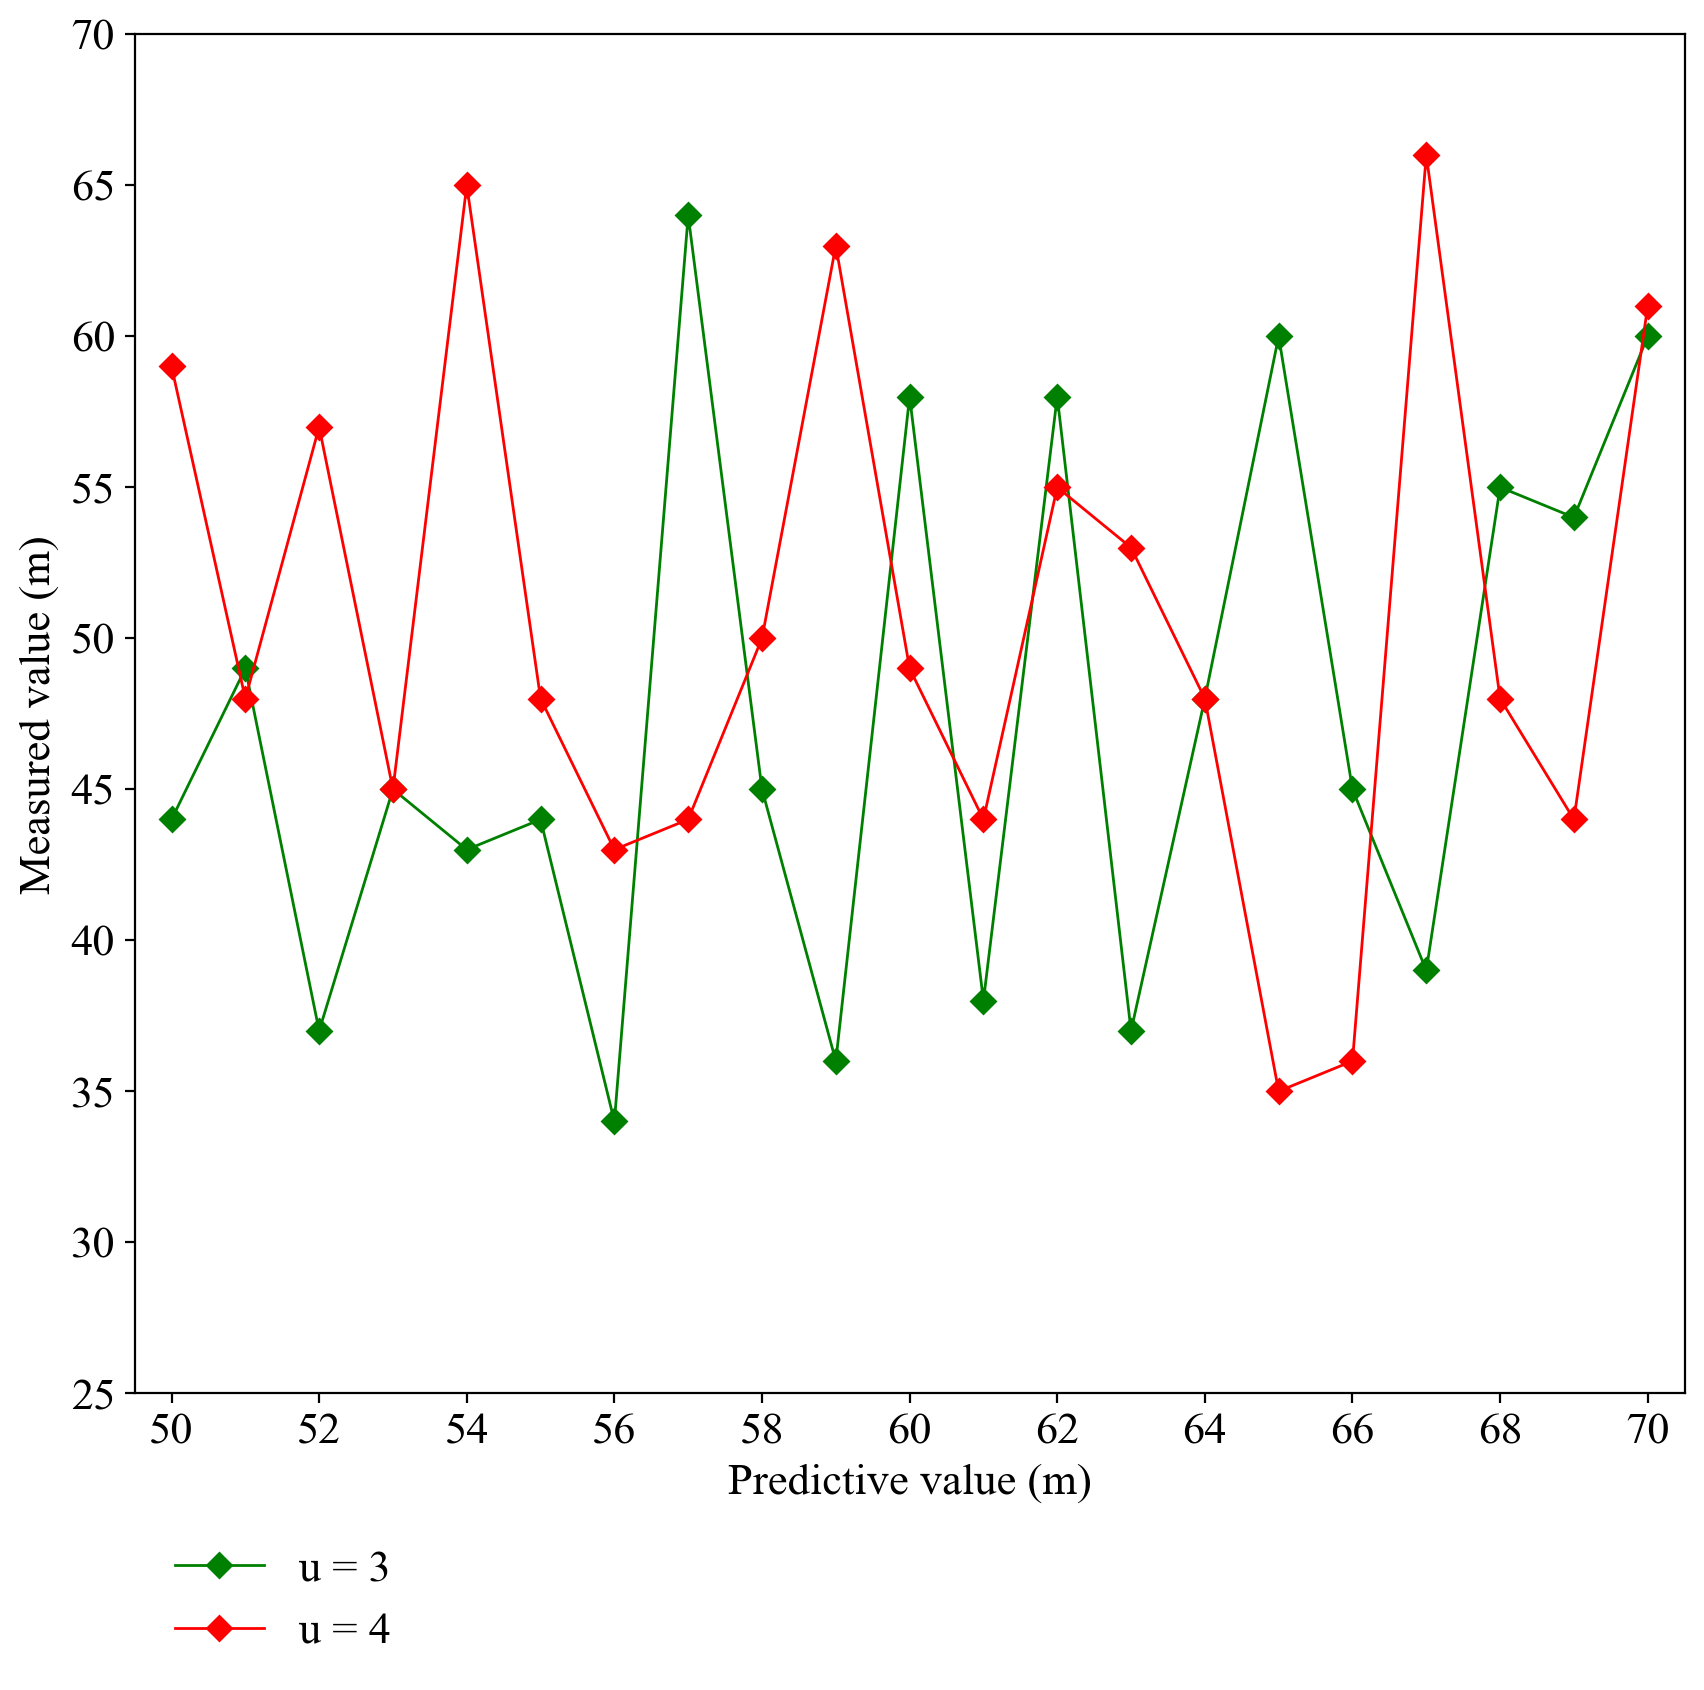

In [2]:
import matplotlib.pyplot as plt 
from matplotlib.pyplot import MultipleLocator

# 字体格式
config = {
    "font.family":'serif',
    "font.size": 16,
    'font.style':'normal',
    'font.weight':'normal',
    "mathtext.fontset":'cm',
    "font.serif": ['Times New Roman'],
    "axes.unicode_minus": False,
}
plt.rcParams.update(config)

u3_x=range(50,71)                       # 横坐标为 50-70
u3_y=[44,49,37,45,43,44,34,64,45,36,58,38,58,37,48,60,45,39,55,54,60]   # 纵坐标
u4_x=range(50,71)       
u4_y=[59,48,57,45,65,48,43,44,50,63,49,44,55,53,48,35,36,66,48,44,61] 

plt.figure(figsize=(10, 9), dpi=200)
x_major_locator=MultipleLocator(2)      # 自定义刻度为 2
y_major_locator=MultipleLocator(5)      # 自定义刻度为 5
ax=plt.gca()
ax.xaxis.set_major_locator(x_major_locator)
ax.yaxis.set_major_locator(y_major_locator)
plt.plot(u3_x,u3_y,label='u = 3',linewidth=1, color='green', marker='D', markersize=6) 
plt.plot(u4_x,u4_y,label='u = 4',linewidth=1, color='red', marker='D', markersize=6) 
plt.xlabel('Predictive value (m)')      # 预测值
plt.ylabel('Measured value (m)')        # 测量值
plt.axis([49.5,70.5,25,70])             # 设置坐标范围
plt.legend(loc=3,bbox_to_anchor=(0,-0.22),frameon=False)
plt.show() 

图片生成

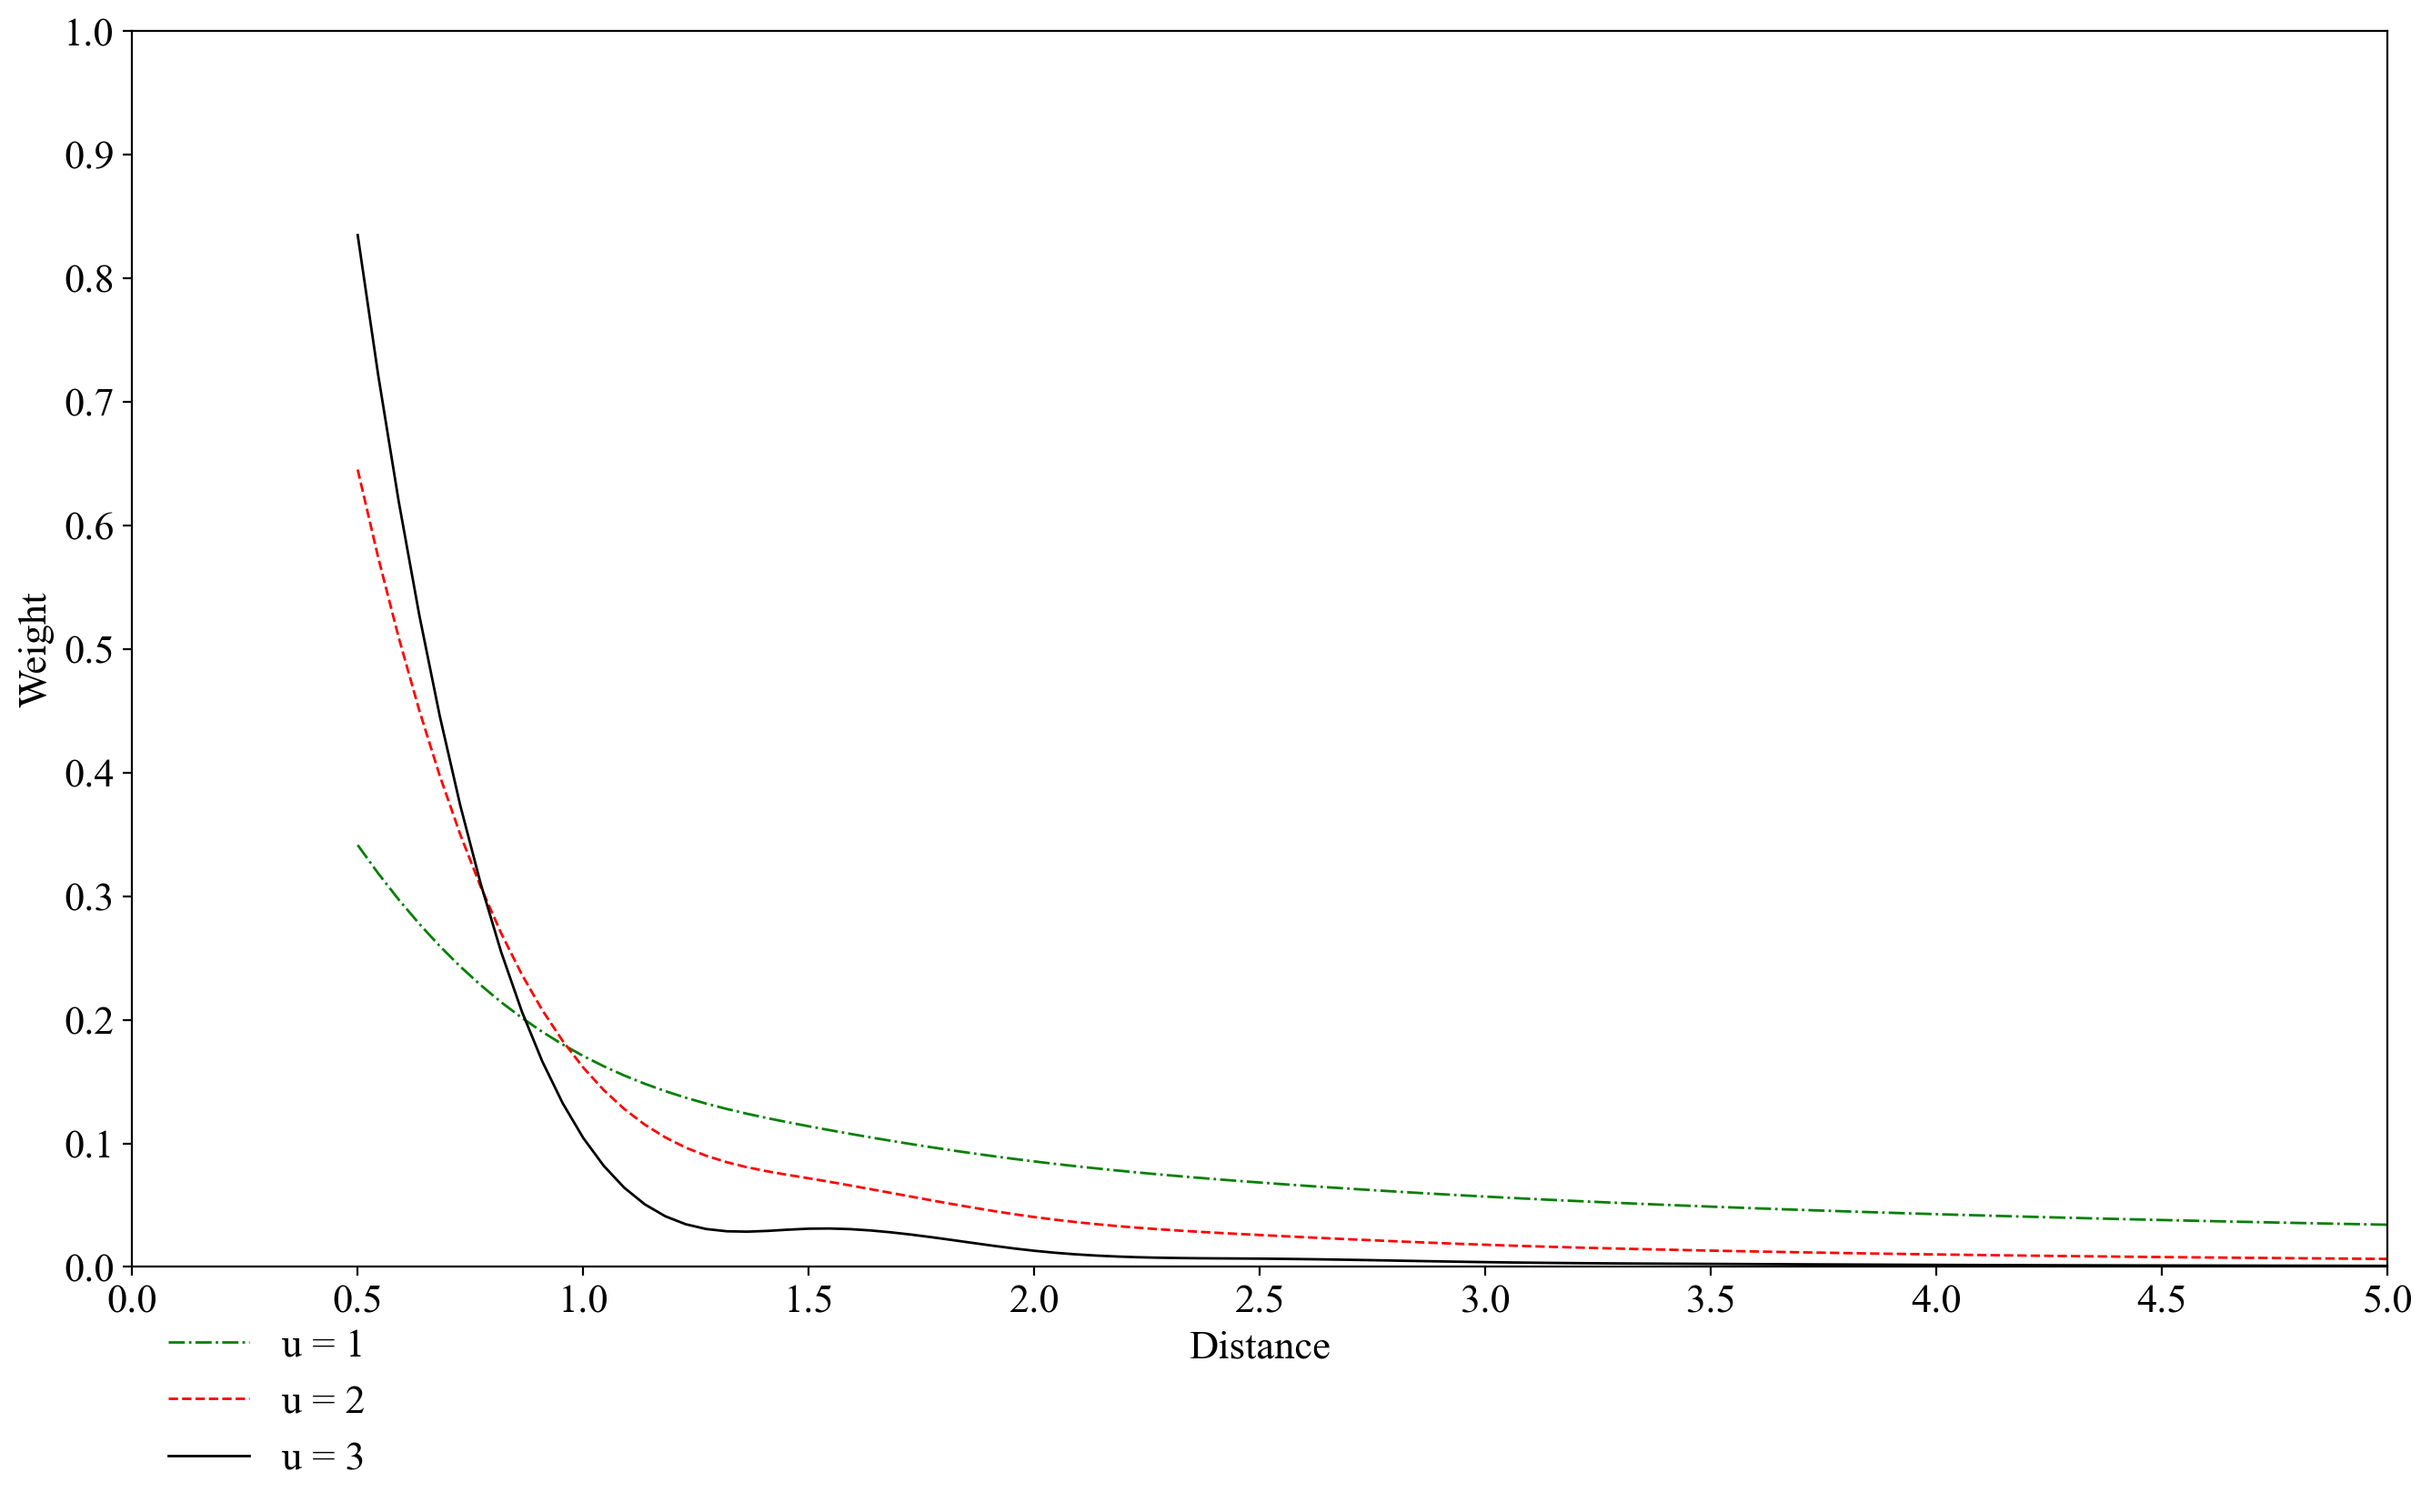

In [32]:
import numpy as np
from matplotlib import pyplot as plt
from scipy.interpolate import make_interp_spline
from matplotlib.pyplot import MultipleLocator

# 字体格式
config = {
    "font.family":'serif',
    "font.size": 16,
    'font.style':'normal',
    'font.weight':'normal',
    "mathtext.fontset":'cm',
    "font.serif": ['Times New Roman'],
    "axes.unicode_minus": False,
}
plt.rcParams.update(config)

# 系数, 采样点到插值点的欧式距离
d = np.array([0.5,1,1.5,2,2.5,3,3.5,4,4.5,5])

W_1 = []
W_2 = []
W_3 = []
for u in range(1,5):
    for i in range(0,d.size):
        if u == 1:
            W_1.append((d[i]*1.0)**(-u))    # 根据距离 d 和权重公式 d^(-u) 计算权重
        if u == 2:
            W_2.append((d[i]*1.0)**(-u))            
        if u == 3:
            W_3.append((d[i]*1.0)**(-u))   
    
# 权重因子
W_1 = W_1 / sum(W_1)
W_2 = W_2 / sum(W_2)
W_3 = W_3 / sum(W_3)

d_smooth = np.linspace(d.min(), d.max(), 100)       # d 平滑处理
W_1_smooth = make_interp_spline(d, W_1)(d_smooth)   # w1 平滑处理
W_2_smooth = make_interp_spline(d, W_2)(d_smooth)
W_3_smooth = make_interp_spline(d, W_3)(d_smooth)
# 设置横轴轴比例，dpi每个间隔的像素点大小
plt.figure(figsize=(16, 9), dpi=200)
x_major_locator=MultipleLocator(0.5)
y_major_locator=MultipleLocator(0.1)
ax=plt.gca()
ax.xaxis.set_major_locator(x_major_locator)         # 设置刻度
ax.yaxis.set_major_locator(y_major_locator)
plt.xlabel('Distance')
plt.ylabel('Weight')
plt.axis([0,5,0.0,1.0])
plt.plot(d_smooth,W_1_smooth,label='u = 1',linewidth=1, color='green', linestyle='-.') 
plt.plot(d_smooth,W_2_smooth,label='u = 2',linewidth=1, color='red', linestyle='--') 
plt.plot(d_smooth,W_3_smooth,label='u = 3',linewidth=1, color='black', linestyle='-') 
plt.legend(loc=3,bbox_to_anchor=(0,-0.2),frameon=False)
plt.show()

$ W = d^{-u}$ 核函数

幂指数 u

$w_i = W_i / sum(W_i)$

权函数

In [8]:
import numpy as np
from matplotlib import pyplot as plt
from scipy.interpolate import make_interp_spline
from matplotlib.pyplot import MultipleLocator

# 字体格式
config = {
    "font.family":'serif',
    "font.size": 16,
    'font.style':'normal',
    'font.weight':'normal',
    "mathtext.fontset":'cm',
    "font.serif": ['Times New Roman'],
    "axes.unicode_minus": False,
}
plt.rcParams.update(config)

# 系数, 采样点到插值点的欧式距离
d = np.array([1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28])

W_1 = []
W_2 = []
W_3 = []
for u in range(1,5):
    for i in range(d.size):
        if u == 1:
            W_1.append((d[i]*1.0)**(-u))    # 根据距离 d 和权重公式 d^(-u) 计算权重
        if u == 2:
            W_2.append((d[i]*1.0)**(-u))            
        if u == 3:
            W_3.append((d[i]*1.0)**(-u))   
    
# 权重因子
W_1 = np.array(W_1)     
W_2 = np.array(W_2)
W_3 = np.array(W_3)
d_smooth = np.linspace(d.min(), d.max(), 100)       # d 平滑处理
W_1_smooth = make_interp_spline(d, W_1)(d_smooth)   # w1 平滑处理
W_2_smooth = make_interp_spline(d, W_2)(d_smooth)
W_3_smooth = make_interp_spline(d, W_3)(d_smooth)
# 设置横轴轴比例，dpi每个间隔的像素点大小
plt.figure(figsize=(16, 9), dpi=200)
x_major_locator=MultipleLocator(1)
y_major_locator=MultipleLocator(0.1)
ax=plt.gca()
ax.xaxis.set_major_locator(x_major_locator)         # 设置刻度
ax.yaxis.set_major_locator(y_major_locator)
plt.xlabel('Distance')
plt.ylabel('Weight coefficient')
plt.axis([0.5,28.5,0.0,1.0])
plt.plot(d_smooth,W_1_smooth,label='u = 1',linewidth=1, color='green', linestyle='-.') 
plt.plot(d_smooth,W_2_smooth,label='u = 2',linewidth=1, color='red', linestyle='--') 
plt.plot(d_smooth,W_3_smooth,label='u = 3',linewidth=1, color='black', linestyle='-') 
plt.legend(loc=3,bbox_to_anchor=(0,-0.2),frameon=False)
plt.show()

SyntaxError: unmatched ')' (Temp/ipykernel_181512/2966826516.py, line 27)

**权重因子**

$ W = (\alpha*d^{-ku}+u/k + \varepsilon)*cv$

$ \alpha=0.6， k = 1，\varepsilon服从下表对应d的分布： $

| d | 1 | 2 | 3 | 4 | 5 | 6 | 7 | 8 | 9 | 10 | 11 | 12 | 13 | 14 |
|:--:|:--:|:--:|:--:|:--:|:--:|:--:|:--:|:--:|:--:|:--:|:--:|:--:|:--:|:--:|
|$\varepsilon$|0|0.430211|0.300124|0.200563|0.100278|0.060042|0.030086|0.020019|0.010045|0.006258|-0.005583|-0.005593|-0.005801|-0.006241|
| d | 15 | 16 | 17 | 18 | 19 | 20 | 21 | 22 | 23 | 24 | 25 | 26 | 27 | 28 |
|$\varepsilon$|-0.008119|-0.016237|-0.019347|-0.020067|-0.020935|-0.021559|-0.023122|-0.026291|-0.028590|-0.0292467|-0.031117|-0.033642|-0.036798|-0.037305|

cv服从下表c分布：
| c | 0 | 60 | 100 | 200 | 250 | 300 | 350 | 400 | 500 | 600 | 700 | 800 | 900 | 1000 |
|:--:|:--:|:--:|:--:|:--:|:--:|:--:|:--:|:--:|:--:|:--:|:--:|:--:|:--:|:--:|
|cv|0.9|0.95|1|1.01|1.015|1.02|1.025|1.03|1.04|1.05|1.06|1.07|1.08|1.1|

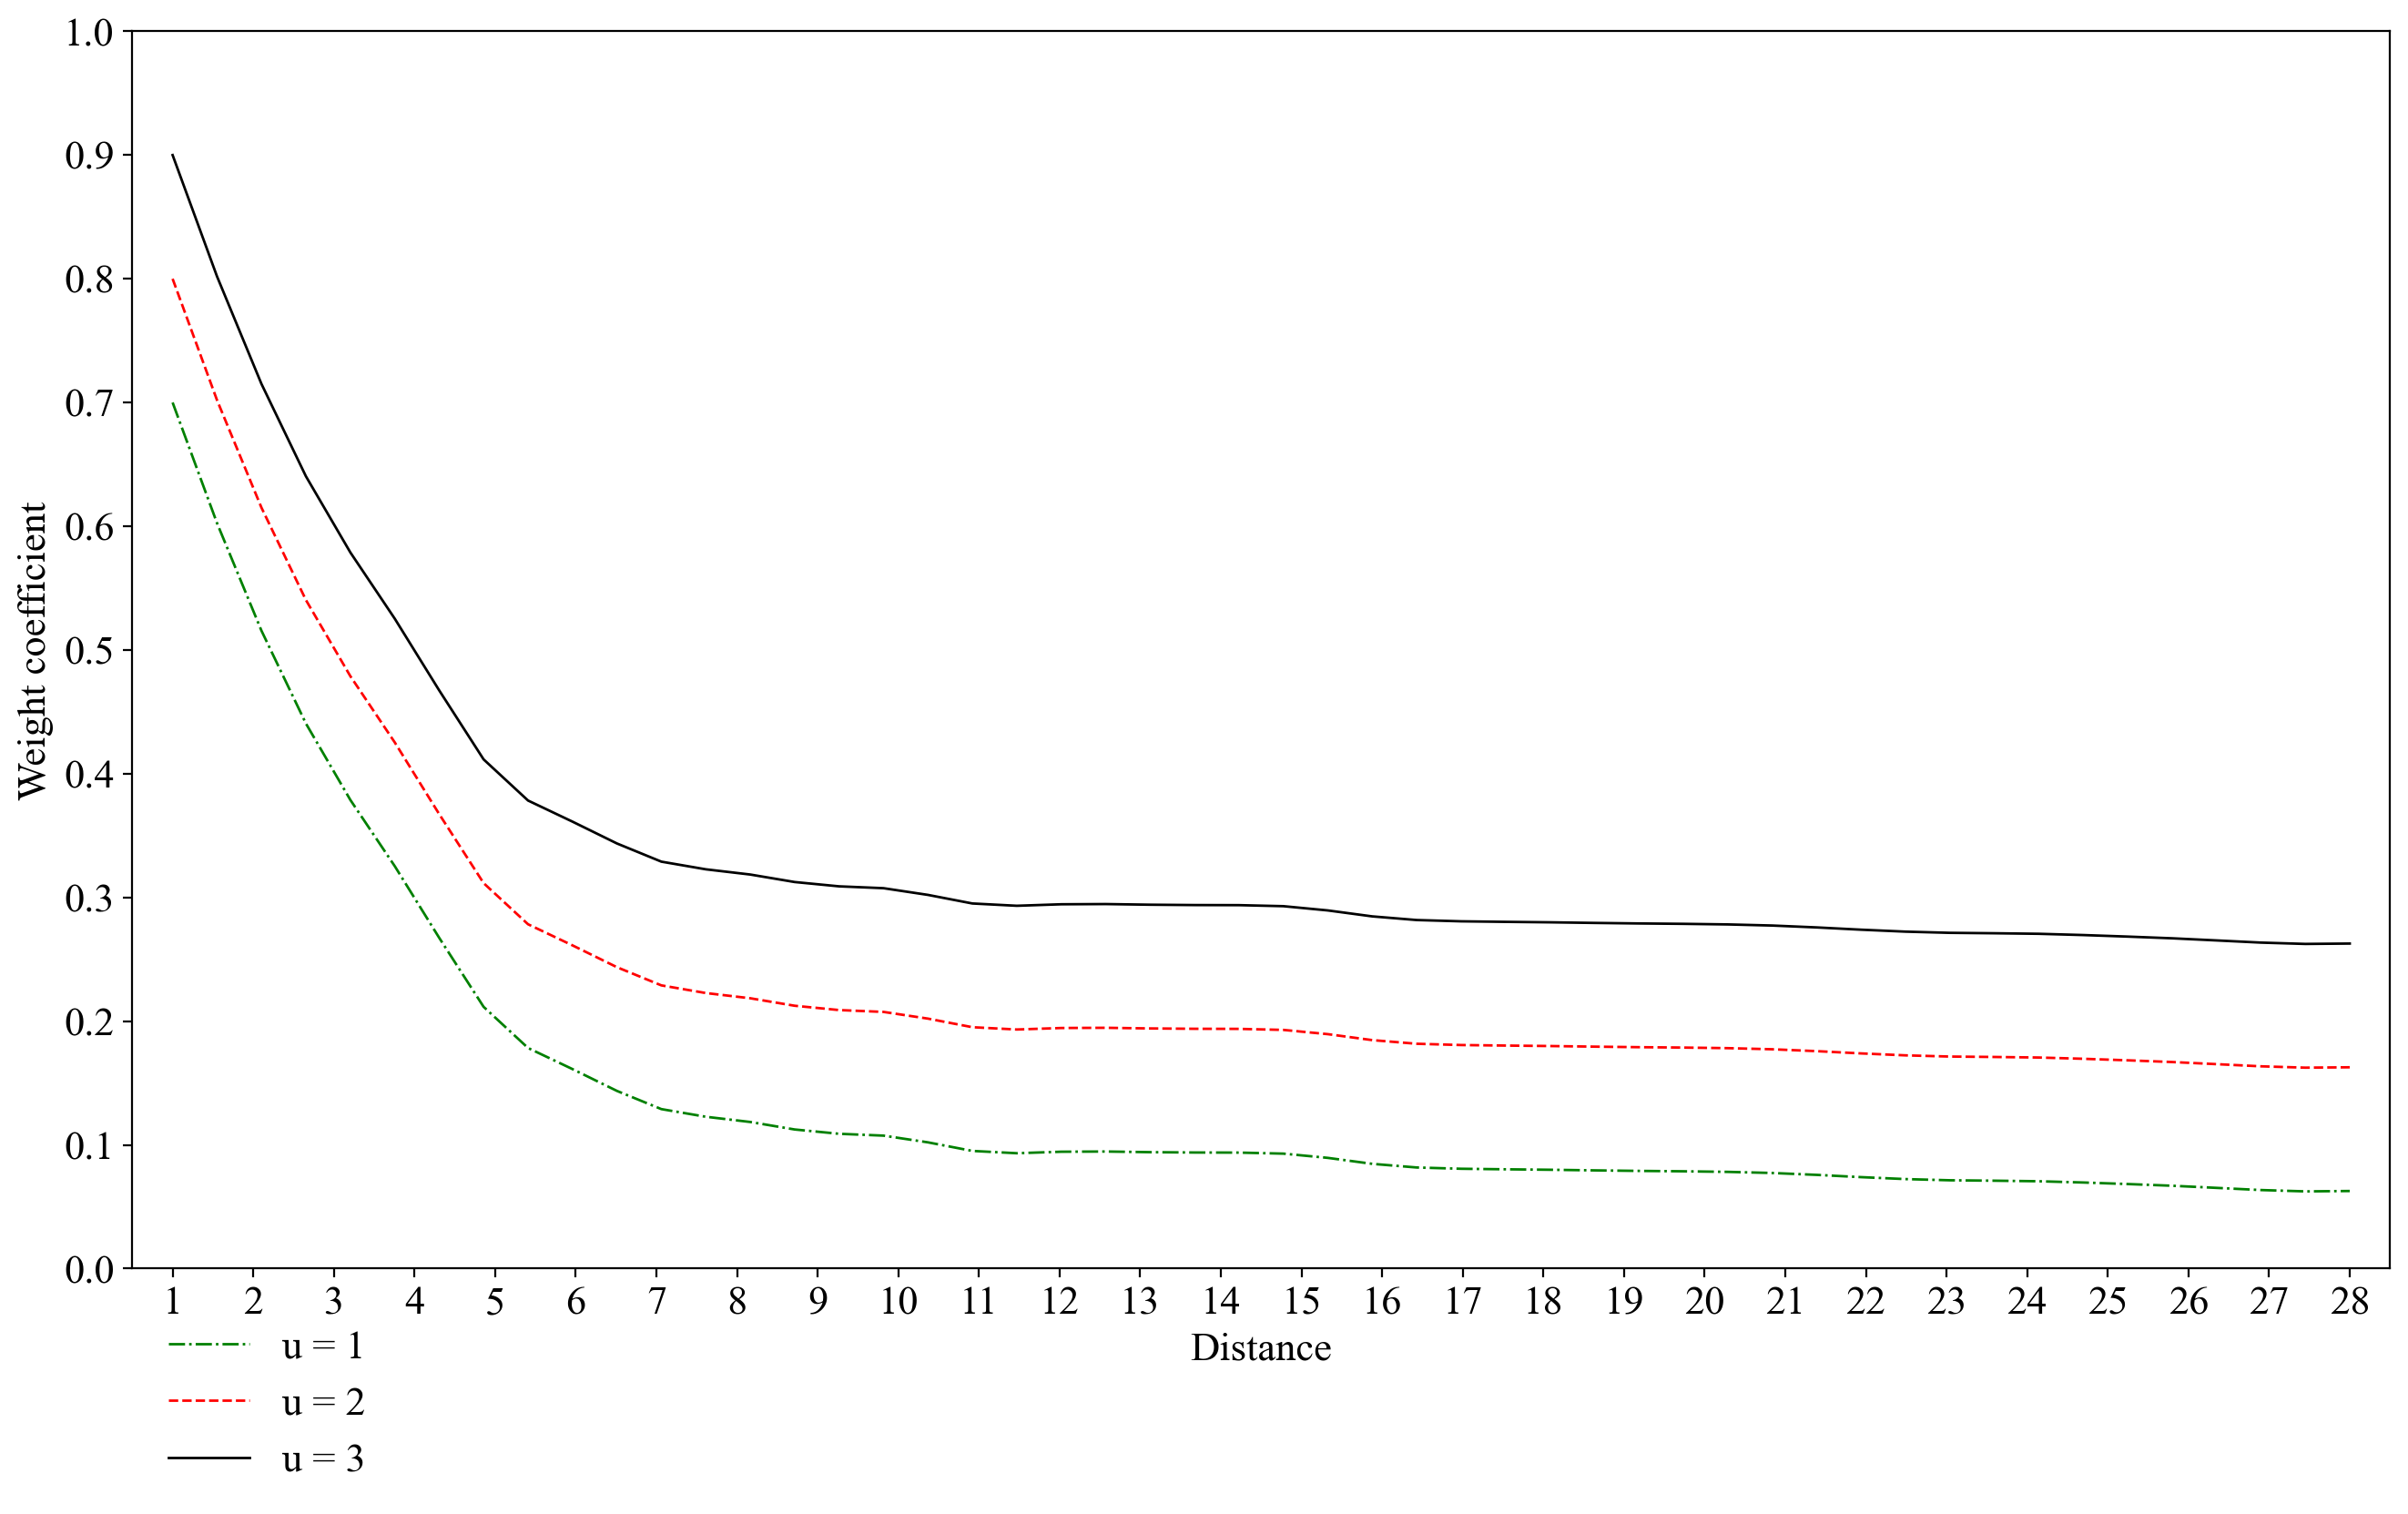

In [14]:
import numpy as np
from matplotlib import pyplot as plt
from scipy.interpolate import make_interp_spline
from matplotlib.pyplot import MultipleLocator

# 字体格式
config = {
    "font.family":'serif',
    "font.size": 16,
    'font.style':'normal',
    'font.weight':'normal',
    "mathtext.fontset":'cm',
    "font.serif": ['Times New Roman'],
    "axes.unicode_minus": False,
}
plt.rcParams.update(config)

# 系数
alpha = 0.6
k = 10.0
d = np.array([1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28])
e = np.array([0.0, 0.430211,0.300124,0.200563,0.100278,0.060042,0.030086,0.020019,0.010045,0.006258,-0.005583, -0.005593, -0.005801, -0.006241, -0.008119, -0.016237, -0.019347, -0.020067, -0.020935, 
              -0.021559, -0.023122, -0.026291, -0.028590, -0.0292467, -0.031117, -0.033642, -0.036798, -0.037305])
cmap = {0:0.9,60:0.95,100:1,200:1.01,250:1.015,300:1.02,350:1.025,400:1.03,500:1.04,600:1.05,700:1.06,800:1.07,900:1.08,1000:1.1}
c = 100 # smooth factor

W_1 = []
W_2 = []
W_3 = []
for u in range(1,5):
    for i in range(d.size):
        if u == 1:
            W_1.append(alpha*d[i]**(-u*k) + (u/k) + e[i]) # c=100
        if u == 2:
            W_2.append(alpha*d[i]**(-u*k) + (u/k) + e[i])            
        if u == 3:
            W_3.append(alpha*d[i]**(-u*k) + (u/k) + e[i])   
    
## 计算平滑后的 x 和 y
W_1 = np.array(W_1)
W_2 = np.array(W_2)
W_3 = np.array(W_3)
d_smooth = np.linspace(d.min(), d.max(), 50) # c=100
W_1_smooth = make_interp_spline(d, W_1)(d_smooth)
W_2_smooth = make_interp_spline(d, W_2)(d_smooth)
W_3_smooth = make_interp_spline(d, W_3)(d_smooth)

## 画图
# 设置横轴轴比例，dpi每个间隔的像素点大小
plt.figure(figsize=(16, 9), dpi=200)
x_major_locator=MultipleLocator(1)
y_major_locator=MultipleLocator(0.1)
ax=plt.gca()
ax.xaxis.set_major_locator(x_major_locator)
ax.yaxis.set_major_locator(y_major_locator)
plt.xlabel('Distance')
plt.ylabel('Weight coefficient')    # 权重系数
plt.axis([0.5,28.5,0.0,1.0])
plt.plot(d_smooth,W_1_smooth,label='u = 1',linewidth=1, color='green', linestyle='-.') 
plt.plot(d_smooth,W_2_smooth,label='u = 2',linewidth=1, color='red', linestyle='--') 
plt.plot(d_smooth,W_3_smooth,label='u = 3',linewidth=1, color='black', linestyle='-') 
plt.legend(loc=3,bbox_to_anchor=(0,-0.2),frameon=False)
plt.show()

1 Inverse distance weighted interpolation
反距离加权插值

In [6]:
import numpy as np
import math
import random
from matplotlib import pyplot as plt
from scipy.interpolate import make_interp_spline
from matplotlib.pyplot import MultipleLocator
# 系数
alpha = 0.6
beta = 0.0015
k = 1
l = 1
u = 1
"""
1 2 2 2 2 2 2 1 1
1 2 2 2 2 2 2 2 1
2 2 2 2 2 2 2 2 2
2 2 2 2 2 2 2 2 2
2 2 2 2 1 2 2 2 2
2 2 2 2 2 2 2 2 2
2 2 2 2 2 2 2 2 2
1 2 2 2 2 2 2 2 1 
1 1 2 2 2 2 2 2 1
"""
# 实际值
S = np.array([
    [0.30, 0.50, 0.40, 0.50, 0.60, 0.60, 0.50, 0.53, 0.56, 0.58, 0.59, 0.61, 0.62, 0.66, 0.88, 1.19, 1.68, 3.10, 4.10, 6.20],
    [0.35, 0.40, 0.50, 0.70, 0.65, 0.70, 0.85, 1.58, 1.59, 1.20, 0.61, 0.64, 0.64, 0.68, 0.87, 1.19, 1.69, 3.30, 4.50, 6.70],
    [0.40, 0.40, 0.43, 0.60, 0.71, 0.72, 1.52, 1.62, 1.61, 1.60, 0.60, 0.62, 0.64, 0.69, 0.91, 1.20, 1.72, 3.80, 4.70, 6.90],
    [0.50, 0.50, 0.40, 0.40, 0.65, 0.66, 0.67, 1.15, 1.25, 1.06, 0.77, 0.57, 0.62, 0.65, 0.86, 1.19, 1.73, 3.80, 4.90, 7.10],
    [0.40, 0.50, 0.40, 0.40, 0.44, 0.48, 0.50, 0.52, 0.53, 0.52, 0.51, 0.54, 0.60, 0.63, 0.85, 1.19, 1.75, 4.00, 5.20, 7.21]])
# S 表示所有采样点 shape = (5, 20)

# 加载k分别为1,2,3,4的不同经验e
e = {}
e[1] = [0.0, 3.230346, 6.365597, 9.287162]
e[2] = [0.0, -3.511123, -2.150457, 0.765123]
e[3] = [0.0, -0.003001, -0.004572, 0.100655]
e[4] = [0.0, 4.431211, -39.770867, -18.548721]
e[10] = [0.0, 0.430211,0.300124,0.200563,0.100278,0.060042,0.030086,0.020019,0.010045,0.006258,-0.005583, -0.005593, -0.005801, -0.006241, -0.008119, -0.016237, -0.019347, -0.020067, -0.020935, 
              -0.021559, -0.023122, -0.026291, -0.028590, -0.0292467, -0.031117, -0.033642, -0.036798, -0.037305]

# 坐标差 loc
# 通过下标计算两点的距离，选点的方式为固定的16个点：(-2,0),(-1,-2~2),(0,-2~2),(1,-2~2),(2,0)
loc = np.array([[-2,0],[-1,-2],[-1,-1],[-1,0],[-1,1],[-1,2],[0,-2],[0,-1],[0,1],[0,2],[1,-2],[1,-1],[1,0],[1,1],[1,2],[2,0]])


# 距离数组 d
d = []
for i in range(loc.shape[0]):
    d.append(math.sqrt((loc[i][0])**2 + (loc[i][1])**2)*l)
d = np.array(d)
# print(d)


# 计算权重
print("[Inverse distance weighted]")
# 设定距离大于30的权重系数计算公式如为：w = alpha*d[i]**(-u*k) + (u/k) + e
for k in range(1,5):
    w = []
    for i in range(d.size):
        floor = math.floor(d[i])
        wi = alpha*d[i]**(-u*k) + (u/k) + e[k][floor-1] + (d[i]-floor)*(e[k][floor]-e[k][floor-1]) #加e项，小数的时候按比例折算
        w.append(wi)
    
    # print(e)    
    w = np.array(w/sum(w))  # 16 个采样点，16 个权重


    # 记录所有采样点
    SP = []
    # 取Si从第3行第3列开始向右取点p, p点的下标的范围为(2,2~17)
    row = 2
    cols = np.arange(2,18,1) # 2-17 列
    delta = [] #记录残差
    for col in range(2,18): # 计算的点共 16 个, 下标范围为 (2, 2~17)
        # row, col对应的p
        Si = []     # 待插值点附近的采样点 共 16 个
        for i in range(d.size):
            Si.append(S[row+loc[i][0]][col+loc[i][1]])
        Si = np.array(Si)
        # 计算Z(p)，加权求和
        Zp_ = w.dot(Si.T)   # 预测值
        Zp = S[row][col]    # 实际值
        #print(Zp, Zp_)
        delta.append(Zp - Zp_) #残差
        
    delta = np.array(delta)         # 16 个残差
    # 计算Q
    Q = sum(delta**2) /cols.size    # 残差平方和的平均值
    p = sum(delta) / cols.size      # 残差的平均值
    error = math.sqrt(sum(abs(delta - p)**2)/(cols.size-1))     # 残差的标准差
    print("K=",k ,",Q=", Q,",Residual=",p,"Error=", error)

[Inverse distance weighted]
K= 1 ,Q= 0.16239327808561135 ,Residual= 0.02379260942397768 Error= 0.41547041909611726
K= 2 ,Q= 0.25756365219584504 ,Residual= 0.00977642807017734 Error= 0.5240540161981103
K= 3 ,Q= 0.10362669296641243 ,Residual= 0.04593422720036697 Error= 0.329066136797927
K= 4 ,Q= 0.4366329251090697 ,Residual= 0.4657204846563362 Error= 0.4841348079814542


2 Kriging interpolation 克里金插值

In [8]:
from pykrige.ok import OrdinaryKriging
import numpy as np
from matplotlib import pyplot as plt

# 已知采样点的数据，是坐标（x，y）和坐标对应的值
# 矩阵中第一列是x,第二列是y,第三列是坐标对应的值
mea_data = np.array([
    [2,2,0.43], [2,3,0.60], [2,4,0.71], [2,5,0.72], [2,6,1.52], [2,7,1.62], [2,8,1.61], [2,9,1.60], [2,10,0.60], [2,11,0.62], [2,12,0.64], [2,13,0.69], [2,14,0.91], [2,15,1.20], [2,16,1.72], [2,17,3.80]])
data = np.array([
    [0,0,0.30], [0,1,0.50], [0,2,0.40], [0,3,0.50], [0,4,0.60], [0,5,0.60], [0,6,0.50], [0,7,0.53], [0,8,0.56], [0,9,0.58], [0,10,0.59], [0,11,0.61], [0,12,0.62], [0,13,0.66], [0,14,0.88], [0,15,1.19], [0,16,1.68], [0,17,3.10], [0,18,4.10], [0,19,6.20],
    [1,0,0.35], [1,1,0.40], [1,2,0.50], [1,3,0.70], [1,4,0.65], [1,5,0.70], [1,6,0.85], [1,7,1.58], [1,8,1.59], [1,9,1.20], [1,10,0.61], [1,11,0.64], [1,12,0.64], [1,13,0.68], [1,14,0.87], [1,15,1.19], [1,16,1.69], [1,17,3.30], [1,18,4.50], [1,19,6.70],
    [2,0,0.40], [2,1,0.40], [2,18,4.70], [2,19,6.90],
    [3,0,0.50], [3,1,0.50], [3,2,0.40], [3,3,0.40], [3,4,0.65], [3,5,0.66], [3,6,0.67], [3,7,1.15], [3,8,1.25], [3,9,1.06], [3,10,0.77], [3,11,0.57], [3,12,0.62], [3,13,0.65], [3,14,0.86], [3,15,1.19], [3,16,1.73], [3,17,3.80], [3,18,4.90], [3,19,7.10],
    [4,0,0.40], [4,1,0.50], [4,2,0.40], [4,3,0.40], [4,4,0.44], [4,5,0.48], [4,6,0.50], [4,7,0.52], [4,8,0.53], [4,9,0.52], [4,10,0.51], [4,11,0.54], [4,12,0.60], [4,13,0.63], [4,14,0.85], [4,15,1.19], [4,16,1.75], [4,17,4.00], [4,18,5.20], [4,19,7.21]])

# 网格
x_range = 5
y_range = 20
range_step = 1
gridx = np.arange(0.0, x_range, range_step) #三个参数的意思：范围0.0 - 0.6 ，每隔0.1划分一个网格
gridy = np.arange(0.0, y_range, range_step)
# variogram_model是变差函数模型，
# pykrige提供 linear, power, gaussian, spherical, exponential, hole-effect几种variogram_model可供选择，默认的为linear模型。
# 使用不同的variogram_model，预测效果是不一样的，应该针对自己的任务选择合适的variogram_model。
ok3d = OrdinaryKriging(data[:, 0], data[:, 1], data[:, 2], variogram_model="power") # 模型
k3d1, ss3d = ok3d.execute("grid", gridx, gridy) # k3d1是结果，给出了每个网格点处对应的值
pred = (np.round(k3d1, 2).T)[2,2:18] #预测的结果
mead = mea_data[:,2].T #实际值
delta = mead - pred
# 计算Q
Q = sum(delta**2) /pred.size
p = sum(delta) / pred.size
error = math.sqrt(sum(abs(delta - p)**2)/(pred.size-1))
print("[Kriging] Q=", Q, ",Residual=",p,",Error=", error)

[Kriging] Q= 0.8234375 ,Residual= -0.23625000000000004 ,Error= 0.9048747611318005


3 Nearest neighbor interpolation 最近邻插值

In [9]:
import numpy as np
import math
import random

random.seed(2022)
S = np.array([
    [0.30, 0.50, 0.40, 0.50, 0.60, 0.60, 0.50, 0.53, 0.56, 0.58, 0.59, 0.61, 0.62, 0.66, 0.88, 1.19, 1.68, 3.10, 4.10, 6.20],
    [0.35, 0.40, 0.50, 0.70, 0.65, 0.70, 0.85, 1.58, 1.59, 1.20, 0.61, 0.64, 0.64, 0.68, 0.87, 1.19, 1.69, 3.30, 4.50, 6.70],
    [0.40, 0.40, 0.43, 0.60, 0.71, 0.72, 1.52, 1.62, 1.61, 1.60, 0.60, 0.62, 0.64, 0.69, 0.91, 1.20, 1.72, 3.80, 4.70, 6.90],
    [0.50, 0.50, 0.40, 0.40, 0.65, 0.66, 0.67, 1.15, 1.25, 1.06, 0.77, 0.57, 0.62, 0.65, 0.86, 1.19, 1.73, 3.80, 4.90, 7.10],
    [0.40, 0.50, 0.40, 0.40, 0.44, 0.48, 0.50, 0.52, 0.53, 0.52, 0.51, 0.54, 0.60, 0.63, 0.85, 1.19, 1.75, 4.00, 5.20, 7.21]])

# 最近邻插值，即寻找最邻近的值作为它的值
loc = np.array([[-1,0],[1,0],[0,1],[0,-1]])
# 取Si从第3行第3列开始向右取点p，p点的下标的范围为(2,2~17)
row = 2
cols = np.arange(2,18,1)
delta = [] #记录残差
for col in range(2,18):
    i = round(random.uniform(0,3))
    Zp_ = S[row+loc[i][0]][col+loc[i][1]]
    Zp = S[row][col]
    # print(Zp, Zp_)
    delta.append(Zp - Zp_) #残差
    
delta = np.array(delta)
# 计算Q
Q = sum(delta**2) /cols.size
p = sum(delta) / cols.size
error = math.sqrt(sum(abs(delta - p)**2)/(cols.size-1))
print("[Nearest neighbor] Q=", Q,",Residual=",p,"Error=", error)

[Nearest neighbor] Q= 0.38489375000000003 ,Residual= -0.05812500000000001 Error= 0.6379260014557592


**The scatter relationship between the actual measured value and the predicted value of the sampling point**

采样点实际测量值与预测值的散布关系

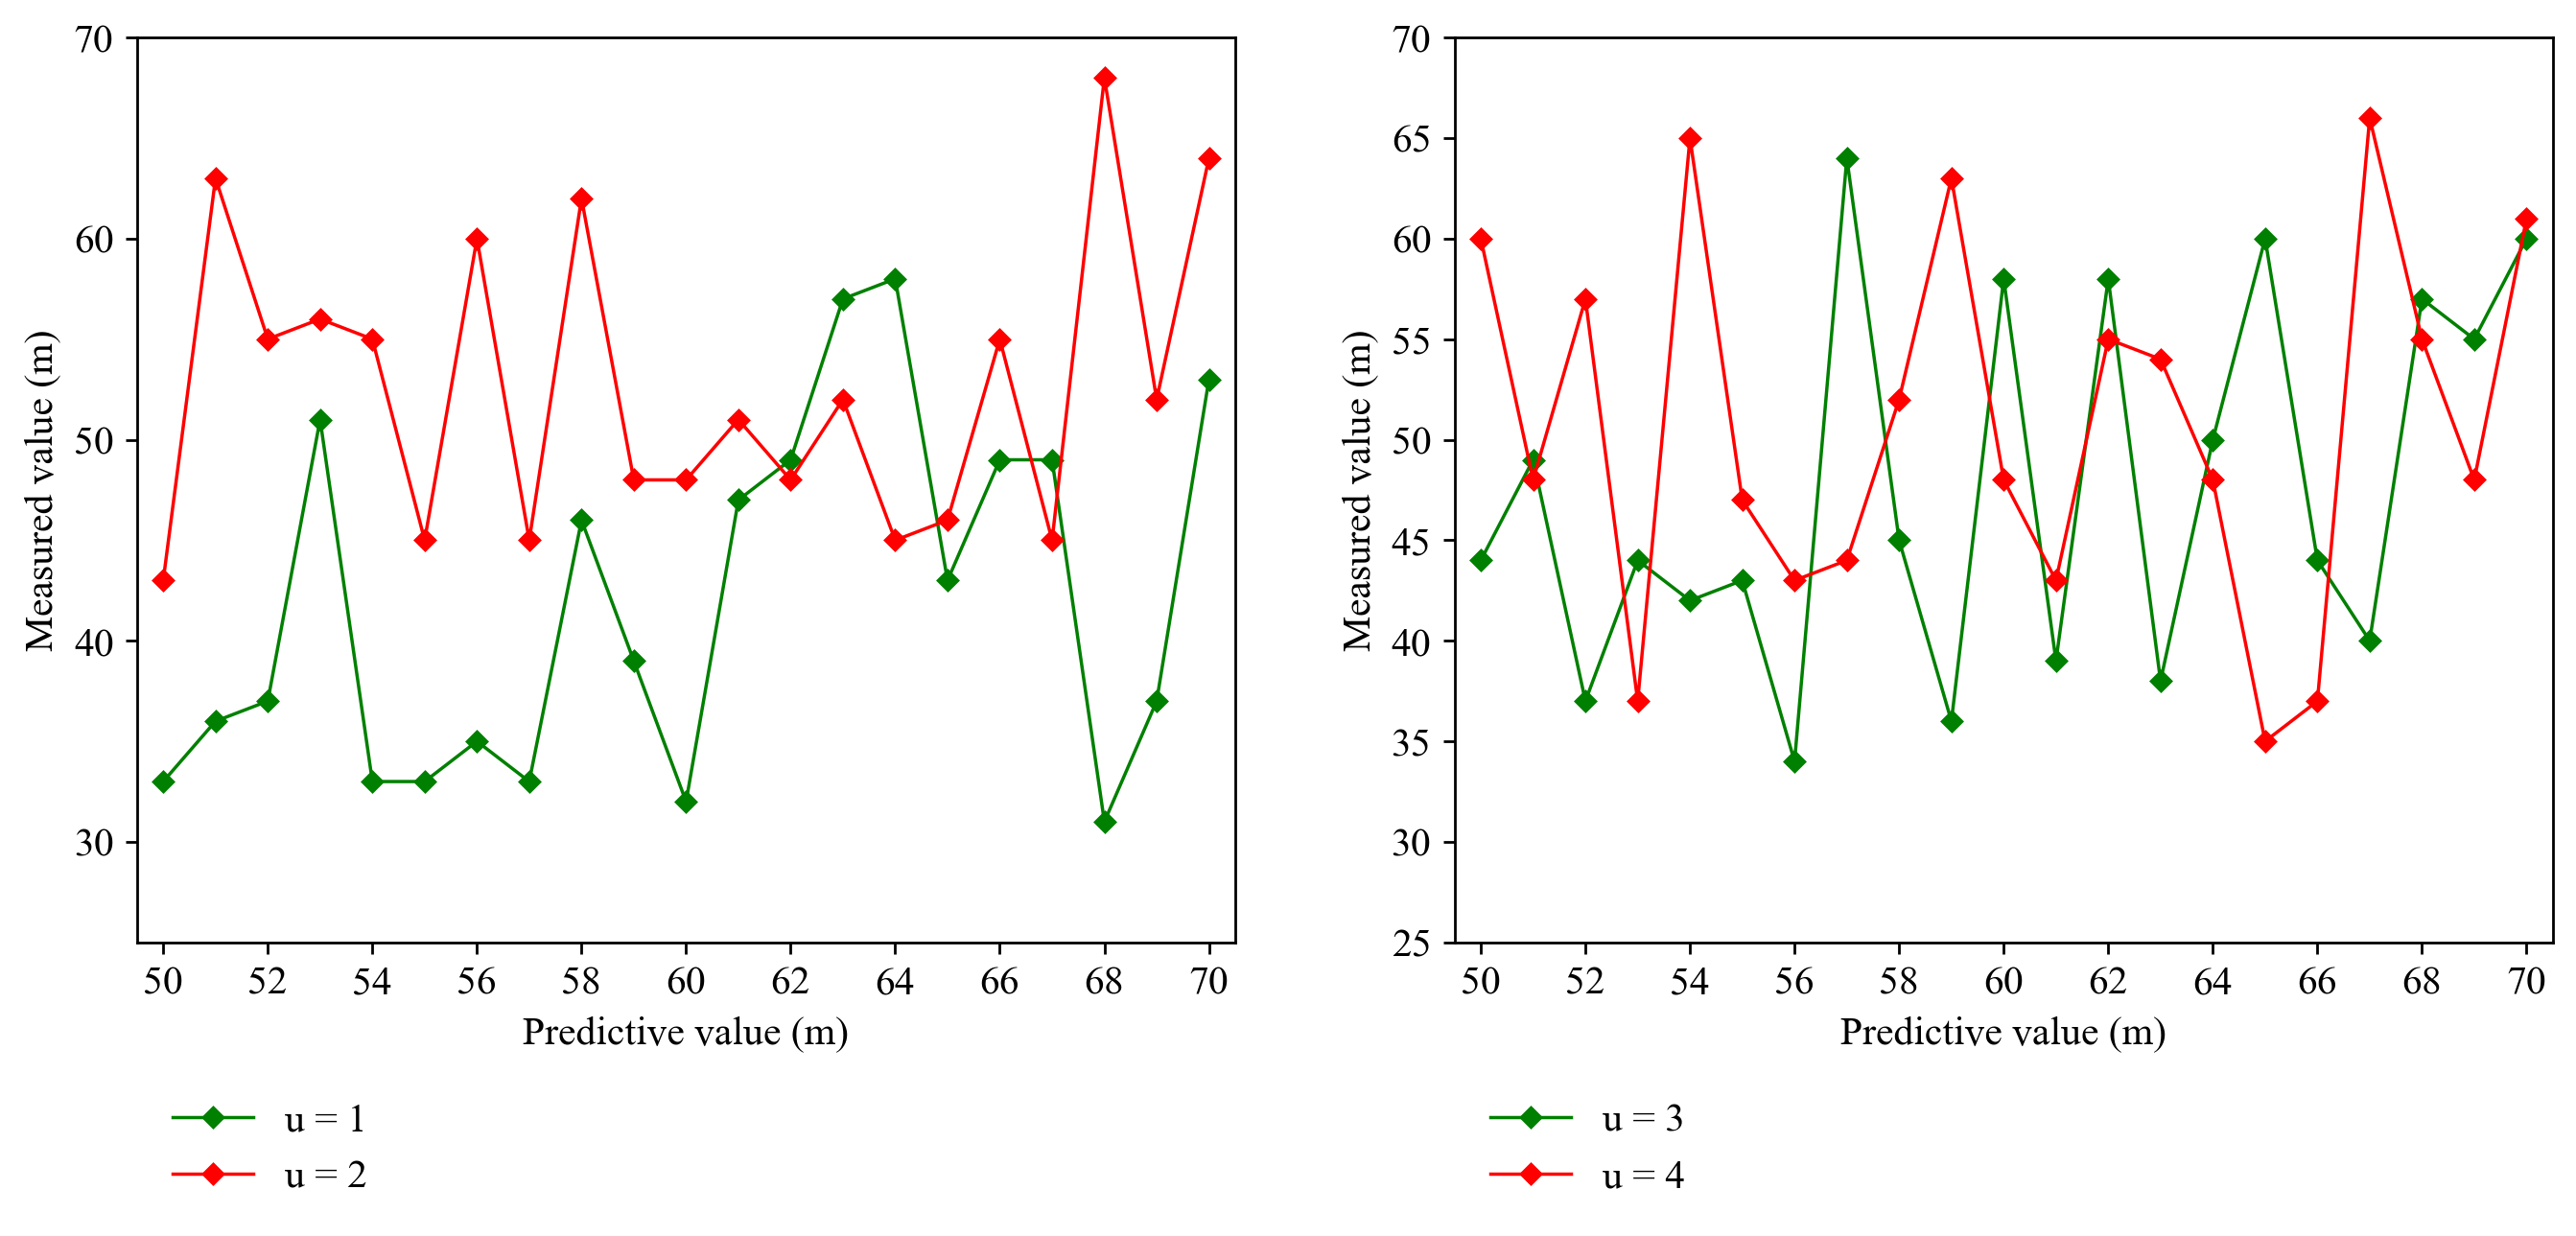

In [8]:
import numpy as np
import math
import matplotlib.pyplot as plt 
from matplotlib.pyplot import MultipleLocator

# 字体格式
config = {
    "font.family":'serif',
    "font.size": 12,
    'font.style':'normal',
    'font.weight':'normal',
    "mathtext.fontset":'cm',
    "font.serif": ['Times New Roman'],
    "axes.unicode_minus": False,
}
plt.rcParams.update(config)

# 以采样点为4个点的预测为例
"""
1 2 1
2 1 0 2
1 2 1
"""
# 加载k分别为1,2,3,4的不同经验e
e = {}
e[1] = [0.0, 3.230346, 6.365597, 9.287162]
e[2] = [0.0, -3.511123, -2.150457, 0.765123]
e[3] = [0.0, -0.003001, -0.004572, 0.100655]
e[4] = [0.0, 4.431211, -39.770867, -8.100655]
d = np.array([1,1,1,2])
k = 3.0
l = 30
#记录所有位置
S = {}
# 前4个值为周边4个采样点的高度，第5个为测量值
S[1] = np.array([
    [49,52,51,48],[47,58,50,48],[49,58,51,48],[52,58,51,50],[53,60,51,51],
    [49,65,53,51],[63,58,51,48],[65,58,51,53],[53,66,55,60],[66,58,56,53],
    [62,58,55,70],[66,58,57,65],[66,58,58,69],[65,62,59,71],[67,62,61,71],
    [65,62,65,71],[67,63,66,73],[67,67,66,71],[65,65,73,71],[65,71,70,71],
    [68,70,72,71]])
S[2] = np.array([
    [48,53,51,47],[46,58,51,48],[49,58,51,48],[53,58,51,48],[51,59,55,49],
    [49,56,64,49],[52,58,62,48],[54,58,55,66],[67,58,52,53],[59,62,57,58],
    [65,58,55,63],[64,63,59,58],[66,58,58,70],[66,60,59,72],[65,64,59,71],
    [66,62,64,71],[67,62,65,73],[65,67,66,73],[65,72,66,71],[65,70,72,71],
    [67,70,72,71]])
S[3] = np.array([
    [49,58,46,45],[49,55,51,48],[49,58,51,48],[49,57,54,51],[55,58,51,50],
    [49,66,51,52],[64,58,51,48],[52,70,53,50],[53,68,56,53],[63,58,53,63],
    [70,58,51,63],[68,58,61,56],[66,60,59,64],[66,58,59,72],[65,64,59,71],
    [65,65,61,71],[67,62,66,73],[67,63,68,73],[72,65,66,71],[65,69,73,71],
    [66,72,72,71]])
S[4] = np.array([
    [47,60,44,48],[49,56,51,48],[49,58,51,48],[52,57,54,48],[50,60,55,49],
    [49,55,65,49],[65,58,51,48],[55,56,63,52],[70,58,51,52],[60,58,55,65],
    [69,58,51,65],[59,61,60,67],[66,59,59,65],[66,58,59,72],[65,62,61,71],
    [67,62,61,73],[67,66,61,73],[67,65,66,73],[66,70,66,72],[68,65,73,71],
    [65,73,72,71]])
# u = 1时预测值分别为50-70的位置信息
w = {}
for u in range(1,5):
    wu = []
    for i in range(d.size):
        floor = math.floor(d[i])
        wi = alpha*d[i]**(-u*k) + (u/k) + e[k][floor-1] + (d[i]-floor)*(e[k][floor]-e[k][floor-1]) #加e项，小数的时候按比例折算
        wu.append(wi)
    wu = np.array(wu)
    w[u] = np.array(wu/sum(wu))
# 此时u不同，权重系数不一样
# print(w)
M = {}
M[1] = np.array([33,36,37,51,33,33,35,33,46,39,32,47,49,57,58,43,49,49,31,37,53])
M[2] = np.array([43,63,55,56,55,45,60,45,62,48,48,51,48,52,45,46,55,45,68,52,64])
M[3] = np.array([44,49,37,44,42,43,34,64,45,36,58,39,58,38,50,60,44,40,57,55,60])
M[4] = np.array([60,48,57,37,65,47,43,44,52,63,48,43,55,54,48,35,37,66,55,48,61])

Zp = {}
for u in range(1,5):
    Zp_u = []
    for i in range(21): 
        Zp_ = w[u].dot(S[u][i].T)
        Zp_u.append(round(Zp_)) #四舍五入取整
    Zp[u] = np.array(Zp_u)
# print(Zp)
# 画图
pred = np.arange(50,71)
# 设置横轴轴比例，dpi每个间隔的像素点大小
plt.figure(figsize=(13, 5), dpi=250)
# 第一个图
plt.subplot(121)
x_major_locator=MultipleLocator(2)
#把x轴的刻度间隔设置为1，并存在变量里
y_major_locator=MultipleLocator(10)
#把y轴的刻度间隔设置为10，并存在变量里
ax=plt.gca()
#ax为两条坐标轴的实例
ax.xaxis.set_major_locator(x_major_locator)
#把x轴的主刻度设置为1的倍数
ax.yaxis.set_major_locator(y_major_locator)
#把y轴的主刻度设置为10的倍数
plt.xlabel('Predictive value (m)') 
plt.ylabel('Measured value (m)') 
plt.axis([49.5,70.5,25,70])
plt.plot(pred,M[1],label='u = 1',linewidth=1, color='green', marker='D', markersize=4) 
plt.plot(pred,M[2],label='u = 2',linewidth=1, color='red', marker='D', markersize=4) 
plt.legend(loc=3, bbox_to_anchor=(0,-0.32), frameon=False)
# 第二个图
plt.subplot(122)
x_major_locator=MultipleLocator(2)
#把x轴的刻度间隔设置为1，并存在变量里
y_major_locator=MultipleLocator(5)
#把y轴的刻度间隔设置为10，并存在变量里
ax=plt.gca()
#ax为两条坐标轴的实例
ax.xaxis.set_major_locator(x_major_locator)
#把x轴的主刻度设置为1的倍数
ax.yaxis.set_major_locator(y_major_locator)
#把y轴的主刻度设置为10的倍数
plt.xlabel('Predictive value (m)') 
plt.ylabel('Measured value (m)') 
plt.axis([49.5,70.5,25,70])
plt.plot(pred,M[3],label='u = 3',linewidth=1, color='green', marker='D', markersize=4) 
plt.plot(pred,M[4],label='u = 4',linewidth=1, color='red', marker='D', markersize=4) 
plt.legend(loc=3, bbox_to_anchor=(0,-0.32), frameon=False)
plt.show() 

**Comparison of residual errors in various situations**

各种情况下的残差比较

RE_m4 [0.28806511 0.42423599 1.43103146 2.41255303]
RE_m10 [0.38136166 0.9443841  1.92128375 2.91244344]
RE_m16 [0.5759361  1.5283953  2.5181298  3.52648424]
RE_m22 [14.61765529 15.49665129 10.69211908 15.1417952 ]
RE_m28 [10.36942858 11.51905268  7.2989651  12.12614808]
RE_m34 [5.18818128 6.98507676 3.30804159 8.48922386]


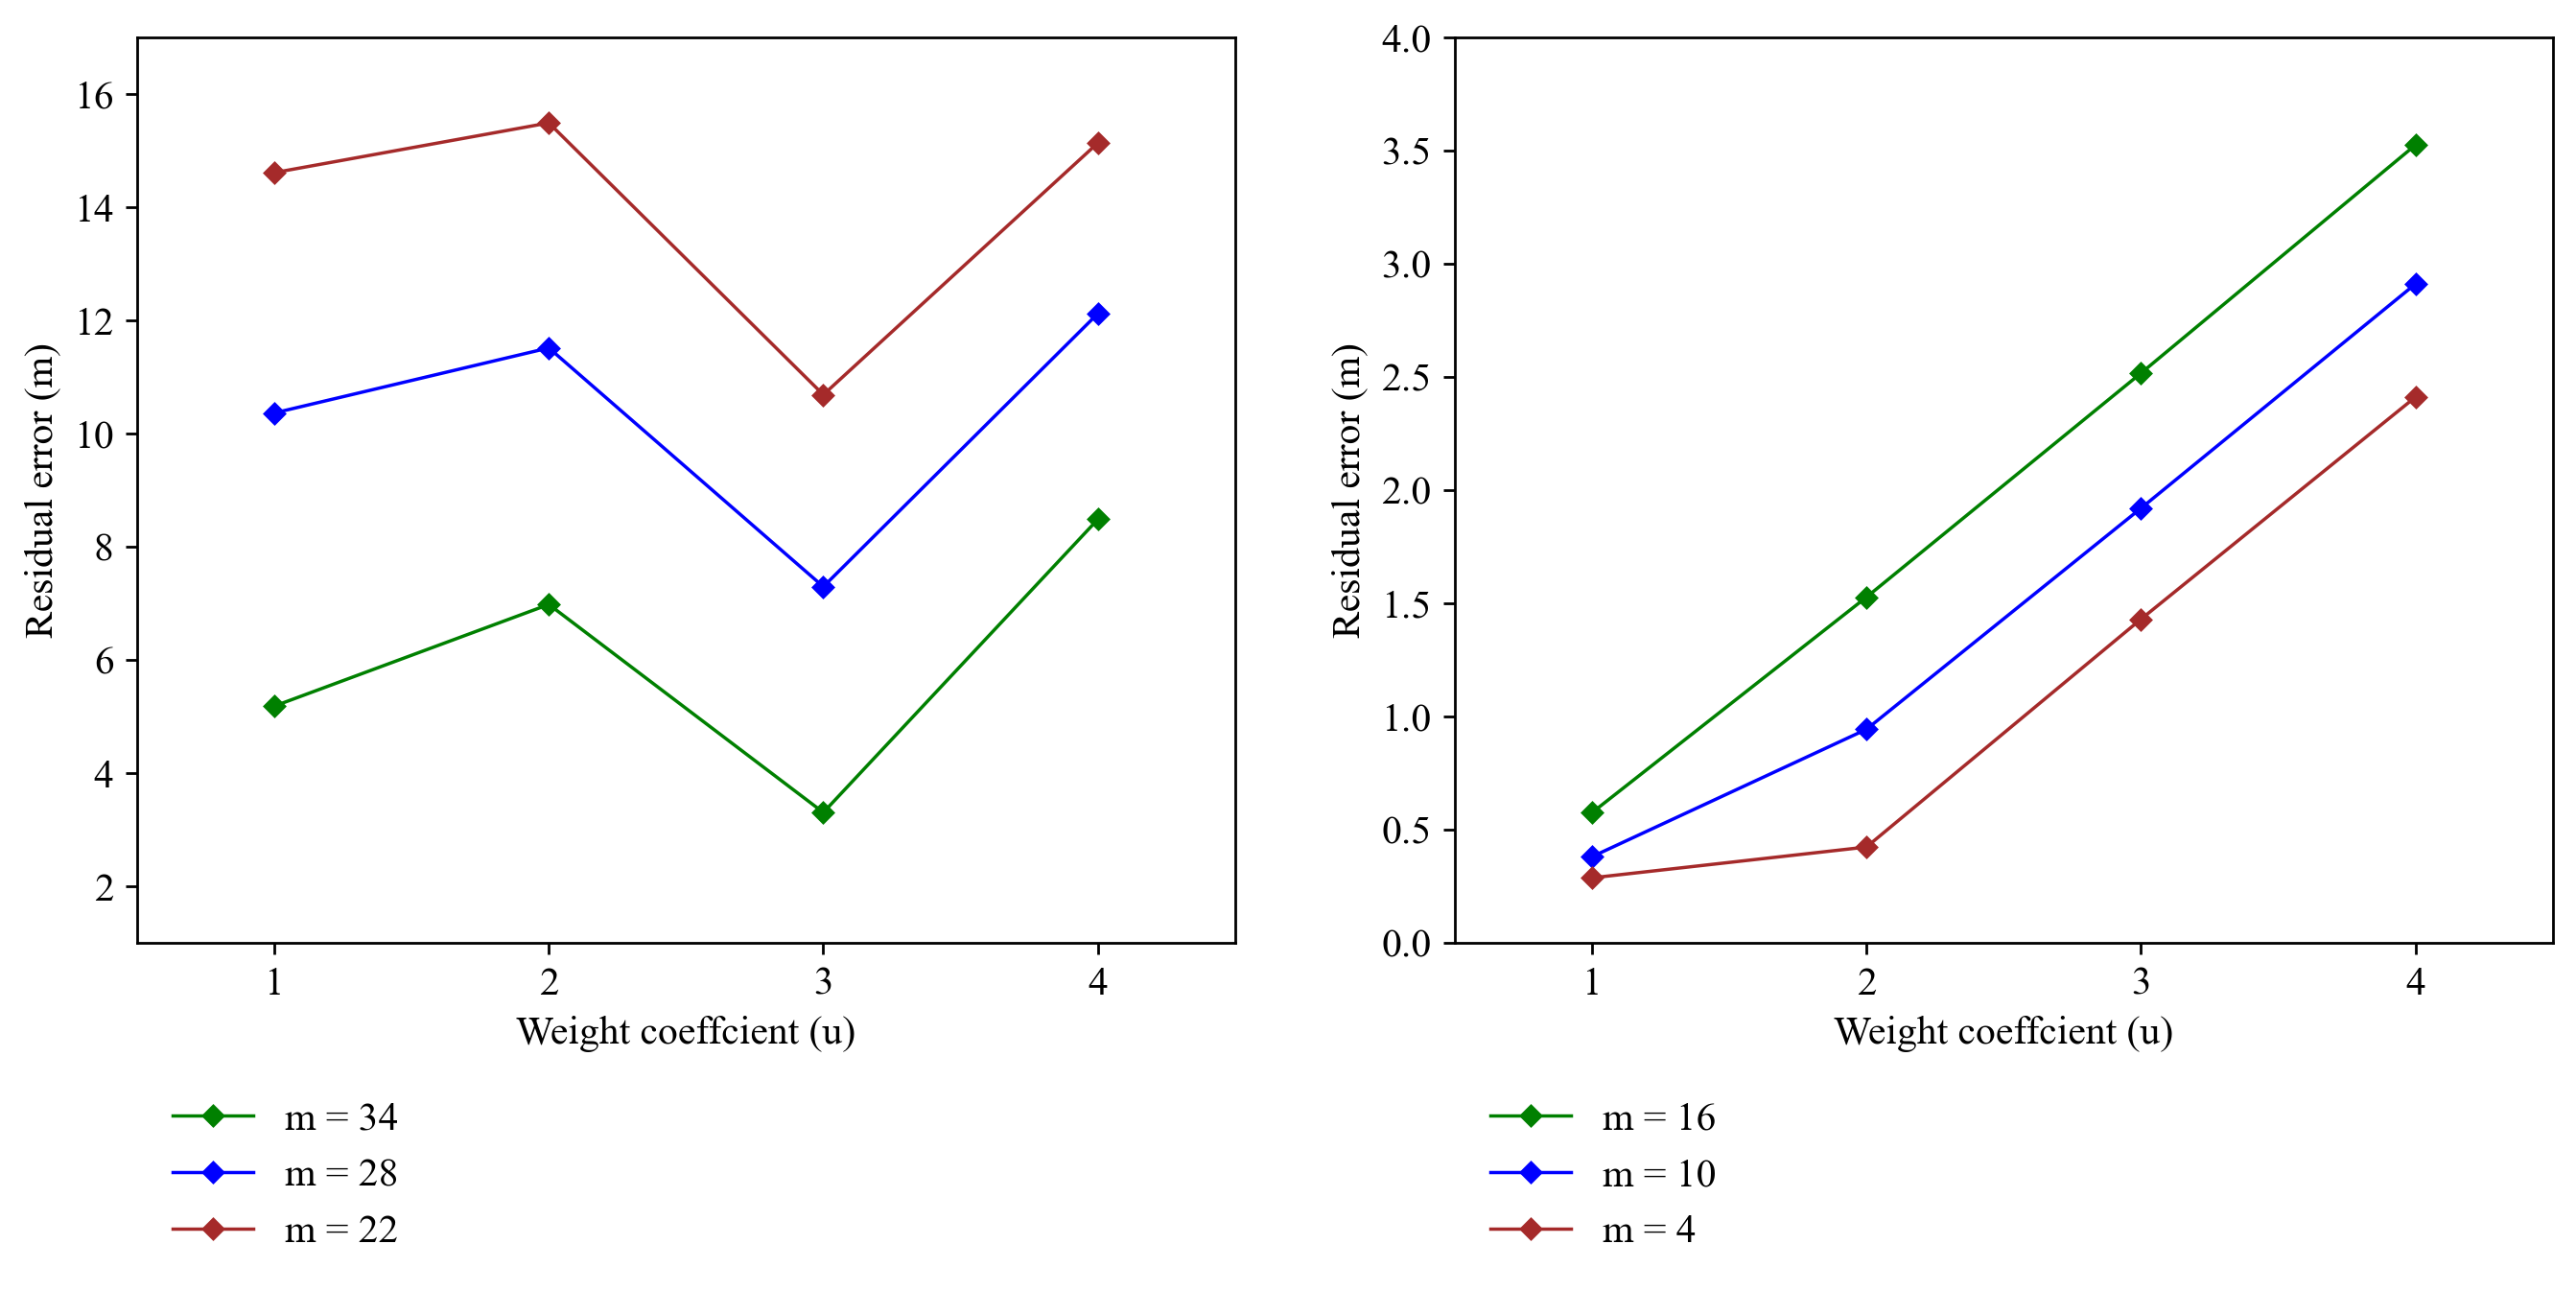

In [2]:
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt 
from matplotlib.pyplot import MultipleLocator
import csv

# 字体格式
config = {
    "font.family":'serif',
    "font.size": 12,
    'font.style':'normal',
    'font.weight':'normal',
    "mathtext.fontset":'cm',
    "font.serif": ['Times New Roman'],
    "axes.unicode_minus": False,
}
plt.rcParams.update(config)
e = {}
e[1] = [0.0, 3.230346, 6.365597, 9.287162]
e[2] = [0.0, -3.511123, -2.150457, 0.765123]
e[3] = [0.0, -0.003001, -0.004572, 0.100655]
e[4] = [0.0, 4.431211, -39.770867, -8.100655]
e[10] = [0.0, 0.430211, 0.300124, 0.200563, 0.100278, 0.060042, 0.030086, 0.020019, 0.010045, 0.006258, -0.005583, 
         -0.005593, -0.005801, -0.006241, -0.008119, -0.016237, -0.019347, -0.020067, -0.020935, -0.021559, -0.023122, 
         -0.026291, -0.028590, -0.0292467, -0.031117, -0.033642, -0.036798, -0.037305, -0.037305, -0.037426, -0.037635, 
         -0.037702, -0.037833, -0.037902, -0.038032, -0.038126, -0.038243, -0.038333, -0.038428, -0.038509, -0.038611]
ua = np.array([1,2,3,4])
alpha = 0.6
beta = 0.001
l = 10 #距离为10m
k = 10.0

# 加载数据文件计算RE
def cal_re_m_u_data(m):
    re = []
    for u in ua:
        # 加载数据
        data = []
        filename = "data/RE_m" + str(m) + "_u" + str(u) + "_data.csv"
        data = np.array(pd.read_csv(filename))
        raw = data.shape[0]
        # 创建一个指定维度的二维数组
        delta = []
        for i in range(raw):
            # 不同采样点的距离数组不一样
            if m == 4:
                d = np.array([1,1,1,2]) * l
                wu = []
                for di in range(d.size):
                    floor = math.floor(d[di])
                    wi = alpha*d[di]**(-u*k) + (u/k) + e[k][floor-1] + (d[di]-floor)*(e[k][floor]-e[k][floor-1]) #加e项，小数的时候按比例折算
                    wu.append(wi)
                w = np.array(wu/sum(wu)) # 计算权重
                Zp_ = round(w.dot(data[i,:m].T),3) # 计算估计值
                delta.append(data[i,m] - Zp_) #残差
            elif m == 10:
                d = np.array([math.sqrt(2),1,math.sqrt(2),2,1,1,2,math.sqrt(2),1,math.sqrt(2)]) * l
                wu = []
                for di in range(d.size):
                    floor = math.floor(d[di])
                    wi = alpha*d[di]**(-u*k) + (u/k) + e[k][floor-1] + (d[di]-floor)*(e[k][floor]-e[k][floor-1]) #加e项，小数的时候按比例折算
                    wu.append(wi)
                w = np.array(wu/sum(wu)) # 计算权重
                Zp_ = round(w.dot(data[i,:m].T),3) # 计算估计值
                delta.append(data[i,m] - Zp_) #残差
            elif m == 16:
                # 通过下标计算两点的距离，选点的方式为固定的16个点：(-2,0),(-1,-2~2),(0,-2~2),(1,-2~2),(2,0)
                loc = np.array([[-2,0],[-1,-2],[-1,-1],[-1,0],[-1,1],[-1,2],[0,-2],[0,-1],[0,1],[0,2],[1,-2],[1,-1],[1,0],[1,1],[1,2],[2,0]])
                # 距离数组
                d = []
                for li in range(loc.shape[0]):
                    d.append(math.sqrt((loc[li][0])**2 + (loc[li][1])**2)*l)
                d = np.array(d)
                wu = []
                for di in range(d.size):
                    floor = math.floor(d[di])
                    wi = alpha*d[di]**(-u*k) + (u/k) + e[k][floor-1] + (d[di]-floor)*(e[k][floor]-e[k][floor-1]) #加e项，小数的时候按比例折算
                    wu.append(wi)
                w = np.array(wu/sum(wu)) # 计算权重
                Zp_ = round(w.dot(data[i,:m].T),3) # 计算估计值
                delta.append(data[i,m] - Zp_) #残差
            elif m == 22:
                loc = np.array([[-2,-2],[-2,-1],[-2,0],[-2,1],[-1,-2],[-1,-1],[-1,0],[-1,1],[-1,2],[0,-2],[0,-1],[0,1],[0,2],[1,-2],[1,-1],[1,0],[1,1],[1,2],[2,-1],[2,0],[2,1],[2,2]])
                # 距离数组
                d = []
                for li in range(loc.shape[0]):
                    d.append(math.sqrt((loc[li][0])**2 + (loc[li][1])**2)*l)
                d = np.array(d)
                wu = []
                for di in range(d.size):
                    floor = math.floor(d[di])
                    wi = alpha*d[di]**(-u*k) + (u/k) + e[k][floor-1] + (d[di]-floor)*(e[k][floor]-e[k][floor-1]) #加e项，小数的时候按比例折算
                    wu.append(wi)
                w = np.array(wu/sum(wu)) # 计算权重
                Zp_ = round(w.dot(data[i,:m].T),3) # 计算估计值
                delta.append(data[i,m] - Zp_) #残差
            elif m == 28:
                loc = np.array([[-3,0],[-2,-2],[-2,-1],[-2,0],[-2,1],[-2,2],[-1,-2],[-1,-1],[-1,0],[-1,1],[-1,2],[0,-3],[0,-2],[0,-1],[0,1],[0,2],[0,3],[1,-2],[1,-1],[1,0],[1,1],[1,2],[2,-2],[2,-1],[2,0],[2,1],[2,2],[3,0]])
                # 距离数组
                d = []
                for li in range(loc.shape[0]):
                    d.append(math.sqrt((loc[li][0])**2 + (loc[li][1])**2)*l)
                d = np.array(d)
                wu = []
                for di in range(d.size):
                    floor = math.floor(d[di])
                    wi = alpha*d[di]**(-u*k) + (u/k) + e[k][floor-1] + (d[di]-floor)*(e[k][floor]-e[k][floor-1]) #加e项，小数的时候按比例折算
                    wu.append(wi)
                w = np.array(wu/sum(wu)) # 计算权重
                Zp_ = round(w.dot(data[i,:m].T),3) # 计算估计值
                delta.append(data[i,m] - Zp_) #残差
            elif m == 34:
                loc = np.array([[-3,-2],[-3,-1],[-3,0],[-3,1],[-2,-2],[-2,-1],[-2,0],[-2,1],[-2,2],[-1,-2],[-1,-1],[-1,0],[-1,1],[-1,2],[0,-3],[0,-2],[0,-1],[0,1],[0,2],[0,3],[1,-2],[1,-1],[1,0],[1,1],[1,2],[2,-2],[2,-1],[2,0],[2,1],[2,2],[3,-1],[3,0],[3,1],[3,2]])
                # 距离数组
                d = []
                for li in range(loc.shape[0]):
                    d.append(math.sqrt((loc[li][0])**2 + (loc[li][1])**2)*l)
                d = np.array(d)
                wu = []
                for di in range(d.size):
                    floor = math.floor(d[di])
                    wi = alpha*d[di]**(-u*k) + (u/k) + e[k][floor-1] + (d[di]-floor)*(e[k][floor]-e[k][floor-1]) #加e项，小数的时候按比例折算
                    wu.append(wi)
                w = np.array(wu/sum(wu)) # 计算权重
                Zp_ = round(w.dot(data[i,:m].T),3) # 计算估计值
                delta.append(data[i,m] - Zp_) #残差
    
        # 计算error数据
        delta = np.array(delta)
        p = sum(delta) / raw
        error = math.sqrt(sum(abs(delta - p)**2)/(raw-1))
        re.append(error)
    # 返回结果数据
    return re

# 加载数据文件计算误差
RE_m4 = np.array(cal_re_m_u_data(4)) * 10
print("RE_m4", RE_m4)
RE_m10 = np.array(cal_re_m_u_data(10)) * 10
print("RE_m10", RE_m10)
RE_m16 = np.array(cal_re_m_u_data(16)) * 10
print("RE_m16", RE_m16)
RE_m22 = np.array(cal_re_m_u_data(22)) * 10
print("RE_m22", RE_m22)
RE_m28 = np.array(cal_re_m_u_data(28)) * 10
print("RE_m28", RE_m28)
RE_m34 = np.array(cal_re_m_u_data(34)) * 10
print("RE_m34", RE_m34)

# 画图
# 设置横轴轴比例，dpi每个间隔的像素点大小
plt.figure(figsize=(13, 5), dpi=250)
# 第一个图
plt.subplot(121)
x_major_locator=MultipleLocator(1)
#把x轴的刻度间隔设置为1，并存在变量里
y_major_locator=MultipleLocator(2)
#把y轴的刻度间隔设置为10，并存在变量里
ax=plt.gca()
#ax为两条坐标轴的实例
ax.xaxis.set_major_locator(x_major_locator)
#把x轴的主刻度设置为1的倍数
ax.yaxis.set_major_locator(y_major_locator)
#把y轴的主刻度设置为10的倍数
plt.xlabel('Weight coeffcient (u)') 
plt.ylabel('Residual error (m)') 
plt.axis([0.5,4.5,1,17])
plt.plot(ua,RE_m34,label='m = 34',linewidth=1, color='green', marker='D', markersize=4) 
plt.plot(ua,RE_m28,label='m = 28',linewidth=1, color='blue', marker='D', markersize=4) 
plt.plot(ua,RE_m22,label='m = 22',linewidth=1, color='brown', marker='D', markersize=4) 
plt.legend(loc=3, bbox_to_anchor=(0,-0.38), frameon=False)
# 第二个图
plt.subplot(122)
x_major_locator=MultipleLocator(1)
#把x轴的刻度间隔设置为1，并存在变量里
y_major_locator=MultipleLocator(0.5)
#把y轴的刻度间隔设置为10，并存在变量里
ax=plt.gca()
#ax为两条坐标轴的实例
ax.xaxis.set_major_locator(x_major_locator)
#把x轴的主刻度设置为1的倍数
ax.yaxis.set_major_locator(y_major_locator)
#把y轴的主刻度设置为10的倍数
plt.xlabel('Weight coeffcient (u)') 
plt.ylabel('Residual error (m)') 
plt.axis([0.5,4.5,0,4])
plt.plot(ua,RE_m16,label='m = 16',linewidth=1, color='green', marker='D', markersize=4) 
plt.plot(ua,RE_m10,label='m = 10',linewidth=1, color='blue', marker='D', markersize=4) 
plt.plot(ua,RE_m4,label='m = 4',linewidth=1, color='brown', marker='D', markersize=4) 
plt.legend(loc=3, bbox_to_anchor=(0,-0.38), frameon=False)
plt.show() 

RE_m4 [0.28806511 1.12785239 1.48042434 1.65779633]
RE_m10 [0.38136166 0.73257613 0.91151334 1.00327344]
RE_m16 [0.5759361  0.91346227 1.0902816  1.18068965]
RE_m22 [14.61765529 14.63578501 14.64762889 14.65431065]
RE_m28 [10.36942858 10.39543794 10.41182451 10.42090786]
RE_m34 [5.18818128 5.23282333 5.2608906  5.27627473]


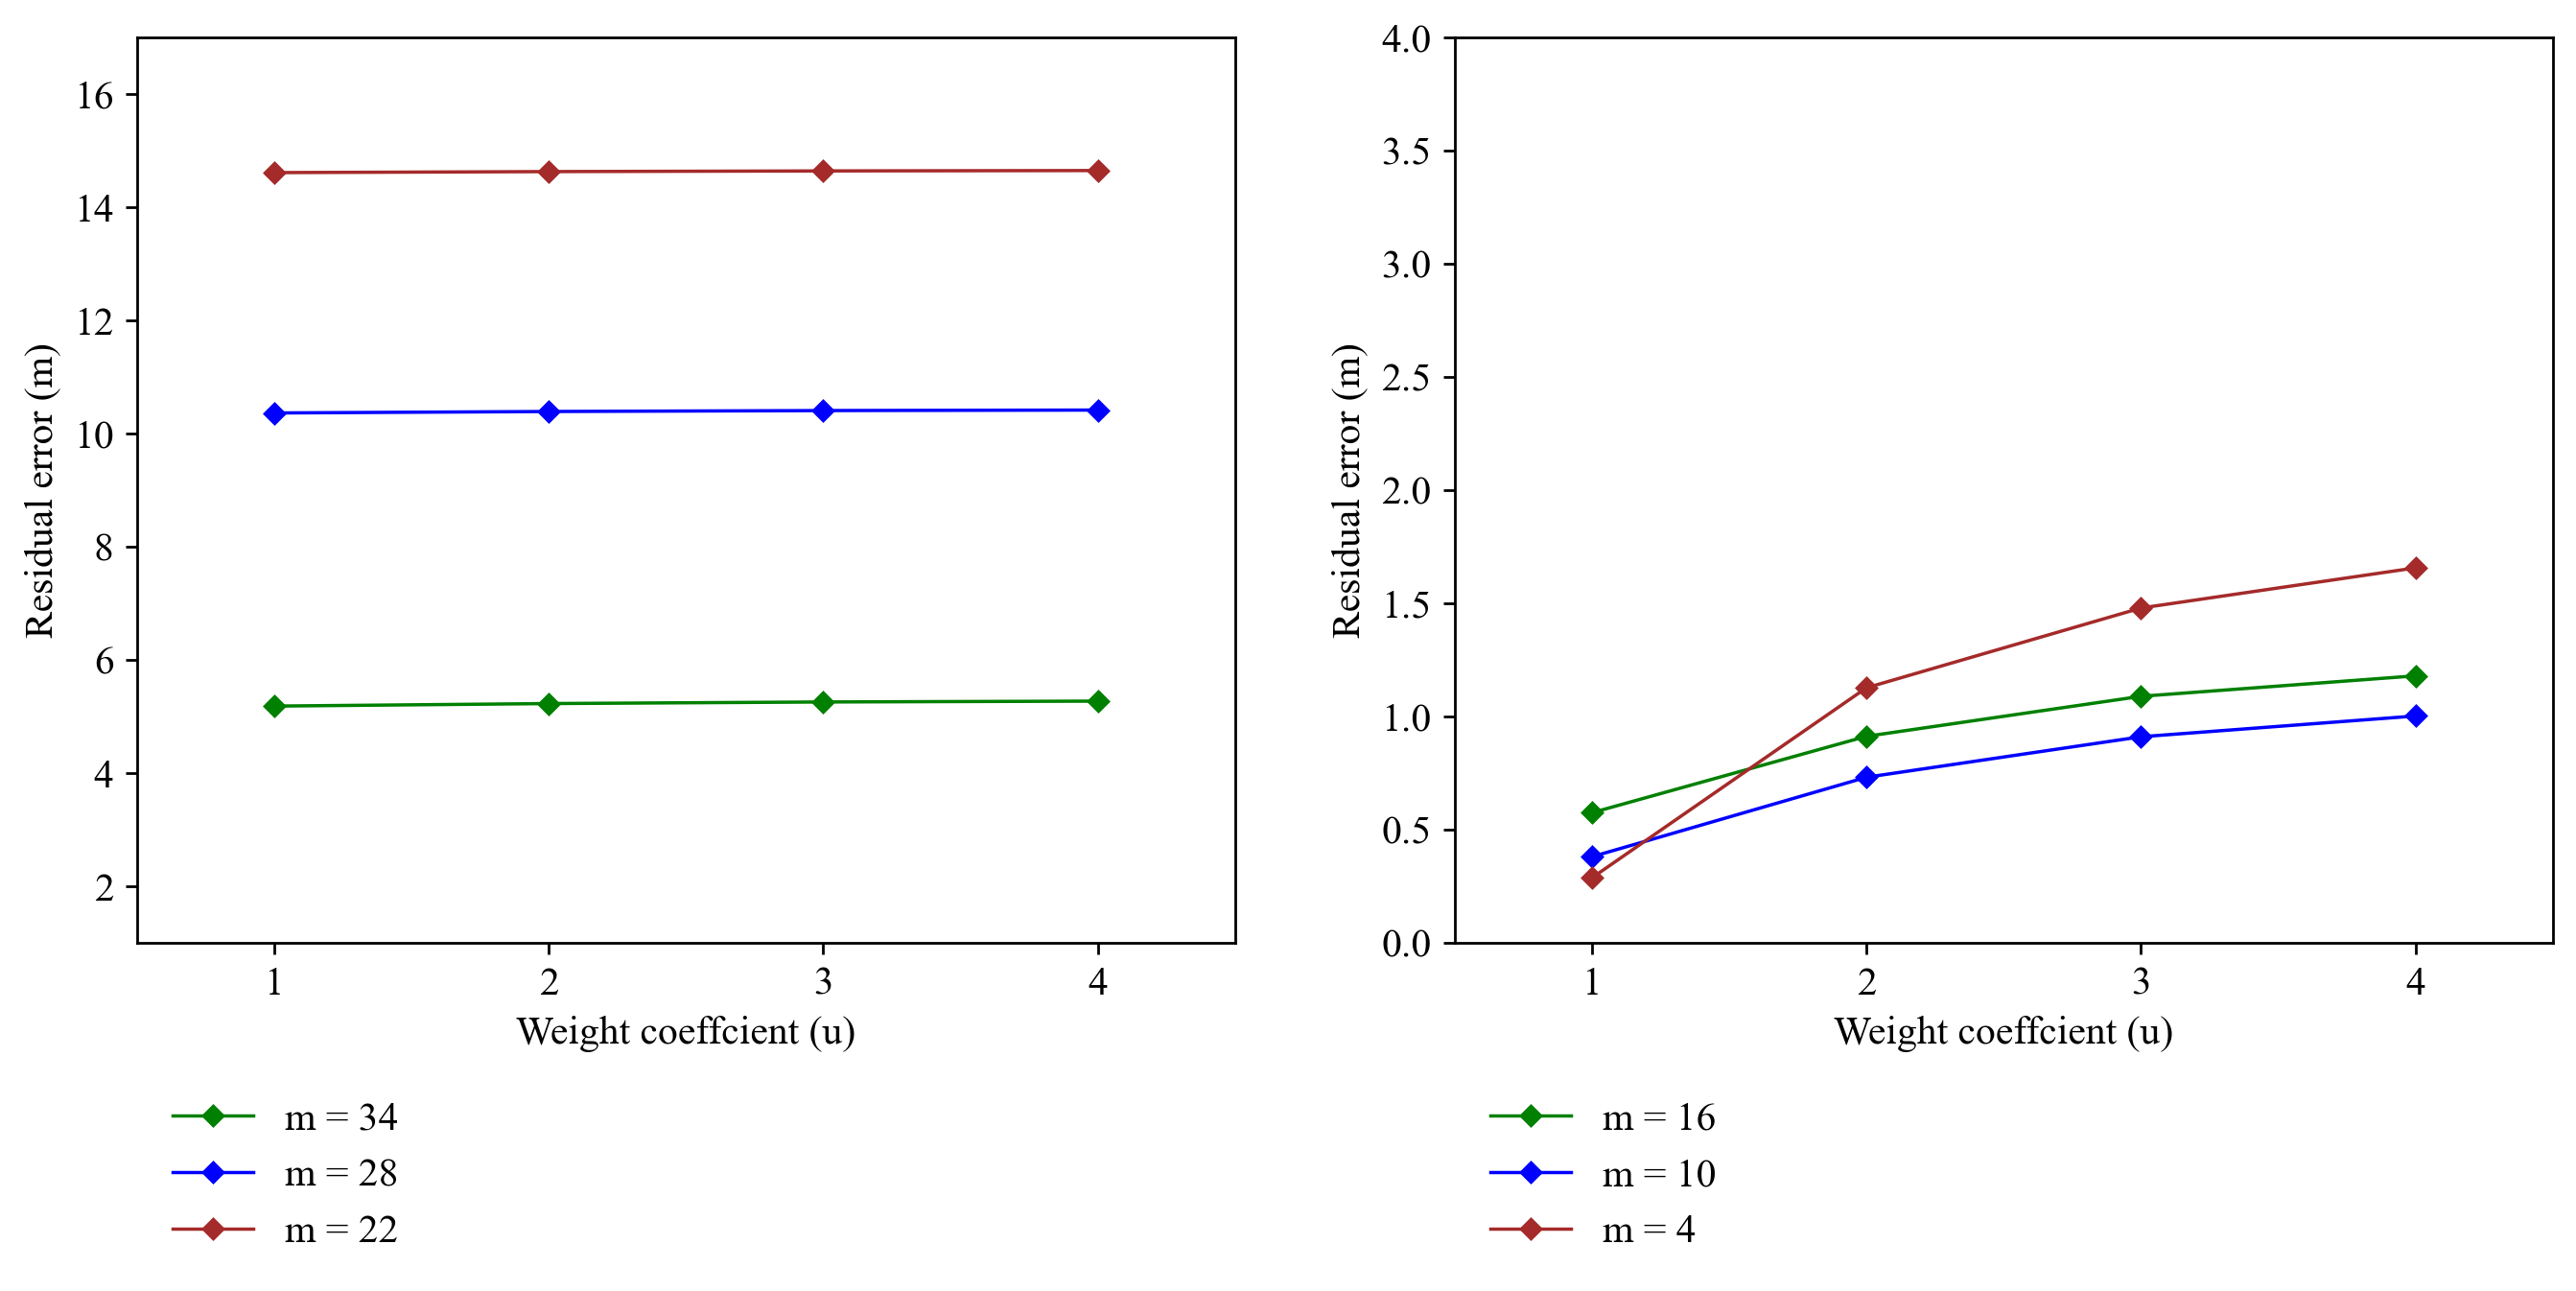

In [2]:
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt 
from matplotlib.pyplot import MultipleLocator
import csv

# 字体格式
config = {
    "font.family":'serif',
    "font.size": 12,
    'font.style':'normal',
    'font.weight':'normal',
    "mathtext.fontset":'cm',
    "font.serif": ['Times New Roman'],
    "axes.unicode_minus": False,
}
plt.rcParams.update(config)
e = {}
e[1] = [0.0, 3.230346, 6.365597, 9.287162]
e[2] = [0.0, -3.511123, -2.150457, 0.765123]
e[3] = [0.0, -0.003001, -0.004572, 0.100655]
e[4] = [0.0, 4.431211, -39.770867, -8.100655]
e[10] = [0.0, 0.430211, 0.300124, 0.200563, 0.100278, 0.060042, 0.030086, 0.020019, 0.010045, 0.006258, -0.005583, 
         -0.005593, -0.005801, -0.006241, -0.008119, -0.016237, -0.019347, -0.020067, -0.020935, -0.021559, -0.023122, 
         -0.026291, -0.028590, -0.0292467, -0.031117, -0.033642, -0.036798, -0.037305, -0.037305, -0.037426, -0.037635, 
         -0.037702, -0.037833, -0.037902, -0.038032, -0.038126, -0.038243, -0.038333, -0.038428, -0.038509, -0.038611]
ua = np.array([1,2,3,4])
alpha = 0.6
beta = 0.001
l = 10 #距离为10m
k = 10.0

# 加载数据文件计算RE
def cal_re_m_u_data(m):
    re = []
    for u in ua:
        # 加载数据
        data = []
        filename = "data/RE_m" + str(m) + "_u1_data.csv"
        data = np.array(pd.read_csv(filename))
        raw = data.shape[0]
        # 创建一个指定维度的二维数组
        delta = []
        for i in range(raw):
            # 不同采样点的距离数组不一样
            if m == 4:
                d = np.array([1,1,1,2]) * l
                wu = []
                for di in range(d.size):
                    floor = math.floor(d[di])
                    wi = alpha*d[di]**(-u*k) + (u/k) + e[k][floor-1] + (d[di]-floor)*(e[k][floor]-e[k][floor-1]) #加e项，小数的时候按比例折算
                    wu.append(wi)
                w = np.array(wu/sum(wu)) # 计算权重
                Zp_ = round(w.dot(data[i,:m].T),3) # 计算估计值
                delta.append(data[i,m] - Zp_) #残差
            elif m == 10:
                d = np.array([math.sqrt(2),1,math.sqrt(2),2,1,1,2,math.sqrt(2),1,math.sqrt(2)]) * l
                wu = []
                for di in range(d.size):
                    floor = math.floor(d[di])
                    wi = alpha*d[di]**(-u*k) + (u/k) + e[k][floor-1] + (d[di]-floor)*(e[k][floor]-e[k][floor-1]) #加e项，小数的时候按比例折算
                    wu.append(wi)
                w = np.array(wu/sum(wu)) # 计算权重
                Zp_ = round(w.dot(data[i,:m].T),3) # 计算估计值
                delta.append(data[i,m] - Zp_) #残差
            elif m == 16:
                # 通过下标计算两点的距离，选点的方式为固定的16个点：(-2,0),(-1,-2~2),(0,-2~2),(1,-2~2),(2,0)
                loc = np.array([[-2,0],[-1,-2],[-1,-1],[-1,0],[-1,1],[-1,2],[0,-2],[0,-1],[0,1],[0,2],[1,-2],[1,-1],[1,0],[1,1],[1,2],[2,0]])
                # 距离数组
                d = []
                for li in range(loc.shape[0]):
                    d.append(math.sqrt((loc[li][0])**2 + (loc[li][1])**2)*l)
                d = np.array(d)
                wu = []
                for di in range(d.size):
                    floor = math.floor(d[di])
                    wi = alpha*d[di]**(-u*k) + (u/k) + e[k][floor-1] + (d[di]-floor)*(e[k][floor]-e[k][floor-1]) #加e项，小数的时候按比例折算
                    wu.append(wi)
                w = np.array(wu/sum(wu)) # 计算权重
                Zp_ = round(w.dot(data[i,:m].T),3) # 计算估计值
                delta.append(data[i,m] - Zp_) #残差
            elif m == 22:
                loc = np.array([[-2,-2],[-2,-1],[-2,0],[-2,1],[-1,-2],[-1,-1],[-1,0],[-1,1],[-1,2],[0,-2],[0,-1],[0,1],[0,2],[1,-2],[1,-1],[1,0],[1,1],[1,2],[2,-1],[2,0],[2,1],[2,2]])
                # 距离数组
                d = []
                for li in range(loc.shape[0]):
                    d.append(math.sqrt((loc[li][0])**2 + (loc[li][1])**2)*l)
                d = np.array(d)
                wu = []
                for di in range(d.size):
                    floor = math.floor(d[di])
                    wi = alpha*d[di]**(-u*k) + (u/k) + e[k][floor-1] + (d[di]-floor)*(e[k][floor]-e[k][floor-1]) #加e项，小数的时候按比例折算
                    wu.append(wi)
                w = np.array(wu/sum(wu)) # 计算权重
                Zp_ = round(w.dot(data[i,:m].T),3) # 计算估计值
                delta.append(data[i,m] - Zp_) #残差
            elif m == 28:
                loc = np.array([[-3,0],[-2,-2],[-2,-1],[-2,0],[-2,1],[-2,2],[-1,-2],[-1,-1],[-1,0],[-1,1],[-1,2],[0,-3],[0,-2],[0,-1],[0,1],[0,2],[0,3],[1,-2],[1,-1],[1,0],[1,1],[1,2],[2,-2],[2,-1],[2,0],[2,1],[2,2],[3,0]])
                # 距离数组
                d = []
                for li in range(loc.shape[0]):
                    d.append(math.sqrt((loc[li][0])**2 + (loc[li][1])**2)*l)
                d = np.array(d)
                wu = []
                for di in range(d.size):
                    floor = math.floor(d[di])
                    wi = alpha*d[di]**(-u*k) + (u/k) + e[k][floor-1] + (d[di]-floor)*(e[k][floor]-e[k][floor-1]) #加e项，小数的时候按比例折算
                    wu.append(wi)
                w = np.array(wu/sum(wu)) # 计算权重
                Zp_ = round(w.dot(data[i,:m].T),3) # 计算估计值
                delta.append(data[i,m] - Zp_) #残差
            elif m == 34:
                loc = np.array([[-3,-2],[-3,-1],[-3,0],[-3,1],[-2,-2],[-2,-1],[-2,0],[-2,1],[-2,2],[-1,-2],[-1,-1],[-1,0],[-1,1],[-1,2],[0,-3],[0,-2],[0,-1],[0,1],[0,2],[0,3],[1,-2],[1,-1],[1,0],[1,1],[1,2],[2,-2],[2,-1],[2,0],[2,1],[2,2],[3,-1],[3,0],[3,1],[3,2]])
                # 距离数组
                d = []
                for li in range(loc.shape[0]):
                    d.append(math.sqrt((loc[li][0])**2 + (loc[li][1])**2)*l)
                d = np.array(d)
                wu = []
                for di in range(d.size):
                    floor = math.floor(d[di])
                    wi = alpha*d[di]**(-u*k) + (u/k) + e[k][floor-1] + (d[di]-floor)*(e[k][floor]-e[k][floor-1]) #加e项，小数的时候按比例折算
                    wu.append(wi)
                w = np.array(wu/sum(wu)) # 计算权重
                Zp_ = round(w.dot(data[i,:m].T),3) # 计算估计值
                delta.append(data[i,m] - Zp_) #残差
    
        # 计算error数据
        delta = np.array(delta)
        p = sum(delta) / raw
        error = math.sqrt(sum(abs(delta - p)**2)/(raw-1))
        re.append(error)
    # 返回结果数据
    return re

# 加载数据文件计算误差
RE_m4 = np.array(cal_re_m_u_data(4)) * 10
print("RE_m4", RE_m4)
RE_m10 = np.array(cal_re_m_u_data(10)) * 10
print("RE_m10", RE_m10)
RE_m16 = np.array(cal_re_m_u_data(16)) * 10
print("RE_m16", RE_m16)
RE_m22 = np.array(cal_re_m_u_data(22)) * 10
print("RE_m22", RE_m22)
RE_m28 = np.array(cal_re_m_u_data(28)) * 10
print("RE_m28", RE_m28)
RE_m34 = np.array(cal_re_m_u_data(34)) * 10
print("RE_m34", RE_m34)

# 画图
# 设置横轴轴比例，dpi每个间隔的像素点大小
plt.figure(figsize=(13, 5), dpi=250)
# 第一个图
plt.subplot(121)
x_major_locator=MultipleLocator(1)
#把x轴的刻度间隔设置为1，并存在变量里
y_major_locator=MultipleLocator(2)
#把y轴的刻度间隔设置为10，并存在变量里
ax=plt.gca()
#ax为两条坐标轴的实例
ax.xaxis.set_major_locator(x_major_locator)
#把x轴的主刻度设置为1的倍数
ax.yaxis.set_major_locator(y_major_locator)
#把y轴的主刻度设置为10的倍数
plt.xlabel('Weight coeffcient (u)') 
plt.ylabel('Residual error (m)') 
plt.axis([0.5,4.5,1,17])
plt.plot(ua,RE_m34,label='m = 34',linewidth=1, color='green', marker='D', markersize=4) 
plt.plot(ua,RE_m28,label='m = 28',linewidth=1, color='blue', marker='D', markersize=4) 
plt.plot(ua,RE_m22,label='m = 22',linewidth=1, color='brown', marker='D', markersize=4) 
plt.legend(loc=3, bbox_to_anchor=(0,-0.38), frameon=False)
# 第二个图
plt.subplot(122)
x_major_locator=MultipleLocator(1)
#把x轴的刻度间隔设置为1，并存在变量里
y_major_locator=MultipleLocator(0.5)
#把y轴的刻度间隔设置为10，并存在变量里
ax=plt.gca()
#ax为两条坐标轴的实例
ax.xaxis.set_major_locator(x_major_locator)
#把x轴的主刻度设置为1的倍数
ax.yaxis.set_major_locator(y_major_locator)
#把y轴的主刻度设置为10的倍数
plt.xlabel('Weight coeffcient (u)') 
plt.ylabel('Residual error (m)') 
plt.axis([0.5,4.5,0,4])
plt.plot(ua,RE_m16,label='m = 16',linewidth=1, color='green', marker='D', markersize=4) 
plt.plot(ua,RE_m10,label='m = 10',linewidth=1, color='blue', marker='D', markersize=4) 
plt.plot(ua,RE_m4,label='m = 4',linewidth=1, color='brown', marker='D', markersize=4) 
plt.legend(loc=3, bbox_to_anchor=(0,-0.38), frameon=False)
plt.show() 

**Histogram of rersiduals**

残差直方图

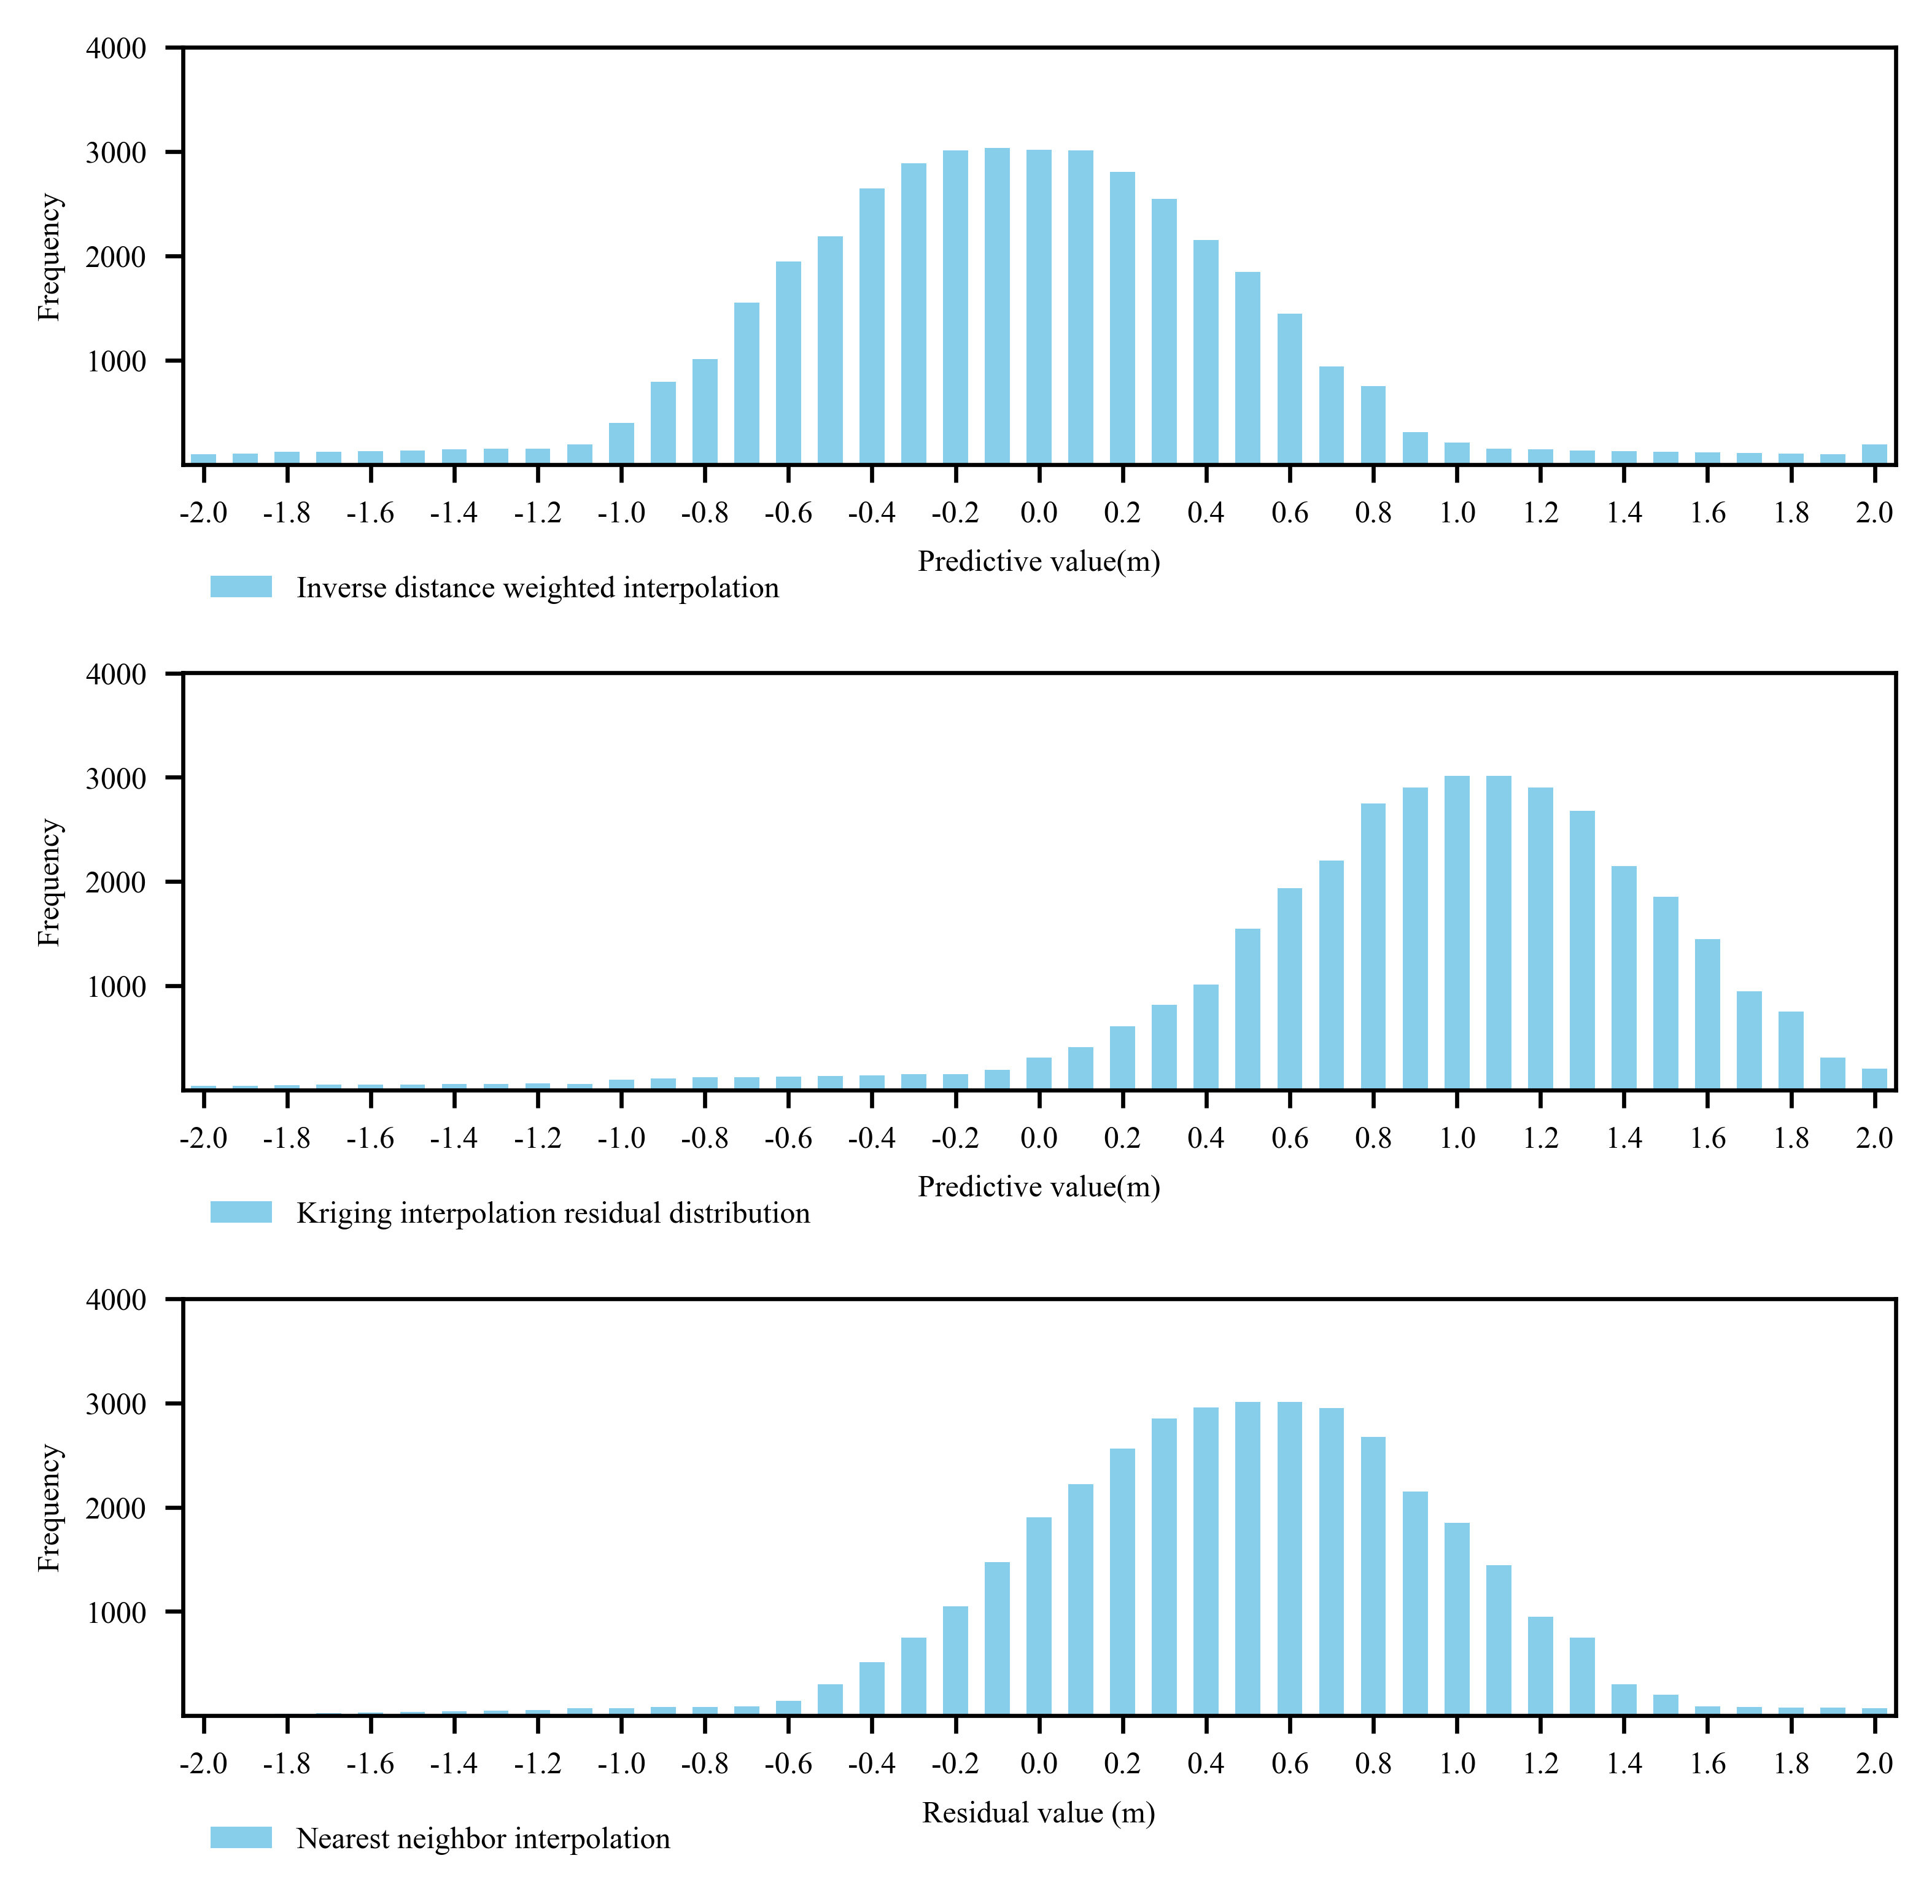

In [7]:
import csv
import numpy as np
import random
import matplotlib.pyplot as plt

# 字体格式
config = {
    "font.family":'serif',
    "font.size": 6,
    'font.style':'normal',
    'font.weight':'normal',
    "mathtext.fontset":'cm',
    "font.serif": ['Times New Roman'],
    "axes.unicode_minus": False,
}
plt.rcParams.update(config)

# 残差的范围
limit = np.array([-2,-1.9,-1.8,-1.7,-1.6,-1.5,-1.4,-1.3,-1.2,-1.1,
                  -1.0,-0.9,-0.8,-0.7,-0.6,-0.5,-0.4,-0.3,-0.2,-0.1,0,
                  0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0,
                  1.1,1.2,1.3,1.4,1.5,1.6,1.7,1.8,1.9,2.0])
# 加载数据绘制直方图
# histogram_of_inverse_residuals
i_data = []
filename = 'data/histogram_of_inverse_residuals.csv'
with open(filename) as f:
    reader = csv.reader(f)
    header_row = next(reader)
    for row in reader:
        i_data.append(float(row[0]))
i_data.sort()
i_data = np.array(i_data)
# histogram_of_kriging_residuals
k_data = []
filename = 'data/histogram_of_kriging_residuals.csv'
with open(filename) as f:
    reader = csv.reader(f)
    header_row = next(reader)
    for row in reader:
        k_data.append(float(row[0]))
k_data.sort()
k_data = np.array(k_data)
# histogram_of_nearest_residuals
n_data = []
filename = 'data/histogram_of_nearest_residuals.csv'
with open(filename) as f:
    reader = csv.reader(f)
    header_row = next(reader)
    for row in reader:
        n_data.append(float(row[0]))
n_data.sort()
n_data = np.array(n_data)

# 统计数量
i_freq = np.zeros(limit.size)
k_freq = np.zeros(limit.size)
n_freq = np.zeros(limit.size)
# 判定值的范围并计数
for i in range(limit.size):
    i_freq[i] = np.array((np.where((i_data < limit[i]+0.05) & (i_data >= limit[i]-0.05)))[0].size)
    k_freq[i] = np.array((np.where((k_data < limit[i]+0.05) & (k_data >= limit[i]-0.05)))[0].size)
    n_freq[i] = np.array((np.where((n_data < limit[i]+0.05) & (n_data >= limit[i]-0.05)))[0].size)

# print(i_freq, k_freq, n_freq)

# 根据MAE调整数量freq
MAE_i = abs(limit).dot(i_freq.T)/sum(i_freq)
MAE_k = abs(limit).dot(k_freq.T)/sum(k_freq)
MAE_n = abs(limit).dot(n_freq.T)/sum(n_freq)
#print(MAE_i, MAE_k, MAE_n)

RMSE_i = math.sqrt((limit*limit).dot(i_freq.T)/sum(i_freq))
RMSE_k = math.sqrt((limit*limit).dot(k_freq.T)/sum(k_freq))
RMSE_n = math.sqrt((limit*limit).dot(n_freq.T)/sum(n_freq))
#print(RMSE_i, RMSE_k, RMSE_n)

# 计算各个方法的偏差
# 设置横轴轴比例，dpi每个间隔的像素点大小
plt.figure(figsize=(6, 6), dpi=600)
# 第一个图
ax = plt.subplot(311)
ax.bar(x=limit, height=i_freq, label='Inverse distance weighted interpolation', color="#87CEEB", width=0.06, align="center")
# 添加x轴和y轴标签
plt.xlabel('Predictive value(m)')
plt.ylabel('Frequency')
x_major_locator = MultipleLocator(0.2)
y_major_locator = MultipleLocator(1000)
#ax为两条坐标轴的实例
ax = plt.gca()
ax.xaxis.set_major_locator(x_major_locator)
ax.yaxis.set_major_locator(y_major_locator)
plt.axis([-2.05,2.05,1, 4001])
plt.legend(loc=3, bbox_to_anchor=(0,-0.4), frameon=False)
# 第二个图
ax = plt.subplot(312)
ax.bar(x=limit, height=k_freq, label='Kriging interpolation residual distribution', color="#87CEEB", width=0.06, align="center")
# 添加x轴和y轴标签
plt.xlabel('Predictive value(m)')
plt.ylabel('Frequency')
x_major_locator = MultipleLocator(0.2)
y_major_locator = MultipleLocator(1000)
#ax为两条坐标轴的实例
ax = plt.gca()
ax.xaxis.set_major_locator(x_major_locator)
ax.yaxis.set_major_locator(y_major_locator)
plt.axis([-2.05,2.05,1, 4001])
plt.legend(loc=3, bbox_to_anchor=(0,-0.4), frameon=False)
# 第三个图
ax = plt.subplot(313)
ax.bar(x=limit, height=n_freq, label='Nearest neighbor interpolation', color="#87CEEB", width=0.06, align="center")
# 添加x轴和y轴标签
plt.xlabel('Residual value (m)')
plt.ylabel('Frequency')
x_major_locator = MultipleLocator(0.2)
y_major_locator = MultipleLocator(1000)
#ax为两条坐标轴的实例
ax = plt.gca()
ax.xaxis.set_major_locator(x_major_locator)
ax.yaxis.set_major_locator(y_major_locator)
plt.axis([-2.05,2.05,1, 4001])
plt.legend(loc=3, bbox_to_anchor=(0,-0.4), frameon=False)
# 调整间隔
plt.subplots_adjust(hspace = 0.5)
# 显示图形
plt.show()


**Results of search points in the plain experimental area**

平原实验区搜索点结果

RE_c0 [0.80425467 0.62159152 0.45409502 0.53605319 0.45344551 0.49524016
 0.5786761 ]
RE_c60 [1.52648255 1.14017679 1.13613531 0.94870875 1.1341511  0.94709693
 1.13267263]
RE_c100 [2.22105711 1.62038735 1.57557574 1.28382663 1.43112156 1.47935922
 1.62448984]
RE_c600 [2.90458231 2.11592171 2.06834474 2.00984658 1.92154949 2.07714109
 2.51525878]
RE_c1000 [3.52650306 2.61162844 2.41683925 2.26665926 2.21380969 2.51605575
 3.00652512]


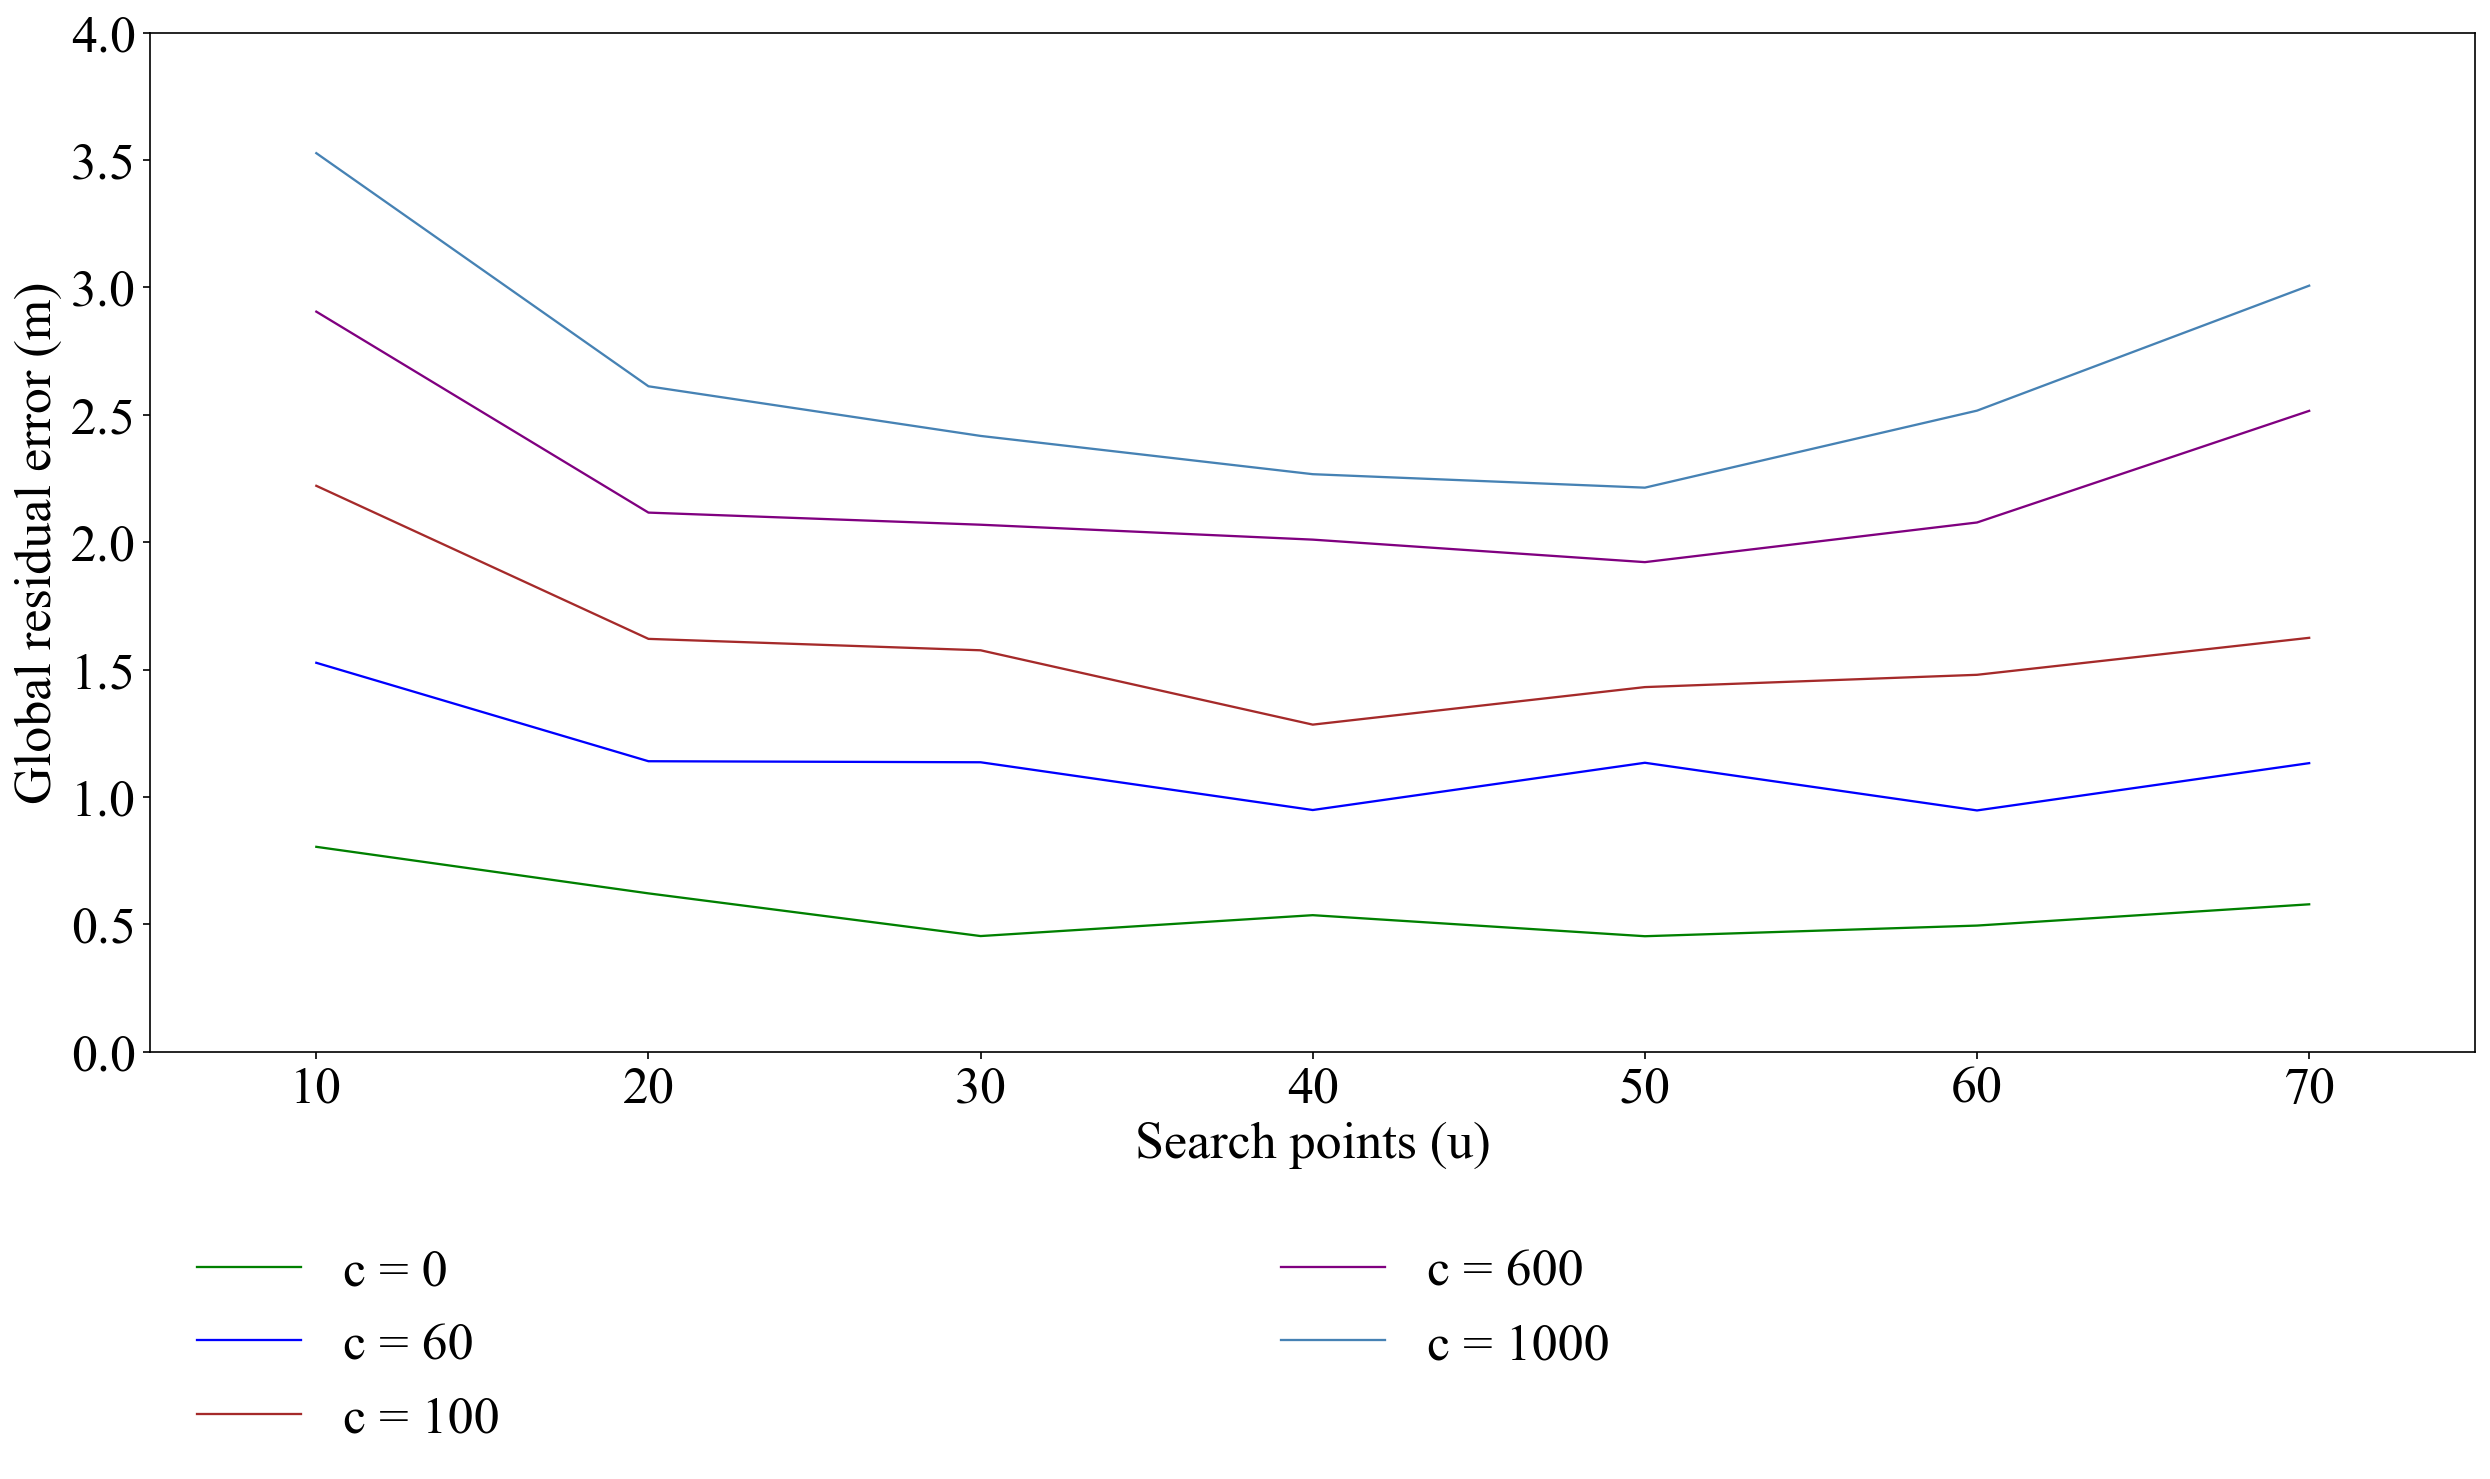

In [6]:
import csv
from matplotlib import pyplot as plt
from matplotlib.pyplot import MultipleLocator
import numpy as np

# 字体格式
config = {
    "font.family":'serif',
    "font.size": 25,
    'font.style':'normal',
    'font.weight':'normal',
    "mathtext.fontset":'cm',
    "font.serif": ['Times New Roman'],
    "axes.unicode_minus": False,
}
plt.rcParams.update(config)

e = {}
e[1] = [0.0, 3.230346, 6.365597, 9.287162]
e[2] = [0.0, -3.511123, -2.150457, 0.765123]
e[3] = [0.0, -0.003001, -0.004572, 0.100655]
e[4] = [0.0, 4.431211, -39.770867, -8.100655]
e[10] = [0.0, 0.430211, 0.300124, 0.200563, 0.100278, 0.060042, 0.030086, 0.020019, 0.010045, 0.006258, -0.005583, 
         -0.005593, -0.005801, -0.006241, -0.008119, -0.016237, -0.019347, -0.020067, -0.020935, -0.021559, -0.023122, 
         -0.026291, -0.028590, -0.0292467, -0.031117, -0.033642, -0.036798, -0.037305, -0.037305, -0.037426, -0.037635, 
         -0.037702, -0.037833, -0.037902, -0.038032, -0.038126, -0.038243, -0.038333, -0.038428, -0.038509, -0.038611,
         -0.038708, -0.038791, -0.038875, -0.038963, -0.039041, -0.039132, -0.039220, -0.039307, -0.039392, -0.039485]
u = 1
alpha = 0.6
beta = 0.001
l = 10
k = 10.0
cmap = {0:0.9,60:0.95,100:1,600:1.05,1000:1.1}
SP = [10, 20, 30, 40 , 50, 60, 70]
carray = np.array([0,60,100,600,1000])

# 加载数据文件计算RE
def cal_plain_re_m_c_data(c):
    re = []
    for m in SP:
        # 加载数据
        data = []
        filename = "data/plain_RE_m" + str(m) + "_c" + str(c) + "_data.csv"
        data = np.array(pd.read_csv(filename))
        raw = data.shape[0]
        # 创建一个指定维度的二维数组
        delta = []
        for i in range(raw):
            # 不同采样点的距离数组不一样
            if m == 10:
                d = np.array([math.sqrt(2),1,math.sqrt(2),2,1,1,2,math.sqrt(2),1,math.sqrt(2)]) * l
                wu = []
                for di in range(d.size):
                    floor = math.floor(d[di])
                    wi = cmap[c]*(alpha*d[di]**(-u*k) + (u/k) + e[k][floor-1] + (d[di]-floor)*(e[k][floor]-e[k][floor-1])) #加e项，小数的时候按比例折算
                    wu.append(wi)
                w = np.array(wu/sum(wu)) # 计算权重
                Zp_ = round(w.dot(data[i,:m].T),3) # 计算估计值
                delta.append(data[i,m] - Zp_) #残差
            elif m == 20:
                loc = np.array([[-2,-1],[-2,0],[-2,1],[-1,-2],[-1,-1],[-1,0],[-1,1],[-1,2],[0,-2],[0,-1],[0,1],[0,2],[1,-2],[1,-1],[1,0],[1,1],[1,2],[2,-1],[2,0],[2,1]])
                # 距离数组
                d = []
                for li in range(loc.shape[0]):
                    d.append(math.sqrt((loc[li][0])**2 + (loc[li][1])**2)*l)
                d = np.array(d)
                wu = []
                for di in range(d.size):
                    floor = math.floor(d[di])
                    wi = cmap[c]*(alpha*d[di]**(-u*k) + (u/k) + e[k][floor-1] + (d[di]-floor)*(e[k][floor]-e[k][floor-1])) #加e项，小数的时候按比例折算
                    wu.append(wi)
                w = np.array(wu/sum(wu)) # 计算权重
                Zp_ = round(w.dot(data[i,:m].T),3) # 计算估计值
                delta.append(data[i,m] - Zp_) #残差
            elif m == 30:
                loc = np.array([[-3,-1],[-3,0],[-2,-2],[-2,-1],[-2,0],[-2,1],[-2,2],[-1,-2],[-1,-1],[-1,0],[-1,1],[-1,2],[0,-3],[0,-2],[0,-1],[0,1],[0,2],[0,3],[1,-2],[1,-1],[1,0],[1,1],[1,2],[2,-2],[2,-1],[2,0],[2,1],[2,2],[3,0],[3,1]])
                # 距离数组
                d = []
                for li in range(loc.shape[0]):
                    d.append(math.sqrt((loc[li][0])**2 + (loc[li][1])**2)*l)
                d = np.array(d)
                wu = []
                for di in range(d.size):
                    floor = math.floor(d[di])
                    wi = cmap[c]*(alpha*d[di]**(-u*k) + (u/k) + e[k][floor-1] + (d[di]-floor)*(e[k][floor]-e[k][floor-1])) #加e项，小数的时候按比例折算
                    wu.append(wi)
                w = np.array(wu/sum(wu)) # 计算权重
                Zp_ = round(w.dot(data[i,:m].T),3) # 计算估计值
                delta.append(data[i,m] - Zp_) #残差
            elif m == 40:
                loc = np.array([[-3,-2],[-3,-1],[-3,0],[-3,1],[-3,2],[-2,-2],[-2,-1],[-2,0],[-2,1],[-2,2],[-1,-3],[-1,-2],[-1,-1],[-1,0],[-1,1],[-1,2],[-1,3],[0,-3],[0,-2],[0,-1],[0,1],[0,2],[0,3],[1,-3],[1,-2],[1,-1],[1,0],[1,1],[1,2],[1,3],[2,-2],[2,-1],[2,0],[2,1],[2,2],[3,-2],[3,-1],[3,0],[3,1],[3,2]])
                # 距离数组
                d = []
                for li in range(loc.shape[0]):
                    d.append(math.sqrt((loc[li][0])**2 + (loc[li][1])**2)*l)
                d = np.array(d)
                wu = []
                for di in range(d.size):
                    floor = math.floor(d[di])
                    wi = cmap[c]*(alpha*d[di]**(-u*k) + (u/k) + e[k][floor-1] + (d[di]-floor)*(e[k][floor]-e[k][floor-1])) #加e项，小数的时候按比例折算
                    wu.append(wi)
                w = np.array(wu/sum(wu)) # 计算权重
                Zp_ = round(w.dot(data[i,:m].T),3) # 计算估计值
                delta.append(data[i,m] - Zp_) #残差
            elif m == 50:
                loc = np.array([[-4,0],[-3,-3],[-3,-2],[-3,-1],[-3,0],[-3,1],[-3,2],[-3,3],[-2,-3],[-2,-2],[-2,-1],[-2,0],[-2,1],[-2,2],[-2,3],[-1,-3],[-1,-2],[-1,-1],[-1,0],[-1,1],[-1,2],[-1,3],[0,-3],[0,-2],[0,-1],[0,1],[0,2],[0,3],[1,-3],[1,-2],[1,-1],[1,0],[1,1],[1,2],[1,3],[2,-3],[2,-2],[2,-1],[2,0],[2,1],[2,2],[2,3],[3,-3],[3,-2],[3,-1],[3,0],[3,1],[3,2],[3,3],[4,0]])
                # 距离数组
                d = []
                for li in range(loc.shape[0]):
                    d.append(math.sqrt((loc[li][0])**2 + (loc[li][1])**2)*l)
                d = np.array(d)
                wu = []
                for di in range(d.size):
                    floor = math.floor(d[di])
                    wi = cmap[c]*(alpha*d[di]**(-u*k) + (u/k) + e[k][floor-1] + (d[di]-floor)*(e[k][floor]-e[k][floor-1])) #加e项，小数的时候按比例折算
                    wu.append(wi)
                w = np.array(wu/sum(wu)) # 计算权重
                Zp_ = round(w.dot(data[i,:m].T),3) # 计算估计值
                delta.append(data[i,m] - Zp_) #残差
            elif m == 60:
                loc = np.array([[-4,-3],[-4,-2],[-4,-1],[-4,0],[-4,1],[-4,2],[-3,-3],[-3,-2],[-3,-1],[-3,0],[-3,1],[-3,2],[-3,3],[-2,-3],[-2,-2],[-2,-1],[-2,0],[-2,1],[-2,2],[-2,3],[-1,-3],[-1,-2],[-1,-1],[-1,0],[-1,1],[-1,2],[-1,3],[0,-3],[0,-2],[0,-1],[0,1],[0,2],[0,3],[1,-3],[1,-2],[1,-1],[1,0],[1,1],[1,2],[1,3],[2,-3],[2,-2],[2,-1],[2,0],[2,1],[2,2],[2,3],[3,-3],[3,-2],[3,-1],[3,0],[3,1],[3,2],[3,3],[4,-2],[4,-1],[4,0],[4,1],[4,2],[4,3]])
                # 距离数组
                d = []
                for li in range(loc.shape[0]):
                    d.append(math.sqrt((loc[li][0])**2 + (loc[li][1])**2)*l)
                d = np.array(d)
                wu = []
                for di in range(d.size):
                    floor = math.floor(d[di])
                    wi = cmap[c]*(alpha*d[di]**(-u*k) + (u/k) + e[k][floor-1] + (d[di]-floor)*(e[k][floor]-e[k][floor-1])) #加e项，小数的时候按比例折算
                    wu.append(wi)
                w = np.array(wu/sum(wu)) # 计算权重
                Zp_ = round(w.dot(data[i,:m].T),3) # 计算估计值
                delta.append(data[i,m] - Zp_) #残差
            elif m == 70:
                loc = np.array([[-4,-3],[-4,-2],[-4,-1],[-4,0],[-4,1],[-4,2],[-3,-3],[-3,-2],[-3,-1],[-3,0],[-3,1],[-3,2],[-3,3],[-2,-4],[-2,-3],[-2,-2],[-2,-1],[-2,0],[-2,1],[-2,2],[-2,3],[-2,-4],[-1,-4],[-1,-3],[-1,-2],[-1,-1],[-1,0],[-1,1],[-1,2],[-1,3],[-1,4],[0,-4],[0,-3],[0,-2],[0,-1],[0,1],[0,2],[0,3],[0,4],[1,-4],[1,-3],[1,-2],[1,-1],[1,0],[1,1],[1,2],[1,3],[1,-4],[2,-4],[2,-3],[2,-2],[2,-1],[2,0],[2,1],[2,2],[2,3],[2,4],[3,-3],[3,-2],[3,-1],[3,0],[3,1],[3,2],[3,3],[4,-2],[4,-1],[4,0],[4,1],[4,2],[4,3]])
                # 距离数组
                d = []
                for li in range(loc.shape[0]):
                    d.append(math.sqrt((loc[li][0])**2 + (loc[li][1])**2)*l)
                d = np.array(d)
                wu = []
                for di in range(d.size):
                    floor = math.floor(d[di])
                    wi = cmap[c]*(alpha*d[di]**(-u*k) + (u/k) + e[k][floor-1] + (d[di]-floor)*(e[k][floor]-e[k][floor-1])) #加e项，小数的时候按比例折算
                    wu.append(wi)
                w = np.array(wu/sum(wu)) # 计算权重
                Zp_ = round(w.dot(data[i,:m].T),3) # 计算估计值
                delta.append(data[i,m] - Zp_) #残差

        # 计算error数据
        delta = np.array(delta)
        p = sum(delta) / raw
        error = math.sqrt(sum(abs(delta - p)**2)/(raw-1))
        re.append(error)
    # 返回结果数据
    return re

# 加载数据文件计算误差
GRE1 = np.array(cal_plain_re_m_c_data(0)) * 10
print("RE_c0", GRE1)
GRE2 = np.array(cal_plain_re_m_c_data(60)) * 10
print("RE_c60", GRE2)
GRE3 = np.array(cal_plain_re_m_c_data(100)) * 10
print("RE_c100", GRE3)
GRE4 = np.array(cal_plain_re_m_c_data(600)) * 10
print("RE_c600", GRE4)
GRE5 = np.array(cal_plain_re_m_c_data(1000)) * 10
print("RE_c1000", GRE5)

plt.figure(figsize=(20, 9), dpi=150)
x_major_locator=MultipleLocator(10)
y_major_locator=MultipleLocator(0.5)
ax=plt.gca()
ax.xaxis.set_major_locator(x_major_locator)
ax.yaxis.set_major_locator(y_major_locator)
plt.xlabel('Search points (u)')
plt.ylabel('Global residual error (m)')
plt.axis([5,75,0,4])
plt.plot(SP, GRE1, label='c = 0', linewidth=1.1, color='green')
plt.plot(SP, GRE2, label='c = 60', linewidth=1.1, color='blue')
plt.plot(SP, GRE3, label='c = 100', linewidth=1.1, color='brown')
plt.plot(SP, GRE4, label='c = 600', linewidth=1.1, color='purple')
plt.plot(SP, GRE5, label='c = 1000', linewidth=1.1, color='steelblue')
plt.legend(loc=3,bbox_to_anchor=(0,-0.43),ncol=2,columnspacing=15,frameon=False)
plt.show()

**Results of search points in the hilly experimental area**

丘陵试验区搜索点结果

RE_c0 [0.75566497 0.61972339 0.49256804 0.38250778 0.57728895 0.56099708
 0.53371823]
RE_c60 [1.43327033 1.11263916 0.85056885 0.83948729 1.04315085 0.94759809
 1.0424186 ]
RE_c100 [2.11426953 1.62728633 1.42905984 1.53233638 1.43316533 1.5485539
 1.60350296]
RE_c600 [2.78074087 2.11870572 2.11979746 2.02424595 1.92454746 2.26510923
 2.125733  ]
RE_c1000 [3.40847688 2.50854808 2.49812854 2.48840338 2.30869817 2.71433802
 2.51591186]


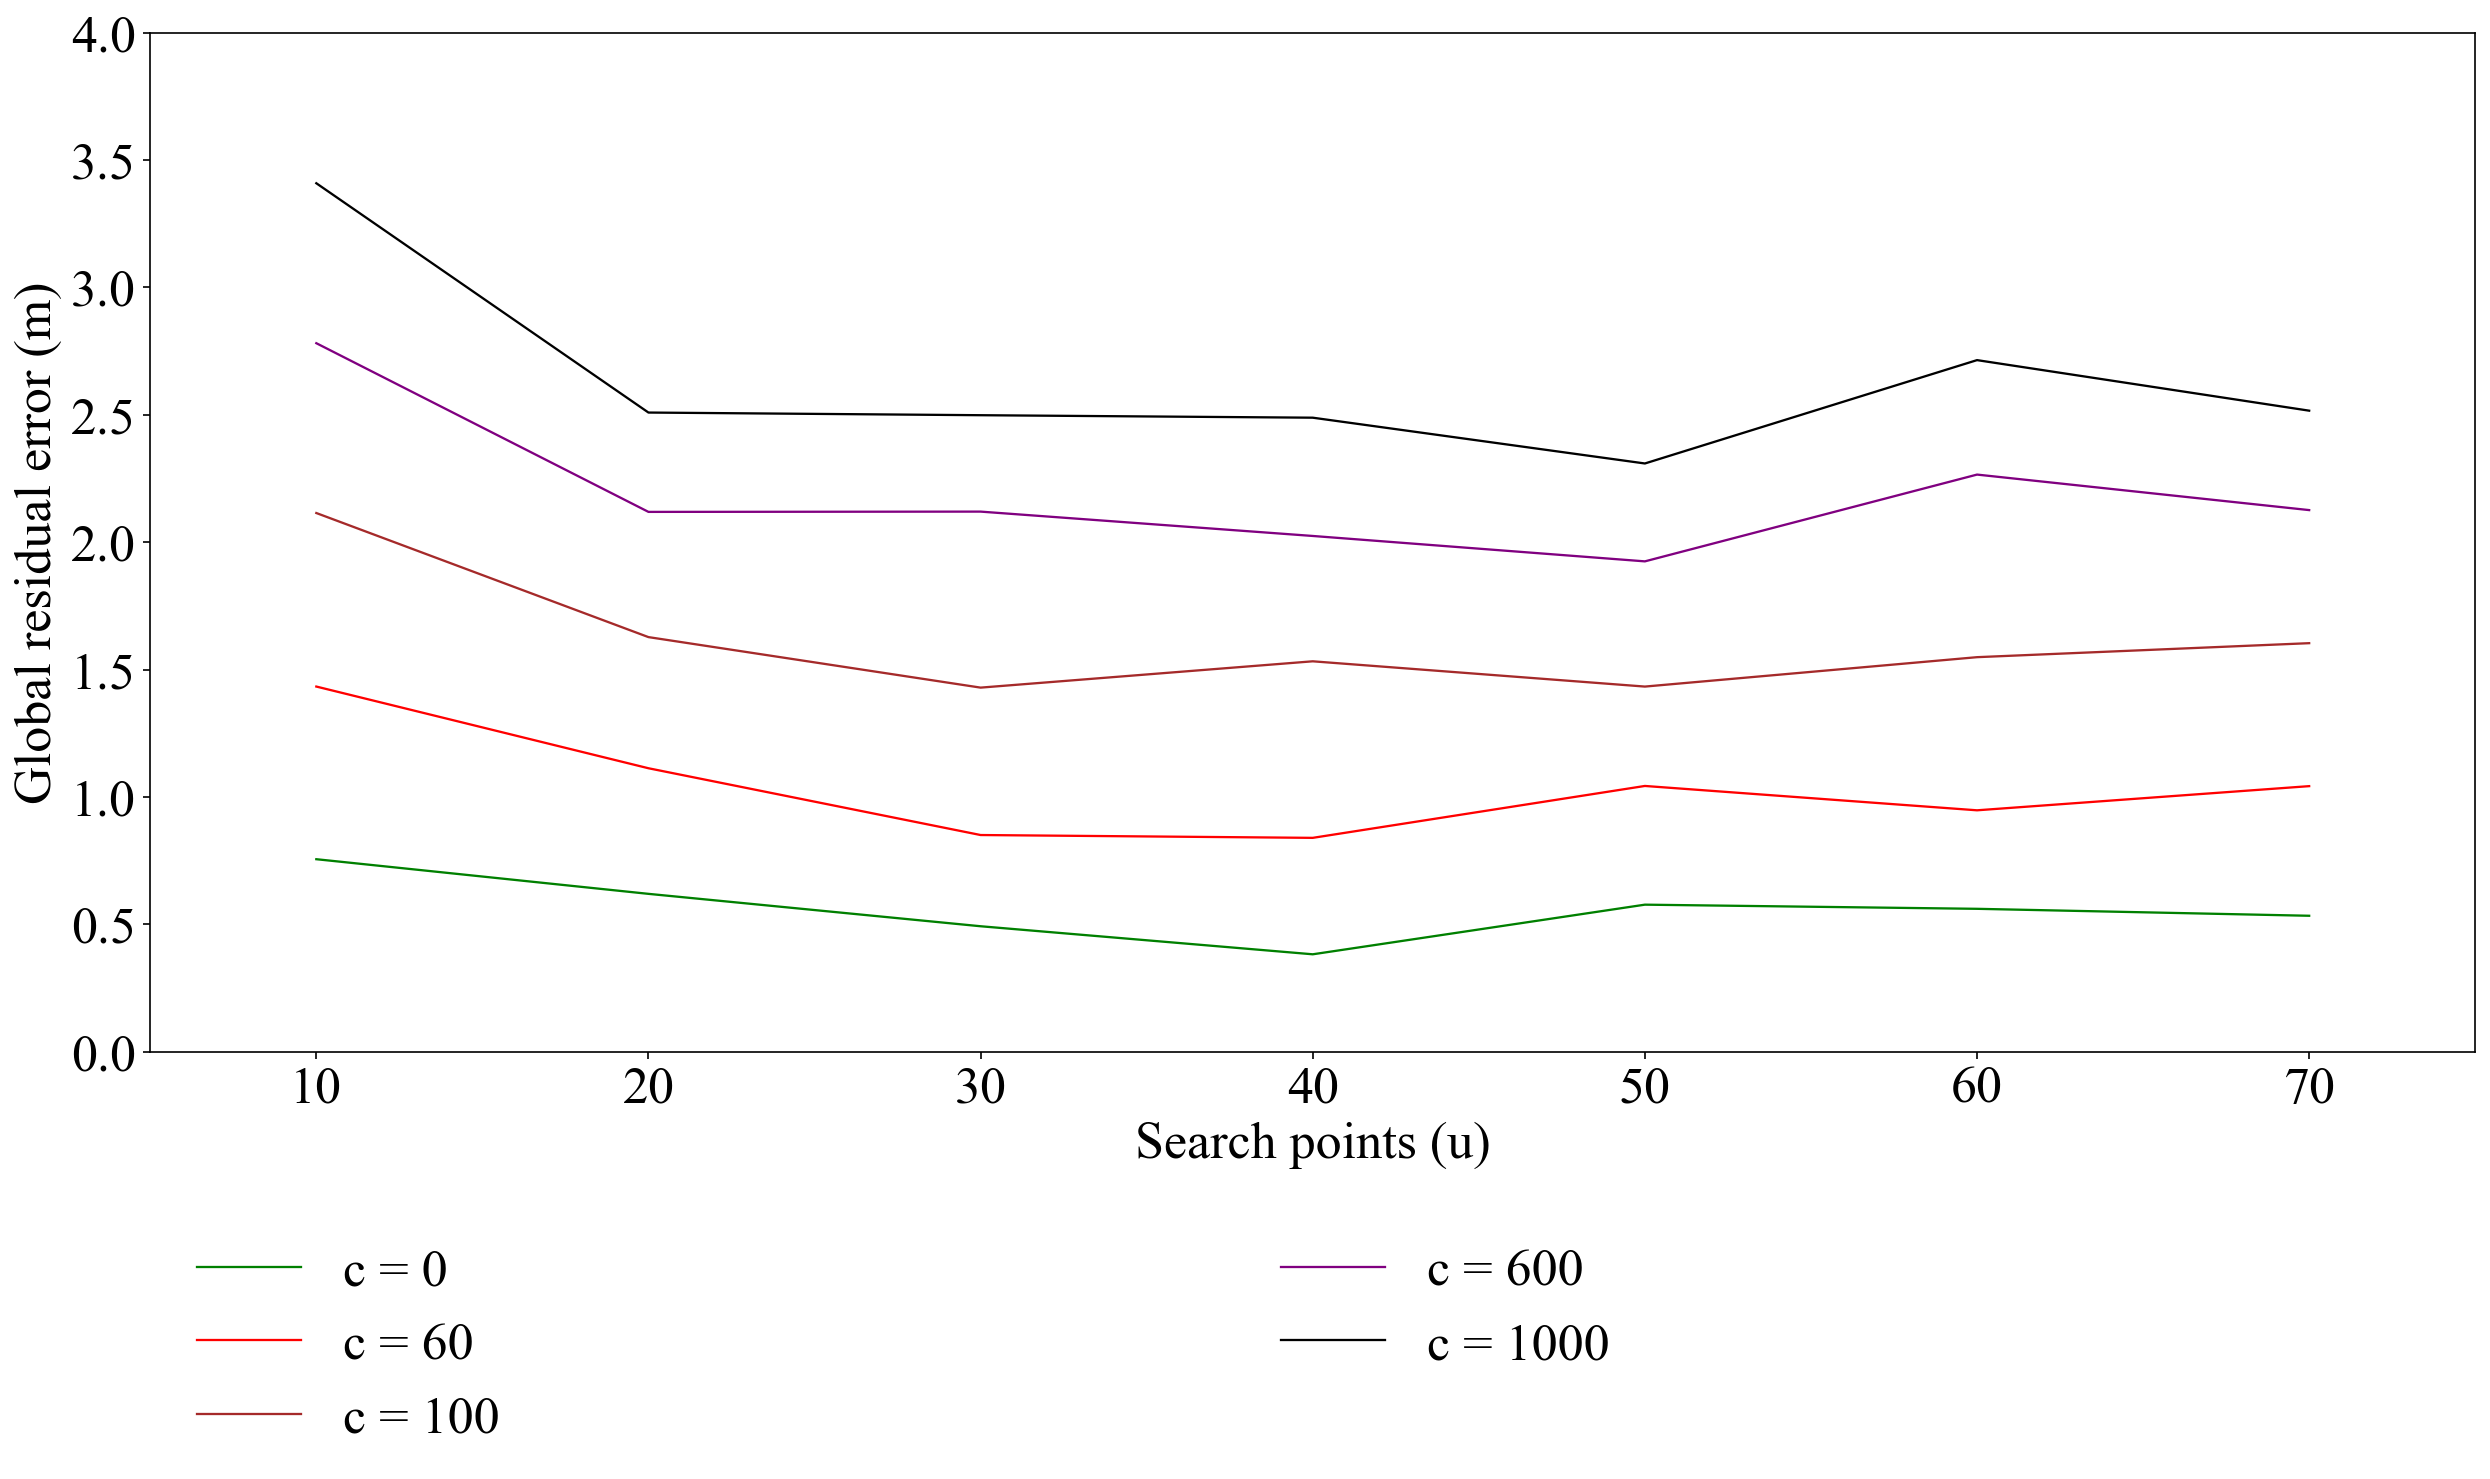

In [5]:
import csv
from matplotlib import pyplot as plt
from matplotlib.pyplot import MultipleLocator

# 字体格式
config = {
    "font.family":'serif',
    "font.size": 25,
    'font.style':'normal',
    'font.weight':'normal',
    "mathtext.fontset":'cm',
    "font.serif": ['Times New Roman'],
    "axes.unicode_minus": False,
}
plt.rcParams.update(config)

e = {}
e[1] = [0.0, 3.230346, 6.365597, 9.287162]
e[2] = [0.0, -3.511123, -2.150457, 0.765123]
e[3] = [0.0, -0.003001, -0.004572, 0.100655]
e[4] = [0.0, 4.431211, -39.770867, -8.100655]
e[10] = [0.0, 0.430211, 0.300124, 0.200563, 0.100278, 0.060042, 0.030086, 0.020019, 0.010045, 0.006258, -0.005583, 
         -0.005593, -0.005801, -0.006241, -0.008119, -0.016237, -0.019347, -0.020067, -0.020935, -0.021559, -0.023122, 
         -0.026291, -0.028590, -0.0292467, -0.031117, -0.033642, -0.036798, -0.037305, -0.037305, -0.037426, -0.037635, 
         -0.037702, -0.037833, -0.037902, -0.038032, -0.038126, -0.038243, -0.038333, -0.038428, -0.038509, -0.038611,
         -0.038708, -0.038791, -0.038875, -0.038963, -0.039041, -0.039132, -0.039220, -0.039307, -0.039392, -0.039485]
u = 1
alpha = 0.6
beta = 0.001
l = 10
k = 10.0
cmap = {0:0.9,60:0.95,100:1,600:1.05,1000:1.1}
SP = [10, 20, 30, 40 , 50, 60, 70]
carray = np.array([0,60,100,600,1000])

# 加载数据文件计算RE
def cal_hilly_re_m_c_data(c):
    re = []
    for m in SP:
        # 加载数据
        data = []
        filename = "data/hilly_RE_m" + str(m) + "_c" + str(c) + "_data.csv"
        data = np.array(pd.read_csv(filename))
        raw = data.shape[0]
        # 创建一个指定维度的二维数组
        delta = []
        for i in range(raw):
            # 不同采样点的距离数组不一样
            if m == 10:
                d = np.array([math.sqrt(2),1,math.sqrt(2),2,1,1,2,math.sqrt(2),1,math.sqrt(2)]) * l
                wu = []
                for di in range(d.size):
                    floor = math.floor(d[di])
                    wi = cmap[c]*(alpha*d[di]**(-u*k) + (u/k) + e[k][floor-1] + (d[di]-floor)*(e[k][floor]-e[k][floor-1])) #加e项，小数的时候按比例折算
                    wu.append(wi)
                w = np.array(wu/sum(wu)) # 计算权重
                Zp_ = round(w.dot(data[i,:m].T),3) # 计算估计值
                delta.append(data[i,m] - Zp_) #残差
            elif m == 20:
                loc = np.array([[-2,-1],[-2,0],[-2,1],[-1,-2],[-1,-1],[-1,0],[-1,1],[-1,2],[0,-2],[0,-1],[0,1],[0,2],[1,-2],[1,-1],[1,0],[1,1],[1,2],[2,-1],[2,0],[2,1]])
                # 距离数组
                d = []
                for li in range(loc.shape[0]):
                    d.append(math.sqrt((loc[li][0])**2 + (loc[li][1])**2)*l)
                d = np.array(d)
                wu = []
                for di in range(d.size):
                    floor = math.floor(d[di])
                    wi = cmap[c]*(alpha*d[di]**(-u*k) + (u/k) + e[k][floor-1] + (d[di]-floor)*(e[k][floor]-e[k][floor-1])) #加e项，小数的时候按比例折算
                    wu.append(wi)
                w = np.array(wu/sum(wu)) # 计算权重
                Zp_ = round(w.dot(data[i,:m].T),3) # 计算估计值
                delta.append(data[i,m] - Zp_) #残差
            elif m == 30:
                loc = np.array([[-3,-1],[-3,0],[-2,-2],[-2,-1],[-2,0],[-2,1],[-2,2],[-1,-2],[-1,-1],[-1,0],[-1,1],[-1,2],[0,-3],[0,-2],[0,-1],[0,1],[0,2],[0,3],[1,-2],[1,-1],[1,0],[1,1],[1,2],[2,-2],[2,-1],[2,0],[2,1],[2,2],[3,0],[3,1]])
                # 距离数组
                d = []
                for li in range(loc.shape[0]):
                    d.append(math.sqrt((loc[li][0])**2 + (loc[li][1])**2)*l)
                d = np.array(d)
                wu = []
                for di in range(d.size):
                    floor = math.floor(d[di])
                    wi = cmap[c]*(alpha*d[di]**(-u*k) + (u/k) + e[k][floor-1] + (d[di]-floor)*(e[k][floor]-e[k][floor-1])) #加e项，小数的时候按比例折算
                    wu.append(wi)
                w = np.array(wu/sum(wu)) # 计算权重
                Zp_ = round(w.dot(data[i,:m].T),3) # 计算估计值
                delta.append(data[i,m] - Zp_) #残差
            elif m == 40:
                loc = np.array([[-3,-2],[-3,-1],[-3,0],[-3,1],[-3,2],[-2,-2],[-2,-1],[-2,0],[-2,1],[-2,2],[-1,-3],[-1,-2],[-1,-1],[-1,0],[-1,1],[-1,2],[-1,3],[0,-3],[0,-2],[0,-1],[0,1],[0,2],[0,3],[1,-3],[1,-2],[1,-1],[1,0],[1,1],[1,2],[1,3],[2,-2],[2,-1],[2,0],[2,1],[2,2],[3,-2],[3,-1],[3,0],[3,1],[3,2]])
                # 距离数组
                d = []
                for li in range(loc.shape[0]):
                    d.append(math.sqrt((loc[li][0])**2 + (loc[li][1])**2)*l)
                d = np.array(d)
                wu = []
                for di in range(d.size):
                    floor = math.floor(d[di])
                    wi = cmap[c]*(alpha*d[di]**(-u*k) + (u/k) + e[k][floor-1] + (d[di]-floor)*(e[k][floor]-e[k][floor-1])) #加e项，小数的时候按比例折算
                    wu.append(wi)
                w = np.array(wu/sum(wu)) # 计算权重
                Zp_ = round(w.dot(data[i,:m].T),3) # 计算估计值
                delta.append(data[i,m] - Zp_) #残差
            elif m == 50:
                loc = np.array([[-4,0],[-3,-3],[-3,-2],[-3,-1],[-3,0],[-3,1],[-3,2],[-3,3],[-2,-3],[-2,-2],[-2,-1],[-2,0],[-2,1],[-2,2],[-2,3],[-1,-3],[-1,-2],[-1,-1],[-1,0],[-1,1],[-1,2],[-1,3],[0,-3],[0,-2],[0,-1],[0,1],[0,2],[0,3],[1,-3],[1,-2],[1,-1],[1,0],[1,1],[1,2],[1,3],[2,-3],[2,-2],[2,-1],[2,0],[2,1],[2,2],[2,3],[3,-3],[3,-2],[3,-1],[3,0],[3,1],[3,2],[3,3],[4,0]])
                # 距离数组
                d = []
                for li in range(loc.shape[0]):
                    d.append(math.sqrt((loc[li][0])**2 + (loc[li][1])**2)*l)
                d = np.array(d)
                wu = []
                for di in range(d.size):
                    floor = math.floor(d[di])
                    wi = cmap[c]*(alpha*d[di]**(-u*k) + (u/k) + e[k][floor-1] + (d[di]-floor)*(e[k][floor]-e[k][floor-1])) #加e项，小数的时候按比例折算
                    wu.append(wi)
                w = np.array(wu/sum(wu)) # 计算权重
                Zp_ = round(w.dot(data[i,:m].T),3) # 计算估计值
                delta.append(data[i,m] - Zp_) #残差
            elif m == 60:
                loc = np.array([[-4,-3],[-4,-2],[-4,-1],[-4,0],[-4,1],[-4,2],[-3,-3],[-3,-2],[-3,-1],[-3,0],[-3,1],[-3,2],[-3,3],[-2,-3],[-2,-2],[-2,-1],[-2,0],[-2,1],[-2,2],[-2,3],[-1,-3],[-1,-2],[-1,-1],[-1,0],[-1,1],[-1,2],[-1,3],[0,-3],[0,-2],[0,-1],[0,1],[0,2],[0,3],[1,-3],[1,-2],[1,-1],[1,0],[1,1],[1,2],[1,3],[2,-3],[2,-2],[2,-1],[2,0],[2,1],[2,2],[2,3],[3,-3],[3,-2],[3,-1],[3,0],[3,1],[3,2],[3,3],[4,-2],[4,-1],[4,0],[4,1],[4,2],[4,3]])
                # 距离数组
                d = []
                for li in range(loc.shape[0]):
                    d.append(math.sqrt((loc[li][0])**2 + (loc[li][1])**2)*l)
                d = np.array(d)
                wu = []
                for di in range(d.size):
                    floor = math.floor(d[di])
                    wi = cmap[c]*(alpha*d[di]**(-u*k) + (u/k) + e[k][floor-1] + (d[di]-floor)*(e[k][floor]-e[k][floor-1])) #加e项，小数的时候按比例折算
                    wu.append(wi)
                w = np.array(wu/sum(wu)) # 计算权重
                Zp_ = round(w.dot(data[i,:m].T),3) # 计算估计值
                delta.append(data[i,m] - Zp_) #残差
            elif m == 70:
                loc = np.array([[-4,-3],[-4,-2],[-4,-1],[-4,0],[-4,1],[-4,2],[-3,-3],[-3,-2],[-3,-1],[-3,0],[-3,1],[-3,2],[-3,3],[-2,-4],[-2,-3],[-2,-2],[-2,-1],[-2,0],[-2,1],[-2,2],[-2,3],[-2,-4],[-1,-4],[-1,-3],[-1,-2],[-1,-1],[-1,0],[-1,1],[-1,2],[-1,3],[-1,4],[0,-4],[0,-3],[0,-2],[0,-1],[0,1],[0,2],[0,3],[0,4],[1,-4],[1,-3],[1,-2],[1,-1],[1,0],[1,1],[1,2],[1,3],[1,-4],[2,-4],[2,-3],[2,-2],[2,-1],[2,0],[2,1],[2,2],[2,3],[2,4],[3,-3],[3,-2],[3,-1],[3,0],[3,1],[3,2],[3,3],[4,-2],[4,-1],[4,0],[4,1],[4,2],[4,3]])
                # 距离数组
                d = []
                for li in range(loc.shape[0]):
                    d.append(math.sqrt((loc[li][0])**2 + (loc[li][1])**2)*l)
                d = np.array(d)
                wu = []
                for di in range(d.size):
                    floor = math.floor(d[di])
                    wi = cmap[c]*(alpha*d[di]**(-u*k) + (u/k) + e[k][floor-1] + (d[di]-floor)*(e[k][floor]-e[k][floor-1])) #加e项，小数的时候按比例折算
                    wu.append(wi)
                w = np.array(wu/sum(wu)) # 计算权重
                Zp_ = round(w.dot(data[i,:m].T),3) # 计算估计值
                delta.append(data[i,m] - Zp_) #残差

        # 计算error数据
        delta = np.array(delta)
        p = sum(delta) / raw
        error = math.sqrt(sum(abs(delta - p)**2)/(raw-1))
        re.append(error)
    # 返回结果数据
    return re

# 加载数据文件计算误差
GRE1 = np.array(cal_hilly_re_m_c_data(0)) * 10
print("RE_c0", GRE1)
GRE2 = np.array(cal_hilly_re_m_c_data(60)) * 10
print("RE_c60", GRE2)
GRE3 = np.array(cal_hilly_re_m_c_data(100)) * 10
print("RE_c100", GRE3)
GRE4 = np.array(cal_hilly_re_m_c_data(600)) * 10
print("RE_c600", GRE4)
GRE5 = np.array(cal_hilly_re_m_c_data(1000)) * 10
print("RE_c1000", GRE5)

plt.figure(figsize=(20, 9), dpi=150)
x_major_locator=MultipleLocator(10)
y_major_locator=MultipleLocator(0.5)
ax=plt.gca()
ax.xaxis.set_major_locator(x_major_locator)
ax.yaxis.set_major_locator(y_major_locator)
plt.xlabel('Search points (u)')
plt.ylabel('Global residual error (m)')
plt.axis([5,75,0,4])
plt.plot(SP, GRE1, label='c = 0', linewidth=1.1, color='green')
plt.plot(SP, GRE2, label='c = 60', linewidth=1.1, color='red')
plt.plot(SP, GRE3, label='c = 100', linewidth=1.1, color='brown')
plt.plot(SP, GRE4, label='c = 600', linewidth=1.1, color='purple')
plt.plot(SP, GRE5, label='c = 1000', linewidth=1.1, color='black')
plt.legend(loc=3,bbox_to_anchor=(0,-0.43),ncol=2,columnspacing=15,frameon=False)
plt.show()

**DEM analysis results of low mountain experimental area**

低山试验区DEM分析结果

RE_H15 [0.49273872 0.75781845 0.49515886 0.51001554 0.46937802 0.41483033
 0.43727881 0.35118488 0.48397225 0.51794859]
RE_H20 [0.9932092  1.4335191  0.80371051 0.75564502 0.84859559 0.80558509
 0.66678164 0.62156783 0.94375507 0.92672794]
RE_H30 [1.41393531 2.12278004 1.18388255 0.94294588 1.24201584 1.18466075
 0.99175239 0.94697129 1.08881776 1.04010398]
RE_H40 [1.87429325 2.76916483 1.52735227 1.40902129 1.60793122 1.6756646
 1.48031441 1.37849649 1.61985492 1.53228992]
RE_H50 [2.26293885 3.42228643 1.96879233 1.99327069 1.9188235  2.01790175
 2.06757321 1.77634931 2.01473781 2.02167344]
ME_c0 [0.0950471  0.13610089 0.12799383 0.08314481 0.08500432]
ME_c200 [0.12079473 0.11100843 0.13694983 0.11989094 0.12593907]
ME_c250 [0.08706712 0.07190874 0.07203644 0.05178675 0.08707173]
ME_c300 [0.17291938 0.13970576 0.14319872 0.19994668 0.13000146]
ME_c350 [0.13504261 0.16997441 0.14501304 0.17200873 0.12013767]
ME_c400 [0.15082798 0.16796524 0.17202962 0.11703002 0.12590484]


C:\Users\CLEARL~1\AppData\Local\Temp/ipykernel_142164/2428541086.py:388: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([15,20,30,40,50,55])


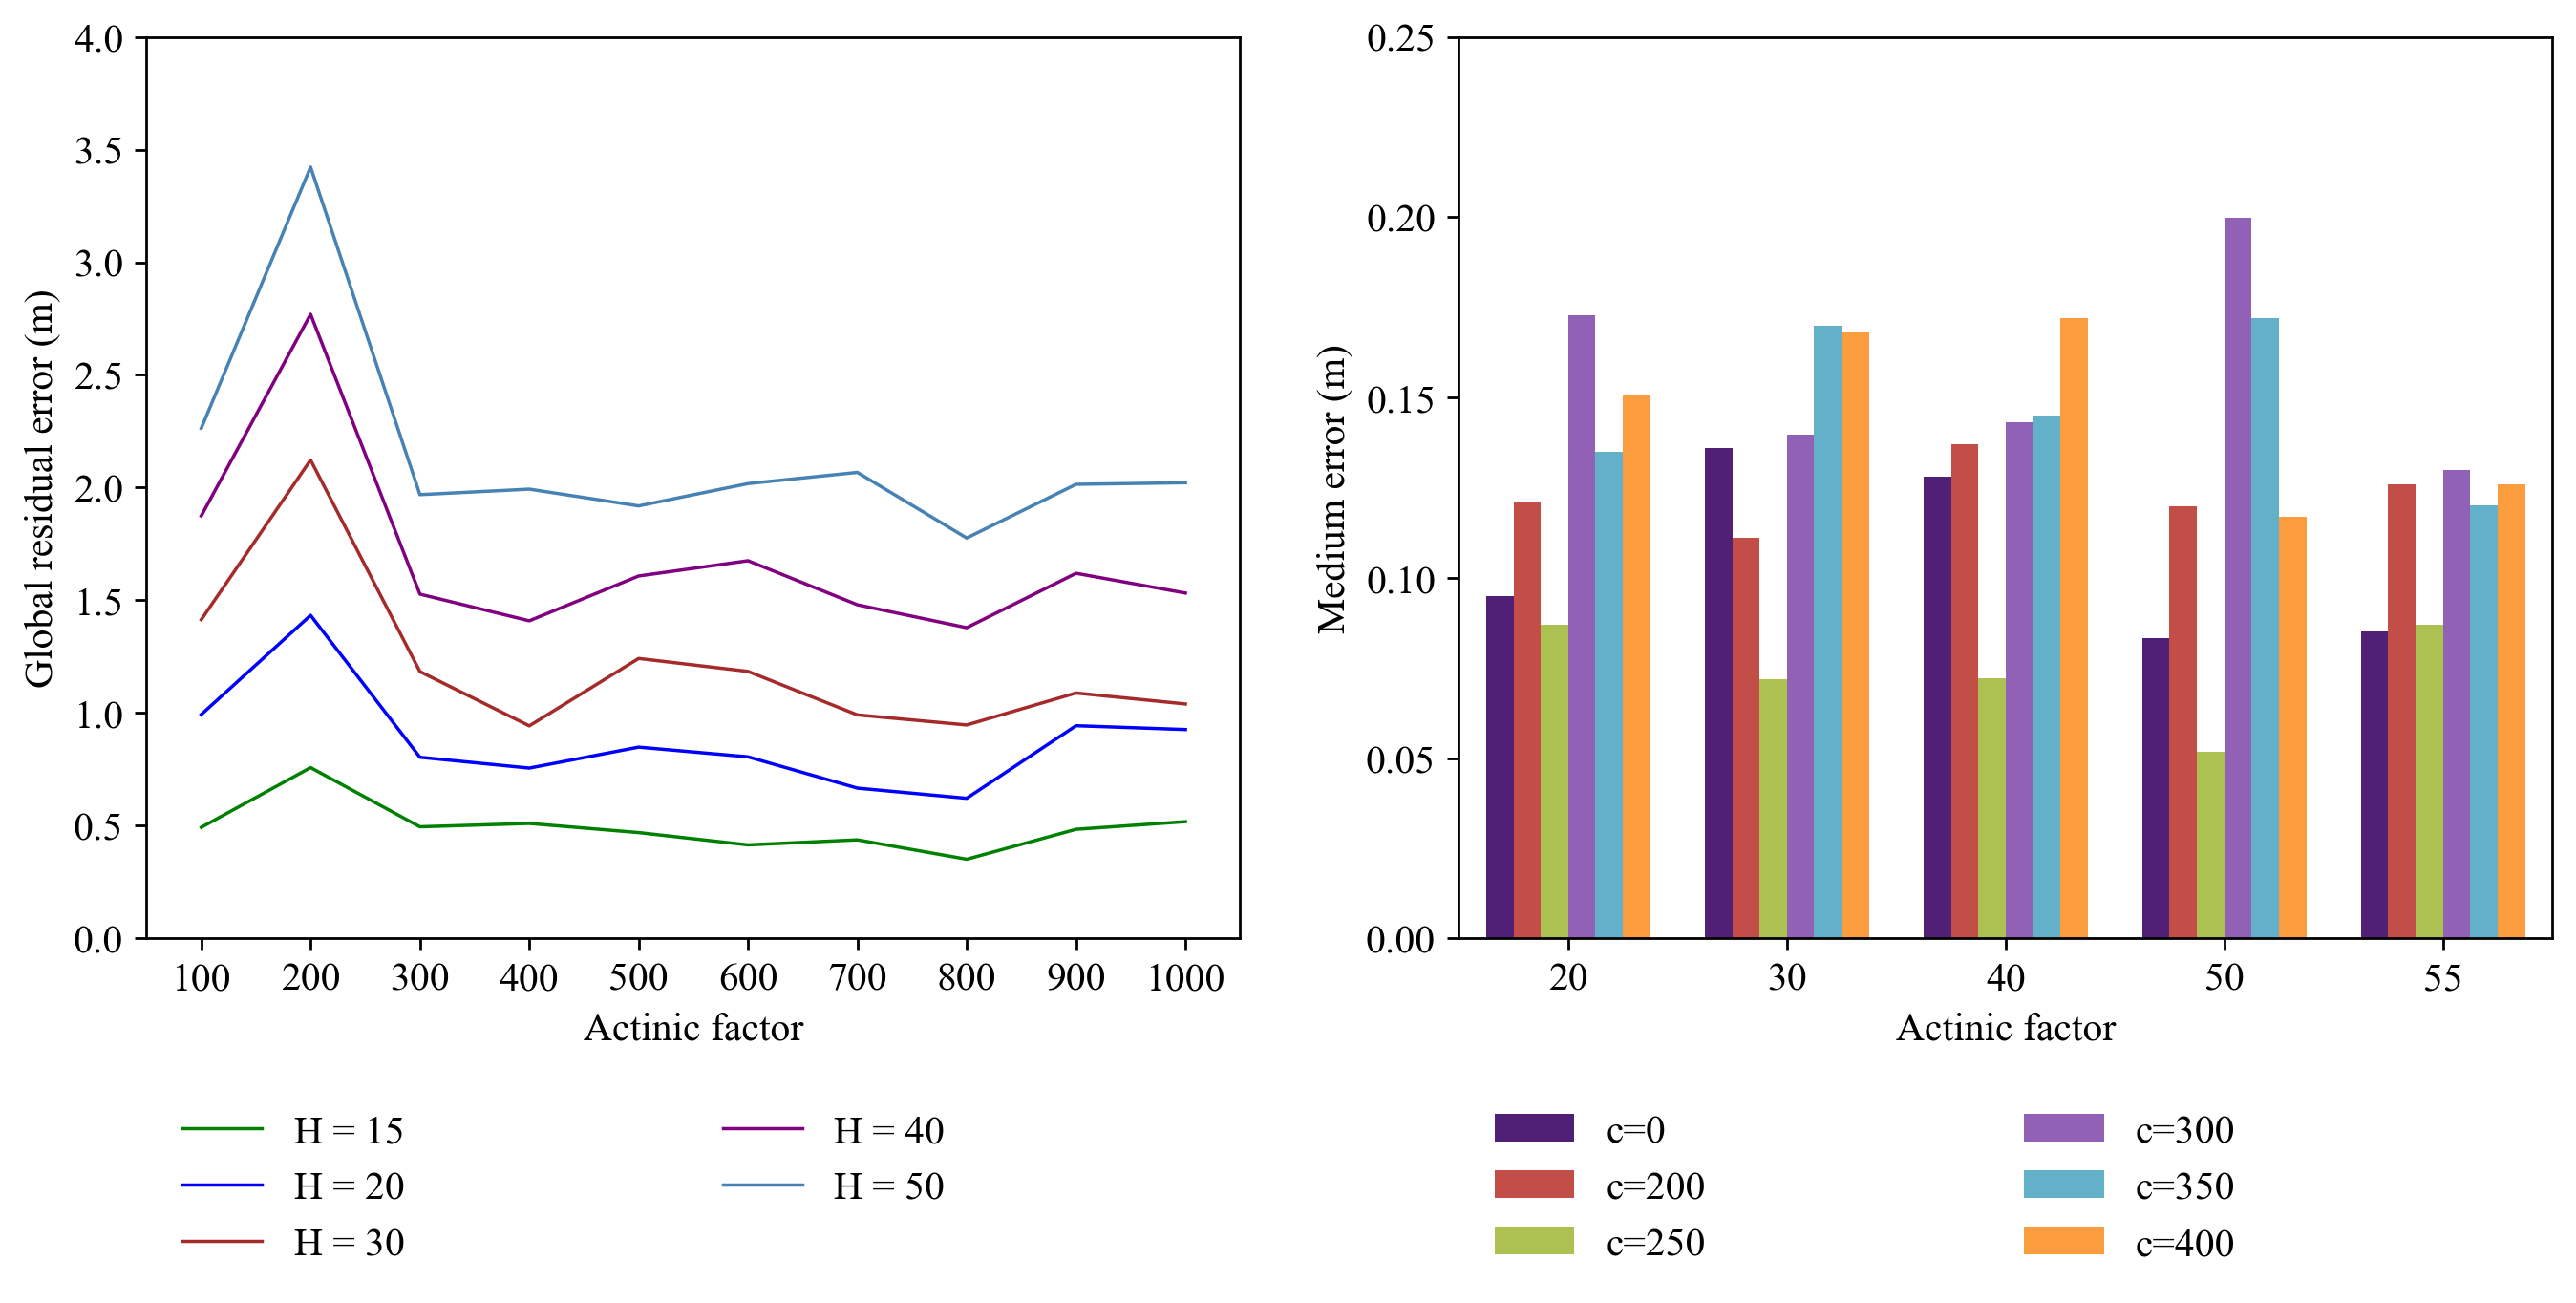

In [1]:
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt 
from matplotlib.pyplot import MultipleLocator

# 字体格式
config = {
    "font.family":'serif',
    "font.size": 12,
    'font.style':'normal',
    'font.weight':'normal',
    "mathtext.fontset":'cm',
    "font.serif": ['Times New Roman'],
    "axes.unicode_minus": False,
}
plt.rcParams.update(config)

# 设置横轴轴比例，dpi每个间隔的像素点大小
plt.figure(figsize=(13, 5), dpi=250)
# 第一个图
plt.subplot(121)

# 参数
e = {}
e[1] = [0.0, 3.230346, 6.365597, 9.287162]
e[2] = [0.0, -3.511123, -2.150457, 0.765123]
e[3] = [0.0, -0.003001, -0.004572, 0.100655]
e[4] = [0.0, 4.431211, -39.770867, -8.100655]
e[10] = [0.0, 0.430211, 0.300124, 0.200563, 0.100278, 0.060042, 0.030086, 0.020019, 0.010045, 0.006258, -0.005583, 
         -0.005593, -0.005801, -0.006241, -0.008119, -0.016237, -0.019347, -0.020067, -0.020935, -0.021559, -0.023122, 
         -0.026291, -0.028590, -0.0292467, -0.031117, -0.033642, -0.036798, -0.037305, -0.037305, -0.037426, -0.037635, 
         -0.037702, -0.037833, -0.037902, -0.038032, -0.038126, -0.038243, -0.038333, -0.038428, -0.038509, -0.038611,
         -0.038708, -0.038791, -0.038875, -0.038963, -0.039041, -0.039132, -0.039220, -0.039307, -0.039392, -0.039485]
u = 1
alpha = 0.6
beta = 0.001
l = 10
k = 10.0
cmap = {0:0.9,60:0.95,100:1,200:1.01,250:1.015,300:1.02,350:1.025,400:1.03,500:1.04,600:1.05,700:1.06,800:1.07,900:1.08,1000:1.1}
AF = [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000]

# 加载数据文件计算RE
def cal_lowmount_re_m_c_data(m):
    re = []
    for c in AF:
        # 加载数据
        data = []
        filename = "data/lowmount_RE_m" + str(m) + "_c" + str(c) +"_data.csv"
        data = np.array(pd.read_csv(filename))
        raw = data.shape[0]
        # 创建一个指定维度的二维数组
        delta = []
        for i in range(raw):
            # 不同采样点的距离数组不一样
            if m == 10:
                d = np.array([math.sqrt(2),1,math.sqrt(2),2,1,1,2,math.sqrt(2),1,math.sqrt(2)]) * l
                wu = []
                for di in range(d.size):
                    floor = math.floor(d[di])
                    wi = cmap[c]*(alpha*d[di]**(-u*k) + (u/k) + e[k][floor-1] + (d[di]-floor)*(e[k][floor]-e[k][floor-1])) #加e项，小数的时候按比例折算
                    wu.append(wi)
                w = np.array(wu/sum(wu)) # 计算权重
                Zp_ = round(w.dot(data[i,:m].T),3) # 计算估计值
                delta.append(data[i,m] - Zp_) #残差
            elif m == 15:
                loc = np.array([[-2,0],[-1,-2],[-1,-1],[-1,0],[-1,1],[-1,2],[0,-2],[0,-1],[0,1],[0,2],[1,-2],[1,-1],[1,0],[1,1],[2,0]])
                # 距离数组
                d = []
                for li in range(loc.shape[0]):
                    d.append(math.sqrt((loc[li][0])**2 + (loc[li][1])**2)*l)
                d = np.array(d)
                wu = []
                for di in range(d.size):
                    floor = math.floor(d[di])
                    wi = cmap[c]*(alpha*d[di]**(-u*k) + (u/k) + e[k][floor-1] + (d[di]-floor)*(e[k][floor]-e[k][floor-1])) #加e项，小数的时候按比例折算
                    wu.append(wi)
                w = np.array(wu/sum(wu)) # 计算权重
                Zp_ = round(w.dot(data[i,:m].T),3) # 计算估计值
                delta.append(data[i,m] - Zp_) #残差
            elif m == 20:
                loc = np.array([[-2,-1],[-2,0],[-2,1],[-1,-2],[-1,-1],[-1,0],[-1,1],[-1,2],[0,-2],[0,-1],[0,1],[0,2],[1,-2],[1,-1],[1,0],[1,1],[1,2],[2,-1],[2,0],[2,1]])
                # 距离数组
                d = []
                for li in range(loc.shape[0]):
                    d.append(math.sqrt((loc[li][0])**2 + (loc[li][1])**2)*l)
                d = np.array(d)
                wu = []
                for di in range(d.size):
                    floor = math.floor(d[di])
                    wi = cmap[c]*(alpha*d[di]**(-u*k) + (u/k) + e[k][floor-1] + (d[di]-floor)*(e[k][floor]-e[k][floor-1])) #加e项，小数的时候按比例折算
                    wu.append(wi)
                w = np.array(wu/sum(wu)) # 计算权重
                Zp_ = round(w.dot(data[i,:m].T),3) # 计算估计值
                delta.append(data[i,m] - Zp_) #残差
            elif m == 30:
                loc = np.array([[-3,-1],[-3,0],[-2,-2],[-2,-1],[-2,0],[-2,1],[-2,2],[-1,-2],[-1,-1],[-1,0],[-1,1],[-1,2],[0,-3],[0,-2],[0,-1],[0,1],[0,2],[0,3],[1,-2],[1,-1],[1,0],[1,1],[1,2],[2,-2],[2,-1],[2,0],[2,1],[2,2],[3,0],[3,1]])
                # 距离数组
                d = []
                for li in range(loc.shape[0]):
                    d.append(math.sqrt((loc[li][0])**2 + (loc[li][1])**2)*l)
                d = np.array(d)
                wu = []
                for di in range(d.size):
                    floor = math.floor(d[di])
                    wi = cmap[c]*(alpha*d[di]**(-u*k) + (u/k) + e[k][floor-1] + (d[di]-floor)*(e[k][floor]-e[k][floor-1])) #加e项，小数的时候按比例折算
                    wu.append(wi)
                w = np.array(wu/sum(wu)) # 计算权重
                Zp_ = round(w.dot(data[i,:m].T),3) # 计算估计值
                delta.append(data[i,m] - Zp_) #残差
            elif m == 40:
                loc = np.array([[-3,-2],[-3,-1],[-3,0],[-3,1],[-3,2],[-2,-2],[-2,-1],[-2,0],[-2,1],[-2,2],[-1,-3],[-1,-2],[-1,-1],[-1,0],[-1,1],[-1,2],[-1,3],[0,-3],[0,-2],[0,-1],[0,1],[0,2],[0,3],[1,-3],[1,-2],[1,-1],[1,0],[1,1],[1,2],[1,3],[2,-2],[2,-1],[2,0],[2,1],[2,2],[3,-2],[3,-1],[3,0],[3,1],[3,2]])
                # 距离数组
                d = []
                for li in range(loc.shape[0]):
                    d.append(math.sqrt((loc[li][0])**2 + (loc[li][1])**2)*l)
                d = np.array(d)
                wu = []
                for di in range(d.size):
                    floor = math.floor(d[di])
                    wi = cmap[c]*(alpha*d[di]**(-u*k) + (u/k) + e[k][floor-1] + (d[di]-floor)*(e[k][floor]-e[k][floor-1])) #加e项，小数的时候按比例折算
                    wu.append(wi)
                w = np.array(wu/sum(wu)) # 计算权重
                Zp_ = round(w.dot(data[i,:m].T),3) # 计算估计值
                delta.append(data[i,m] - Zp_) #残差
            elif m == 50:
                loc = np.array([[-4,0],[-3,-3],[-3,-2],[-3,-1],[-3,0],[-3,1],[-3,2],[-3,3],[-2,-3],[-2,-2],[-2,-1],[-2,0],[-2,1],[-2,2],[-2,3],[-1,-3],[-1,-2],[-1,-1],[-1,0],[-1,1],[-1,2],[-1,3],[0,-3],[0,-2],[0,-1],[0,1],[0,2],[0,3],[1,-3],[1,-2],[1,-1],[1,0],[1,1],[1,2],[1,3],[2,-3],[2,-2],[2,-1],[2,0],[2,1],[2,2],[2,3],[3,-3],[3,-2],[3,-1],[3,0],[3,1],[3,2],[3,3],[4,0]])
                # 距离数组
                d = []
                for li in range(loc.shape[0]):
                    d.append(math.sqrt((loc[li][0])**2 + (loc[li][1])**2)*l)
                d = np.array(d)
                wu = []
                for di in range(d.size):
                    floor = math.floor(d[di])
                    wi = cmap[c]*(alpha*d[di]**(-u*k) + (u/k) + e[k][floor-1] + (d[di]-floor)*(e[k][floor]-e[k][floor-1])) #加e项，小数的时候按比例折算
                    wu.append(wi)
                w = np.array(wu/sum(wu)) # 计算权重
                Zp_ = round(w.dot(data[i,:m].T),3) # 计算估计值
                delta.append(data[i,m] - Zp_) #残差
            elif m == 60:
                loc = np.array([[-4,-3],[-4,-2],[-4,-1],[-4,0],[-4,1],[-4,2],[-3,-3],[-3,-2],[-3,-1],[-3,0],[-3,1],[-3,2],[-3,3],[-2,-3],[-2,-2],[-2,-1],[-2,0],[-2,1],[-2,2],[-2,3],[-1,-3],[-1,-2],[-1,-1],[-1,0],[-1,1],[-1,2],[-1,3],[0,-3],[0,-2],[0,-1],[0,1],[0,2],[0,3],[1,-3],[1,-2],[1,-1],[1,0],[1,1],[1,2],[1,3],[2,-3],[2,-2],[2,-1],[2,0],[2,1],[2,2],[2,3],[3,-3],[3,-2],[3,-1],[3,0],[3,1],[3,2],[3,3],[4,-2],[4,-1],[4,0],[4,1],[4,2],[4,3]])
                # 距离数组
                d = []
                for li in range(loc.shape[0]):
                    d.append(math.sqrt((loc[li][0])**2 + (loc[li][1])**2)*l)
                d = np.array(d)
                wu = []
                for di in range(d.size):
                    floor = math.floor(d[di])
                    wi = cmap[c]*(alpha*d[di]**(-u*k) + (u/k) + e[k][floor-1] + (d[di]-floor)*(e[k][floor]-e[k][floor-1])) #加e项，小数的时候按比例折算
                    wu.append(wi)
                w = np.array(wu/sum(wu)) # 计算权重
                Zp_ = round(w.dot(data[i,:m].T),3) # 计算估计值
                delta.append(data[i,m] - Zp_) #残差
            elif m == 70:
                loc = np.array([[-4,-3],[-4,-2],[-4,-1],[-4,0],[-4,1],[-4,2],[-3,-3],[-3,-2],[-3,-1],[-3,0],[-3,1],[-3,2],[-3,3],[-2,-4],[-2,-3],[-2,-2],[-2,-1],[-2,0],[-2,1],[-2,2],[-2,3],[-2,-4],[-1,-4],[-1,-3],[-1,-2],[-1,-1],[-1,0],[-1,1],[-1,2],[-1,3],[-1,4],[0,-4],[0,-3],[0,-2],[0,-1],[0,1],[0,2],[0,3],[0,4],[1,-4],[1,-3],[1,-2],[1,-1],[1,0],[1,1],[1,2],[1,3],[1,-4],[2,-4],[2,-3],[2,-2],[2,-1],[2,0],[2,1],[2,2],[2,3],[2,4],[3,-3],[3,-2],[3,-1],[3,0],[3,1],[3,2],[3,3],[4,-2],[4,-1],[4,0],[4,1],[4,2],[4,3]])
                # 距离数组
                d = []
                for li in range(loc.shape[0]):
                    d.append(math.sqrt((loc[li][0])**2 + (loc[li][1])**2)*l)
                d = np.array(d)
                wu = []
                for di in range(d.size):
                    floor = math.floor(d[di])
                    wi = cmap[c]*(alpha*d[di]**(-u*k) + (u/k) + e[k][floor-1] + (d[di]-floor)*(e[k][floor]-e[k][floor-1])) #加e项，小数的时候按比例折算
                    wu.append(wi)
                w = np.array(wu/sum(wu)) # 计算权重
                Zp_ = round(w.dot(data[i,:m].T),3) # 计算估计值
                delta.append(data[i,m] - Zp_) #残差

        # 计算error数据
        delta = np.array(delta)
        p = sum(delta) / raw
        error = math.sqrt(sum(abs(delta - p)**2)/(raw-1))
        re.append(error)
    # 返回结果数据
    return re

# 加载数据文件计算误差
GRE1 = np.array(cal_lowmount_re_m_c_data(15)) * 10
print("RE_H15", GRE1)
GRE2 = np.array(cal_lowmount_re_m_c_data(20)) * 10
print("RE_H20", GRE2)
GRE3 = np.array(cal_lowmount_re_m_c_data(30)) * 10
print("RE_H30", GRE3)
GRE4 = np.array(cal_lowmount_re_m_c_data(40)) * 10
print("RE_H40", GRE4)
GRE5 = np.array(cal_lowmount_re_m_c_data(50)) * 10
print("RE_H50", GRE5)

# 设置间隔
x_major_locator=MultipleLocator(100)
y_major_locator=MultipleLocator(0.5)
ax=plt.gca()
ax.xaxis.set_major_locator(x_major_locator)
ax.yaxis.set_major_locator(y_major_locator)
plt.xlabel('Actinic factor') 
plt.ylabel('Global residual error (m)') 
plt.axis([50,1050,0,4])
# 加载折线图
plt.plot(AF, GRE1, label='H = 15', linewidth=1, color='green')
plt.plot(AF, GRE2, label='H = 20', linewidth=1, color='blue')
plt.plot(AF, GRE3, label='H = 30', linewidth=1, color='brown')
plt.plot(AF, GRE4, label='H = 40', linewidth=1, color='purple')
plt.plot(AF, GRE5, label='H = 50', linewidth=1, color='steelblue')
# 设置图例
plt.legend(loc=3,bbox_to_anchor=(0,-0.4),ncol=2,columnspacing=8,frameon=False)
# 第二个图
plt.subplot(122)
# ME
af_list = [20, 30, 40, 50, 55]
# 加载数据文件计算me
def cal_lowmount_me_m_c_data(c):
    me = []
    for m in af_list:
        # 加载数据
        data = []
        filename = "data/lowmount_ME_m" + str(m) + "_c" + str(c) + "_data.csv"
        data = np.array(pd.read_csv(filename))
        raw = data.shape[0]
        # 创建一个指定维度的二维数组
        delta = []
        for i in range(raw):
            # 不同采样点的距离数组不一样
            if m == 10:
                d = np.array([math.sqrt(2),1,math.sqrt(2),2,1,1,2,math.sqrt(2),1,math.sqrt(2)]) * l
                wu = []
                for di in range(d.size):
                    floor = math.floor(d[di])
                    wi = cmap[c]*(alpha*d[di]**(-u*k) + (u/k) + e[k][floor-1] + (d[di]-floor)*(e[k][floor]-e[k][floor-1])) #加e项，小数的时候按比例折算
                    wu.append(wi)
                w = np.array(wu/sum(wu)) # 计算权重
                Zp_ = round(w.dot(data[i,:m].T),3) # 计算估计值
                delta.append(data[i,m] - Zp_) #残差
            elif m == 15:
                loc = np.array([[-2,0],[-1,-2],[-1,-1],[-1,0],[-1,1],[-1,2],[0,-2],[0,-1],[0,1],[0,2],[1,-2],[1,-1],[1,0],[1,1],[2,0]])
                # 距离数组
                d = []
                for li in range(loc.shape[0]):
                    d.append(math.sqrt((loc[li][0])**2 + (loc[li][1])**2)*l)
                d = np.array(d)
                wu = []
                for di in range(d.size):
                    floor = math.floor(d[di])
                    wi = cmap[c]*(alpha*d[di]**(-u*k) + (u/k) + e[k][floor-1] + (d[di]-floor)*(e[k][floor]-e[k][floor-1])) #加e项，小数的时候按比例折算
                    wu.append(wi)
                w = np.array(wu/sum(wu)) # 计算权重
                Zp_ = round(w.dot(data[i,:m].T),3) # 计算估计值
                delta.append(data[i,m] - Zp_) #残差
            elif m == 20:
                loc = np.array([[-2,-1],[-2,0],[-2,1],[-1,-2],[-1,-1],[-1,0],[-1,1],[-1,2],[0,-2],[0,-1],[0,1],[0,2],[1,-2],[1,-1],[1,0],[1,1],[1,2],[2,-1],[2,0],[2,1]])
                # 距离数组
                d = []
                for li in range(loc.shape[0]):
                    d.append(math.sqrt((loc[li][0])**2 + (loc[li][1])**2)*l)
                d = np.array(d)
                wu = []
                for di in range(d.size):
                    floor = math.floor(d[di])
                    wi = cmap[c]*(alpha*d[di]**(-u*k) + (u/k) + e[k][floor-1] + (d[di]-floor)*(e[k][floor]-e[k][floor-1])) #加e项，小数的时候按比例折算
                    wu.append(wi)
                w = np.array(wu/sum(wu)) # 计算权重
                Zp_ = round(w.dot(data[i,:m].T),3) # 计算估计值
                delta.append(data[i,m] - Zp_) #残差
            elif m == 30:
                loc = np.array([[-3,-1],[-3,0],[-2,-2],[-2,-1],[-2,0],[-2,1],[-2,2],[-1,-2],[-1,-1],[-1,0],[-1,1],[-1,2],[0,-3],[0,-2],[0,-1],[0,1],[0,2],[0,3],[1,-2],[1,-1],[1,0],[1,1],[1,2],[2,-2],[2,-1],[2,0],[2,1],[2,2],[3,0],[3,1]])
                # 距离数组
                d = []
                for li in range(loc.shape[0]):
                    d.append(math.sqrt((loc[li][0])**2 + (loc[li][1])**2)*l)
                d = np.array(d)
                wu = []
                for di in range(d.size):
                    floor = math.floor(d[di])
                    wi = cmap[c]*(alpha*d[di]**(-u*k) + (u/k) + e[k][floor-1] + (d[di]-floor)*(e[k][floor]-e[k][floor-1])) #加e项，小数的时候按比例折算
                    wu.append(wi)
                w = np.array(wu/sum(wu)) # 计算权重
                Zp_ = round(w.dot(data[i,:m].T),3) # 计算估计值
                delta.append(data[i,m] - Zp_) #残差
            elif m == 40:
                loc = np.array([[-3,-2],[-3,-1],[-3,0],[-3,1],[-3,2],[-2,-2],[-2,-1],[-2,0],[-2,1],[-2,2],[-1,-3],[-1,-2],[-1,-1],[-1,0],[-1,1],[-1,2],[-1,3],[0,-3],[0,-2],[0,-1],[0,1],[0,2],[0,3],[1,-3],[1,-2],[1,-1],[1,0],[1,1],[1,2],[1,3],[2,-2],[2,-1],[2,0],[2,1],[2,2],[3,-2],[3,-1],[3,0],[3,1],[3,2]])
                # 距离数组
                d = []
                for li in range(loc.shape[0]):
                    d.append(math.sqrt((loc[li][0])**2 + (loc[li][1])**2)*l)
                d = np.array(d)
                wu = []
                for di in range(d.size):
                    floor = math.floor(d[di])
                    wi = cmap[c]*(alpha*d[di]**(-u*k) + (u/k) + e[k][floor-1] + (d[di]-floor)*(e[k][floor]-e[k][floor-1])) #加e项，小数的时候按比例折算
                    wu.append(wi)
                w = np.array(wu/sum(wu)) # 计算权重
                Zp_ = round(w.dot(data[i,:m].T),3) # 计算估计值
                delta.append(data[i,m] - Zp_) #残差
            elif m == 50:
                loc = np.array([[-4,0],[-3,-3],[-3,-2],[-3,-1],[-3,0],[-3,1],[-3,2],[-3,3],[-2,-3],[-2,-2],[-2,-1],[-2,0],[-2,1],[-2,2],[-2,3],[-1,-3],[-1,-2],[-1,-1],[-1,0],[-1,1],[-1,2],[-1,3],[0,-3],[0,-2],[0,-1],[0,1],[0,2],[0,3],[1,-3],[1,-2],[1,-1],[1,0],[1,1],[1,2],[1,3],[2,-3],[2,-2],[2,-1],[2,0],[2,1],[2,2],[2,3],[3,-3],[3,-2],[3,-1],[3,0],[3,1],[3,2],[3,3],[4,0]])
                # 距离数组
                d = []
                for li in range(loc.shape[0]):
                    d.append(math.sqrt((loc[li][0])**2 + (loc[li][1])**2)*l)
                d = np.array(d)
                wu = []
                for di in range(d.size):
                    floor = math.floor(d[di])
                    wi = cmap[c]*(alpha*d[di]**(-u*k) + (u/k) + e[k][floor-1] + (d[di]-floor)*(e[k][floor]-e[k][floor-1])) #加e项，小数的时候按比例折算
                    wu.append(wi)
                w = np.array(wu/sum(wu)) # 计算权重
                Zp_ = round(w.dot(data[i,:m].T),3) # 计算估计值
                delta.append(data[i,m] - Zp_) #残差
            elif m == 55:
                loc = np.array([[-4,-1],[-4,0],[-4,1],[-4,2],[-3,-3],[-3,-2],[-3,-1],[-3,0],[-3,1],[-3,2],[-3,3],[-2,-3],[-2,-2],[-2,-1],[-2,0],[-2,1],[-2,2],[-2,3],[-1,-3],[-1,-2],[-1,-1],[-1,0],[-1,1],[-1,2],[-1,3],[0,-3],[0,-2],[0,-1],[0,1],[0,2],[0,3],[1,-3],[1,-2],[1,-1],[1,0],[1,1],[1,2],[1,3],[2,-3],[2,-2],[2,-1],[2,0],[2,1],[2,2],[2,3],[3,-3],[3,-2],[3,-1],[3,0],[3,1],[3,2],[3,3],[4,-1],[4,0],[4,1]])
                # 距离数组
                d = []
                for li in range(loc.shape[0]):
                    d.append(math.sqrt((loc[li][0])**2 + (loc[li][1])**2)*l)
                d = np.array(d)
                wu = []
                for di in range(d.size):
                    floor = math.floor(d[di])
                    wi = cmap[c]*(alpha*d[di]**(-u*k) + (u/k) + e[k][floor-1] + (d[di]-floor)*(e[k][floor]-e[k][floor-1])) #加e项，小数的时候按比例折算
                    wu.append(wi)
                w = np.array(wu/sum(wu)) # 计算权重
                Zp_ = round(w.dot(data[i,:m].T),3) # 计算估计值
                delta.append(data[i,m] - Zp_) #残差
            elif m == 60:
                loc = np.array([[-4,-3],[-4,-2],[-4,-1],[-4,0],[-4,1],[-4,2],[-3,-3],[-3,-2],[-3,-1],[-3,0],[-3,1],[-3,2],[-3,3],[-2,-3],[-2,-2],[-2,-1],[-2,0],[-2,1],[-2,2],[-2,3],[-1,-3],[-1,-2],[-1,-1],[-1,0],[-1,1],[-1,2],[-1,3],[0,-3],[0,-2],[0,-1],[0,1],[0,2],[0,3],[1,-3],[1,-2],[1,-1],[1,0],[1,1],[1,2],[1,3],[2,-3],[2,-2],[2,-1],[2,0],[2,1],[2,2],[2,3],[3,-3],[3,-2],[3,-1],[3,0],[3,1],[3,2],[3,3],[4,-2],[4,-1],[4,0],[4,1],[4,2],[4,3]])
                # 距离数组
                d = []
                for li in range(loc.shape[0]):
                    d.append(math.sqrt((loc[li][0])**2 + (loc[li][1])**2)*l)
                d = np.array(d)
                wu = []
                for di in range(d.size):
                    floor = math.floor(d[di])
                    wi = cmap[c]*(alpha*d[di]**(-u*k) + (u/k) + e[k][floor-1] + (d[di]-floor)*(e[k][floor]-e[k][floor-1])) #加e项，小数的时候按比例折算
                    wu.append(wi)
                w = np.array(wu/sum(wu)) # 计算权重
                Zp_ = round(w.dot(data[i,:m].T),3) # 计算估计值
                delta.append(data[i,m] - Zp_) #残差
            elif m == 70:
                loc = np.array([[-4,-3],[-4,-2],[-4,-1],[-4,0],[-4,1],[-4,2],[-3,-3],[-3,-2],[-3,-1],[-3,0],[-3,1],[-3,2],[-3,3],[-2,-4],[-2,-3],[-2,-2],[-2,-1],[-2,0],[-2,1],[-2,2],[-2,3],[-2,-4],[-1,-4],[-1,-3],[-1,-2],[-1,-1],[-1,0],[-1,1],[-1,2],[-1,3],[-1,4],[0,-4],[0,-3],[0,-2],[0,-1],[0,1],[0,2],[0,3],[0,4],[1,-4],[1,-3],[1,-2],[1,-1],[1,0],[1,1],[1,2],[1,3],[1,-4],[2,-4],[2,-3],[2,-2],[2,-1],[2,0],[2,1],[2,2],[2,3],[2,4],[3,-3],[3,-2],[3,-1],[3,0],[3,1],[3,2],[3,3],[4,-2],[4,-1],[4,0],[4,1],[4,2],[4,3]])
                # 距离数组
                d = []
                for li in range(loc.shape[0]):
                    d.append(math.sqrt((loc[li][0])**2 + (loc[li][1])**2)*l)
                d = np.array(d)
                wu = []
                for di in range(d.size):
                    floor = math.floor(d[di])
                    wi = cmap[c]*(alpha*d[di]**(-u*k) + (u/k) + e[k][floor-1] + (d[di]-floor)*(e[k][floor]-e[k][floor-1])) #加e项，小数的时候按比例折算
                    wu.append(wi)
                w = np.array(wu/sum(wu)) # 计算权重
                Zp_ = round(w.dot(data[i,:m].T),3) # 计算估计值
                delta.append(data[i,m] - Zp_) #残差

        # 计算error数据
        delta = np.array(delta)
        p = sum(delta) / raw
        # error = math.sqrt(sum(abs(delta - p)**2)/(raw-1))
        me.append(p)
    # 返回结果数据
    return me

# 计算均差ME
c_0 = np.array(cal_lowmount_me_m_c_data(0))
print("ME_c0", c_0)
c_200 = np.array(cal_lowmount_me_m_c_data(200))
print("ME_c200", c_200)
c_250 = np.array(cal_lowmount_me_m_c_data(250))
print("ME_c250", c_250)
c_300 = np.array(cal_lowmount_me_m_c_data(300))
print("ME_c300", c_300)
c_350 = np.array(cal_lowmount_me_m_c_data(350))
print("ME_c350", c_350)
c_400 = np.array(cal_lowmount_me_m_c_data(400))
print("ME_c400", c_400)

# 设置单位间隔
x_major_locator=MultipleLocator(10)
y_major_locator=MultipleLocator(0.05)
ax=plt.gca()
ax.xaxis.set_major_locator(x_major_locator)
ax.yaxis.set_major_locator(y_major_locator)
plt.xlabel('Actinic factor') 
plt.ylabel('Medium error (m)') 
ax.axis([15,65,0,0.25])
ax.set_xticklabels([15,20,30,40,50,55])
# 加载柱状图数据
total_width, n = 10, 8
width = total_width / n
span = 10
x = np.zeros(len(af_list))
for i in range(len(af_list)):
    x[i] = 15 + span*i + width*1.5
a = ax.bar(x, c_0, width=width, label='c=0', fc='#4F2075')

for i in range(len(af_list)):
    x[i] = 15 + span*i + width*2.5
b = ax.bar(x, c_200, width=width, label='c=200', fc='#C34D47')

for i in range(len(af_list)):
    x[i] = 15 + span*i + width*3.5
c = ax.bar(x, c_250, width=width, label='c=250', fc='#ADC152')

for i in range(len(af_list)):
    x[i] = 15 + span*i + width*4.5
d = ax.bar(x, c_300, width=width, label='c=300', fc='#9161B5')

for i in range(len(af_list)):
    x[i] = 15 + span*i + width*5.5
e = ax.bar(x, c_350, width=width, label='c=350', fc='#62B1C8')

for i in range(len(af_list)):
    x[i] = 15 + span*i + width*6.5
f = ax.bar(x, c_400, width=width, label='c=400', fc='#FB9C3F')
# 设置图例
plt.legend(loc=3,bbox_to_anchor=(0,-0.4),ncol=2,columnspacing=8,frameon=False)
plt.show() 